In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cPickle as pk
import pandas as pd
import numpy as np

# PATSTAT Data Checks

# Table of Contents
* [Preliminary Data Munge](#Prelim-Data-Munge)
* [Importing Data](#Importing)
* [Distribution of Patents in Time by Publication Year](#Distribution-of-Patents-by-Pub-Yr)
* [By Publication Year (Split-apply-combine)](#Split-apply-combine-On-Publication-Year)
    * [Distribution Of Patents In Time by Pub Year](#Distribution-in-Time-by-Pub-Check/Practice)
    * [Checking Application Dates](#Checking-Application-Dates)
    * [Checking Classfications](#Checking-Classfications)
* [By Authory-Publication Year (Split-apply-combine)](#Split-apply-combine-On-Authority-And-Publication-Year)
    * [Distribution of Patents In Time by Authority-Pub Year](#Quick–number-of-patents-authority-pub-year)
    * [Checking Application Dates](#Checking-Application-Dates-By-Auth-Year)
    * [Checking IPC Classfications](#Checking-IPC-Classfications-By-Auth)
    * [Checking CPC Classfications](#Checking-CPC-Classfications-By-Auth)

## Prelim Data Munge
[to top](#Table-of-Contents) 

In [24]:
# Take date col. with format 'yyyy-mm-dd' and return that col as int(yyyy)
def d_to_y(col):
    return col.map(lambda x:int(x[:4]))

In [25]:
#Date to years function - works on application date and publication date in one
def date_to_year(df):
    if 'appln_filing_date' in df.columns:
        df.appln_filing_date = df.appln_filing_date.map(lambda x:int(x[:4]))
        df.rename(columns={'appln_filing_date':'app_year'}, inplace=True)
    if 'publn_date'in df.columns:
        df.publn_date = df.publn_date.map(lambda x:int(x[:4]))
        df.rename(columns={'publn_date':'pub_year'}, inplace=True)
    return

In [26]:
# Date to binary is missing or now
def date_to_binary(df, d_col, new_col_name):
    if d_col in df.columns:
        df[d_col] = df[d_col].map( lambda x: 0 if x == 9999 else 1 )
        df.rename(columns={d_col:new_col_name}, inplace=True)
    else: 
        return 'd_col not a column'

## SQL Query used on PATSTAT 2015 Spring

## Importing
[to top](#Table-of-Contents) 

In [27]:
pwd

u'/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Python'

In [28]:
f_all_grants = '/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Data_Play/all_grant_flagv1m.csv'
#pre munged dates to years, columns to 'pub_year', 'app_year' 

In [29]:
df = pd.read_csv(f_all_grants, engine='c', usecols=[2,3,4,6,7]); df.head()
#dont need ID's and this set had the index in column 0

appln_auth  pub_year  app_year  has_ipc  has_cpc
0         US      2009      2007        0        0
1         US      2009      2007        0        0
2         US      2009      2008        0        0
3         US      2009      2008        0        0
4         US      2009      2008        0        0

In [30]:
# munge application to year to binary if date is missing (app_year == 9999)
date_to_binary(df, 'app_year', 'has_app_date'); df.head()

appln_auth  pub_year  has_app_date  has_ipc  has_cpc
0         US      2009             1        0        0
1         US      2009             1        0        0
2         US      2009             1        0        0
3         US      2009             1        0        0
4         US      2009             1        0        0

In [31]:
df[df['appln_auth'] == 'EP'].sort_values(by='pub_year', ascending=True).head()

appln_auth  pub_year  has_app_date  has_ipc  has_cpc
12072072         EP      1980             1        1        1
11995006         EP      1980             1        1        1
11995009         EP      1980             1        1        1
11959990         EP      1980             1        1        1
12054352         EP      1980             1        1        1

In [32]:
df_pre_ep = df[df['pub_year'] < 1980]; df_pre_ep.head()

appln_auth  pub_year  has_app_date  has_ipc  has_cpc
24915         GB      1969             1        1        1
44054         BE      1926             1        1        1
44055         BE      1927             1        1        1
44056         BE      1927             1        1        1
44057         BE      1931             1        1        1

In [33]:
# Find top 6 countries by number of patents, and get list of those autheorties for later
auth_grp = df.groupby('appln_auth')
auth_num = len(auth_grp)
auth_sizes = auth_grp.size()
auth_sizes.sort_values(ascending=False, inplace=True)
print auth_sizes.head()
auth_by_size = auth_sizes.index.values
print auth_by_size

appln_auth
US    9246949
CN    5542006
JP    4310119
DE    2874615
FR    2132725
dtype: int64
['US' 'CN' 'JP' 'DE' 'FR' 'GB' 'CA' 'KR' 'SU' 'EP' 'AT' 'ES' 'CH' 'TW' 'RU'
 'AU' 'IT' 'BE' 'DK' 'ZA' 'DD' 'PL' 'CS' 'NZ' 'FI' 'PT' 'HU' 'NO' 'NL' 'GR'
 'RO' 'CZ' 'AR' 'LU' 'BG' 'SE' 'MY' 'IE' 'MX' 'UA' 'TR' 'BR' 'HK' 'EA' 'PH'
 'YU' 'MA' 'EG' 'OA' 'SK' 'SG' 'SI' 'HR' 'LV' 'GE' 'EE' 'LT' 'AP' 'IS' 'MC'
 'ZM' 'ZW' 'JO' 'KE' 'SM' 'MD' 'CU' 'MW' 'MT' 'GC' 'TJ' 'ID' 'MN' 'NI' 'VN'
 'BA' 'CL' 'BY' 'IL' 'GA']


In [34]:
# PRE EP Find top 6 countries by number of patents, and get list of those autheorties for later
auth_grp_pre_ep = df_pre_ep.groupby('appln_auth')
auth_num_pre_ep = len(auth_grp_pre_ep)
auth_sizes_pre_ep = auth_grp_pre_ep.size()
auth_sizes_pre_ep.sort_values(ascending=False, inplace=True)
print auth_sizes_pre_ep.head()
auth_by_size_pre_ep = auth_sizes_pre_ep.index.values
print auth_by_size_pre_ep

appln_auth
US    4190231
FR    1620075
GB    1427418
DE    1226057
CA    1081188
dtype: int64
['US' 'FR' 'GB' 'DE' 'CA' 'CH' 'SU' 'ES' 'AT' 'BE' 'JP' 'DK' 'IT' 'ZA' 'CS'
 'DD' 'AU' 'LU' 'GR' 'AR' 'PL' 'FI' 'HU' 'NO' 'BG' 'IE' 'NL' 'RO' 'KR' 'MY'
 'OA' 'PH' 'YU' 'TR' 'PT' 'NZ' 'HK' 'EG' 'ZM' 'MC' 'SE' 'IS' 'KE' 'MT' 'MW'
 'JO' 'MA' 'MN']


9246949


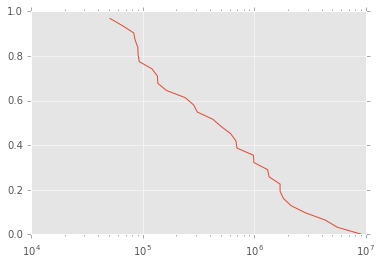

In [35]:
list_1 = auth_sizes[0:31]
N = len(list_1)
fs = np.array(range(N))/float(N)
xs = list_1.sort_values(ascending=False).values
print xs[0]
plt.plot(xs, fs)
ax = plt.gca()
#ax.set_yscale('log')
ax.set_xscale('log')
#plt.savefig('figures/all_grant_auth_dists_v1.pdf')

9246949


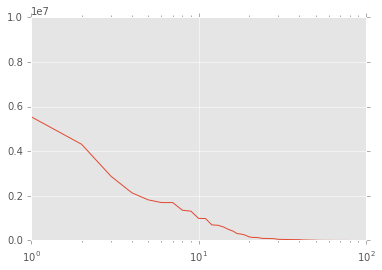

In [36]:
N = len(auth_sizes)
fs = np.array(range(N))
xs = auth_sizes.sort_values(ascending=False).values
print xs[0]
plt.plot(fs, xs)
ax = plt.gca()
#ax.set_yscale('log')
ax.set_xscale('log')
#plt.savefig('figures/all_grant_auth_dists_v1.pdf')

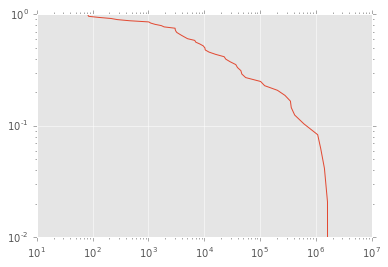

In [37]:
N = len(auth_sizes_pre_ep)
fs = np.array(range(N))/float(N)
xs = auth_sizes_pre_ep.sort_values(ascending=False).values
plt.plot(xs, fs)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
#plt.savefig('figures/all_grant_auth_dists_pre_ep_v1.pdf')

In [38]:
# Get European authority codes
with open('/Users/innovation-sfi/Desktop/eu_auths.txt') as f:
    eu_auths = f.read().splitlines()
# clean off those not contained in patstat
eu_auths = [val for val in auth_by_size if val in eu_auths]
# add 'EP' to the list
eu_auths.insert(0,'EP')
print eu_auths

['EP', 'DE', 'FR', 'GB', 'AT', 'ES', 'CH', 'IT', 'BE', 'DK', 'PL', 'FI', 'PT', 'HU', 'NO', 'NL', 'GR', 'RO', 'CZ', 'LU', 'BG', 'SE', 'IE', 'TR', 'SK', 'SI', 'HR', 'LV', 'EE', 'LT', 'IS', 'MC', 'SM', 'MT']


In [39]:
split = int((auth_sizes.EP/float(len(eu_auths)-1))); print split
auth_sizes_split_ep = auth_sizes; #print auth_sizes_split_ep
auth_sizes_split_ep = auth_sizes_split_ep[auth_sizes_split_ep.index != 'EP']; #print auth_sizes_split_ep
print auth_sizes_split_ep.loc['FR']
print auth_sizes_split_ep.loc['FR'] + split
for eu in eu_auths:
    if eu != 'EP':
        auth_sizes_split_ep.loc[eu] = auth_sizes_split_ep.loc[eu] + split
print auth_sizes_split_ep.head()

39773
2132725
2172498
appln_auth
US    9246949
CN    5542006
JP    4310119
DE    2914388
FR    2172498
dtype: int64


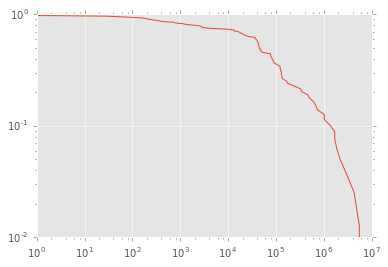

In [40]:
N = len(auth_sizes_split_ep)
fs = np.array(range(N))/float(N)
xs = auth_sizes_split_ep.sort_values(ascending=False).values
plt.plot(xs, fs)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
#plt.savefig('figures/all_grant_auth_dists_eq_split_ep_v1.pdf')

## Distribution of Patents by Pub Yr
[to top](#Table-of-Contents) 

In [41]:
yr_min_max_plt = [df.pub_year.min()-2, df.pub_year.max()+2]; #print yr_min_max ADDED 2 buffer years
yr_bins = range(yr_min_max_plt[0], yr_min_max_plt[1]); #print yr_bins

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


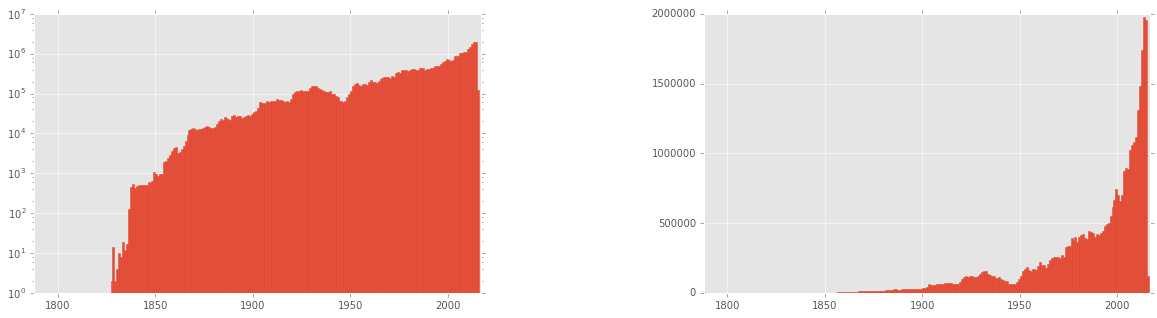

In [42]:
#Complete set

fig, axes = plt.subplots(nrows=1, ncols=2)

clr1 = plt.rcParams['axes.color_cycle'][0]

df['pub_year'].hist(ax=axes[0], bins=yr_bins, log=True, edgecolor=clr1)
df['pub_year'].hist(ax=axes[1], bins=yr_bins, log=False, edgecolor=clr1)

for ax in axes:
    ax.set_xlim(yr_min_max_plt)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(20,5)

# print plt.rcParams['axes.color_cycle'][0] : #E24A33


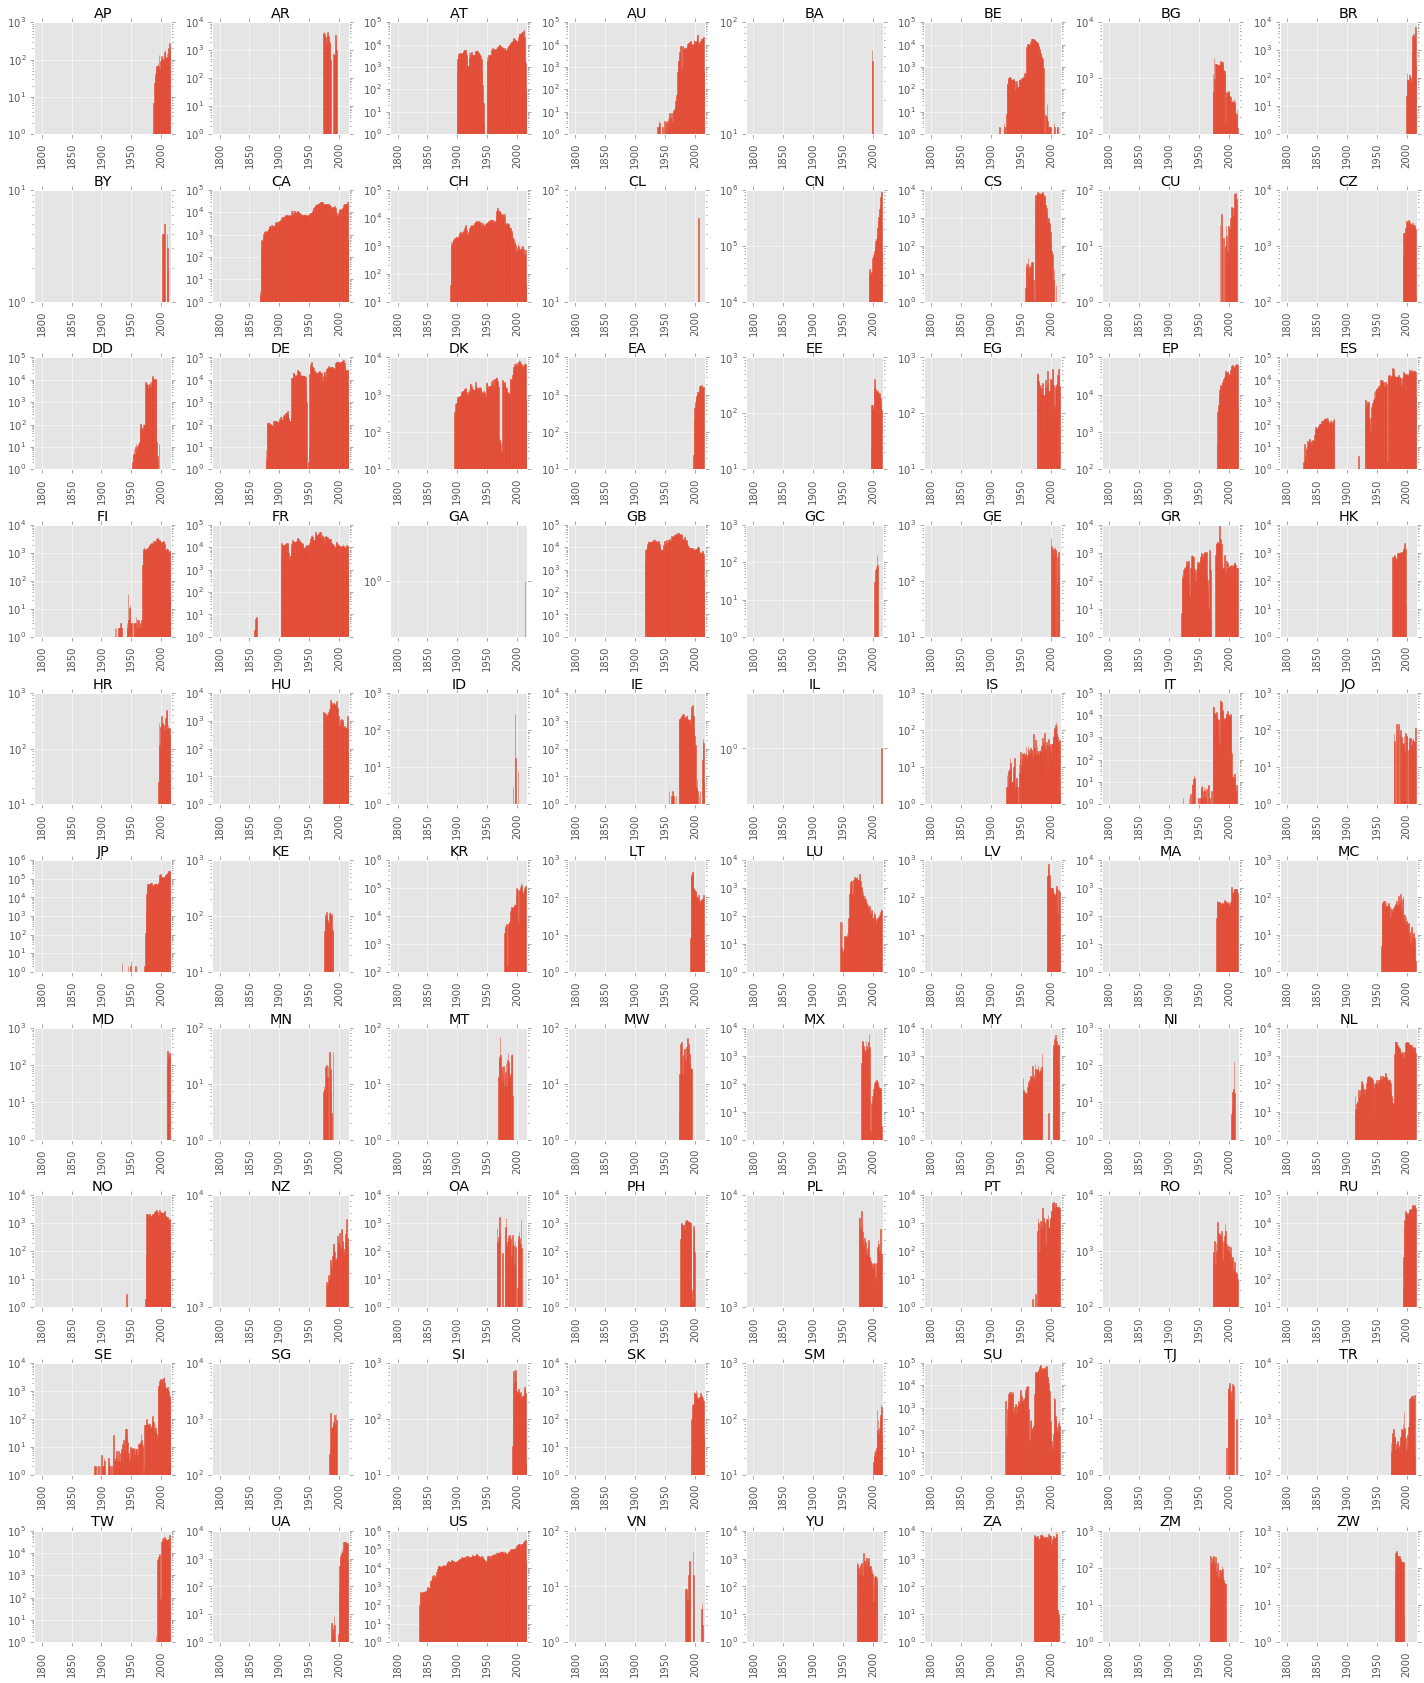

In [43]:
#Grouped by country NOT LOG

col = 8
w = 3
h = 3

axes = df['pub_year'].hist(by=df['appln_auth'], bins=yr_bins, log=True, edgecolor=clr1, 
                           figsize=((col * w),((auth_num / col) * h)), layout=((auth_num / col),col))
for row in axes:
    for ax in row:
        ax.set_xlim(yr_min_max_plt)
#plt.subplots_adjust(wspace=0.5, hspace=1)
#plt.savefig('figures/bad_hist.pdf')

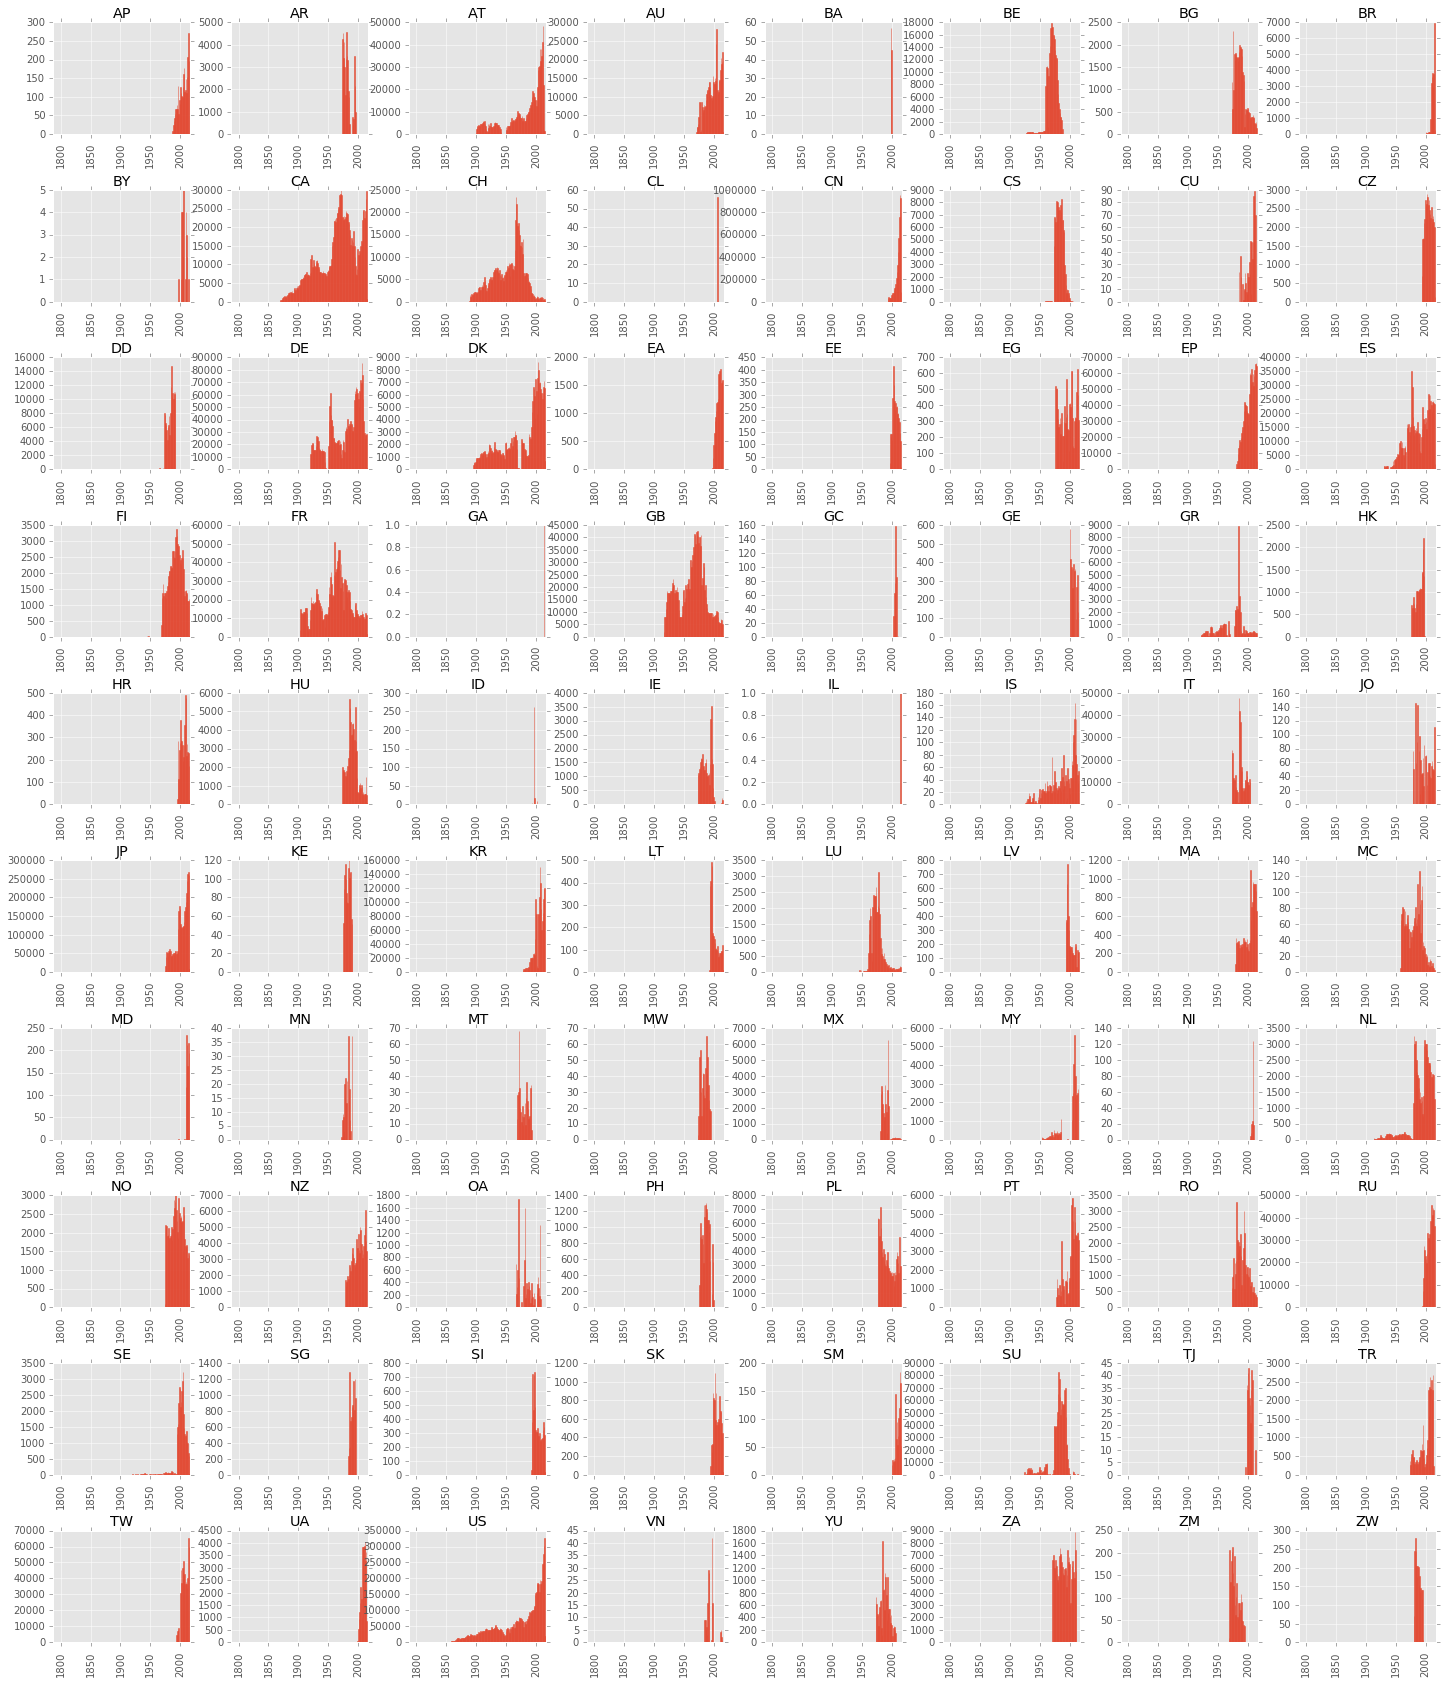

In [44]:
#Grouped by country LOG

axes = df['pub_year'].hist(by=df['appln_auth'], bins=yr_bins, log=False, edgecolor=clr1, 
                           figsize=((col * w),((auth_num / col) * h)), layout=((auth_num / col),col))

for row in axes:
    for ax in row:
        ax.set_xlim(yr_min_max_plt)
#plt.subplots_adjust(wspace=0.5, hspace=1)
#plt.savefig('figures/bad_hist.pdf')

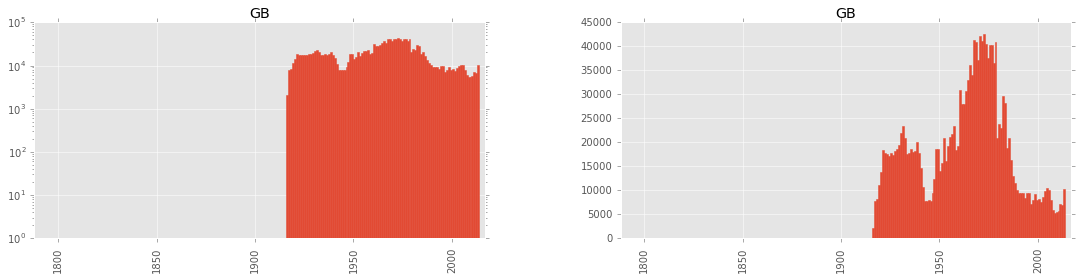

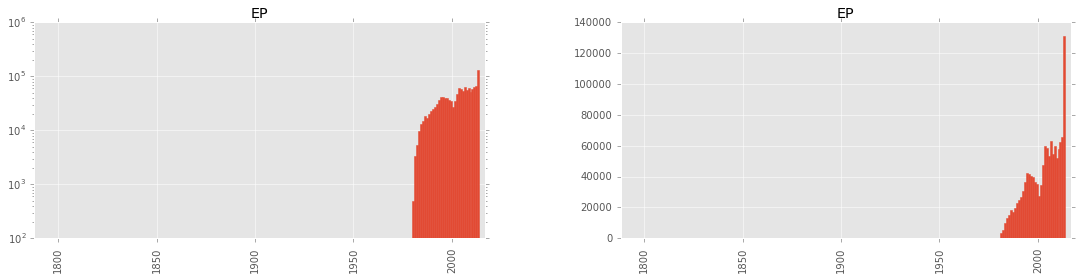

In [45]:
# For top 6

yr_min_max = [df.pub_year.min(), df.pub_year.max()]; #print yr_min_max
yr_bins = range(yr_min_max[0], yr_min_max[1]); #print yr_bins

for auth in ['GB', 'EP']:
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    df[df['appln_auth'] == auth]['pub_year'].hist(by=df['appln_auth'], ax=axes[0], log=True,
                                                  bins=yr_bins, edgecolor=clr1)
    df[df['appln_auth'] == auth]['pub_year'].hist(by=df['appln_auth'], ax=axes[1], log=False,
                                                  bins=yr_bins, edgecolor=clr1)
    for ax in axes:
        ax.set_xlim(yr_min_max_plt)
        #plt.subplots_adjust(wspace=0.5)
    
    fig.set_size_inches(18,4)

## Split-apply-combine On Publication Year
[to top](#Table-of-Contents)

##### Split

In [46]:
grp_pb_year = df.groupby('pub_year')

##### Apply

In [47]:
# Make Series with number of pubs per year
s_pub_num = grp_pb_year.size()
s_pub_num.name = 'num'
print s_pub_num

# Need to fill out missing years with 0s DONT THINK YOU NEED THIS BIT, just let the gaps be there
full_index = range(s_pub_num.index[0], s_pub_num.index[-1]+1)
s_pub_num = s_pub_num.reindex(full_index, fill_value=0)
s_pub_num.head()

pub_year
1790          1
1800          1
1827          2
1828         14
1829          2
1830          4
1831         10
1832          8
1833         19
1834         12
1835         17
1836        125
1837        458
1838        530
1839        425
1840        470
1841        508
1842        508
1843        513
1844        496
1845        507
1846        620
1847        571
1848        655
1849       1047
1850        956
1851        841
1852        973
1853        935
1854       1865
         ...   
1986     437706
1987     427090
1988     400185
1989     422837
1990     417112
1991     430312
1992     441825
1993     480167
1994     493434
1995     502862
1996     553102
1997     615436
1998     663635
1999     742134
2000     700591
2001     660373
2002     704377
2003     869778
2004     891792
2005     884637
2006    1026553
2007    1056004
2008    1079432
2009    1113511
2010    1307081
2011    1485429
2012    1737024
2013    1980151
2014    1956394
2015     121242
Name: num, dtyp

pub_year
1790    1
1791    0
1792    0
1793    0
1794    0
Name: num, dtype: int64

In [48]:
# Make series with number of ipc/cpc/ per pub year
s_pub_ipc = grp_pb_year.has_ipc.sum() ; print s_pub_ipc.head()
s_pub_ipc.name = 'num_ipc'#; print s_pub_ipc.head()
s_pub_cpc = grp_pb_year.has_cpc.sum() 
s_pub_cpc.name ='num_cpc'#; print s_pub_cpc
s_pub_app = grp_pb_year.has_app_date.sum() 
s_pub_app.name = 'num_app'#; print s_pub_app

pub_year
1790    0
1800    0
1827    0
1828    0
1829    0
Name: has_ipc, dtype: int64


#### Combine

In [49]:
# Concate into new dataframe and replace NaN with 0s for completeness
pub_df = pd.concat([s_pub_num, s_pub_app, s_pub_ipc, s_pub_cpc], axis=1)
pub_df = pub_df.fillna(0); pub_df

num  num_app  num_ipc  num_cpc
pub_year                                    
1790            1        1        0        1
1791            0        0        0        0
1792            0        0        0        0
1793            0        0        0        0
1794            0        0        0        0
1795            0        0        0        0
1796            0        0        0        0
1797            0        0        0        0
1798            0        0        0        0
1799            0        0        0        0
1800            1        0        0        1
1801            0        0        0        0
1802            0        0        0        0
1803            0        0        0        0
1804            0        0        0        0
1805            0        0        0        0
1806            0        0        0        0
1807            0        0        0        0
1808            0        0        0        0
1809            0        0        0        0
1810            0        0        0        0
1811            0        0        0        0
1812            0        0        0        0
1813            0        0        0        0
1814            0        0        0        0
1815            0        0        0        0
1816            0        0        0        0
1817            0        0        0        0
1818            0        0        0        0
1819            0        0        0        0
...           ...      ...      ...      ...
1986       437706   437175   433450   272266
1987       427090   426678   423016   264120
1988       400185   399891   397723   243749
1989       422837   422643   418606   258996
1990       417112   416578   412773   248480
1991       430312   429854   428436   252594
1992       441825   441326   439951   269675
1993       480167   479813   478022   310154
1994       493434   493147   491360   338082
1995       502862   502477   500995   341618
1996       553102   552771   550472   366173
1997       615436   615002   613449   385423
1998       663635   663363   661593   413020
1999       742134   741777   739334   436296
2000       700591   700197   698562   414902
2001       660373   659794   641231   419913
2002       704377   704256   685778   469738
2003       869778   869778   847448   543562
2004       891792   891792   869668   562551
2005       884637   884637   868093   513094
2006      1026553  1026551   997264   595311
2007      1056004  1056004  1023091   587539
2008      1079432  1079432  1044067   584278
2009      1113511  1113511  1081193   589910
2010      1307081  1307081  1278709   658117
2011      1485429  1485429  1461289   699328
2012      1737024  1737024  1711335   761244
2013      1980151  1980151  1951462   795784
2014      1956394  1956394  1922170   804672
2015       121242   121242   119532    39774

[226 rows x 4 columns]

In [50]:
# Process into new dataframe of fractional quantities ready to plot, for zero entries used 1

pub_frac_df = pub_df[['num_app', 'num_ipc', 'num_cpc']].div(pub_df['num'], axis='index')
pub_frac_df.fillna(0, inplace=True) 
pub_frac_df.rename(columns={key: key.replace("num", 'frac') for key in pub_frac_df.columns}, inplace=True)
pub_frac_df

frac_app  frac_ipc  frac_cpc
pub_year                              
1790      1.000000  0.000000  1.000000
1791      0.000000  0.000000  0.000000
1792      0.000000  0.000000  0.000000
1793      0.000000  0.000000  0.000000
1794      0.000000  0.000000  0.000000
1795      0.000000  0.000000  0.000000
1796      0.000000  0.000000  0.000000
1797      0.000000  0.000000  0.000000
1798      0.000000  0.000000  0.000000
1799      0.000000  0.000000  0.000000
1800      0.000000  0.000000  1.000000
1801      0.000000  0.000000  0.000000
1802      0.000000  0.000000  0.000000
1803      0.000000  0.000000  0.000000
1804      0.000000  0.000000  0.000000
1805      0.000000  0.000000  0.000000
1806      0.000000  0.000000  0.000000
1807      0.000000  0.000000  0.000000
1808      0.000000  0.000000  0.000000
1809      0.000000  0.000000  0.000000
1810      0.000000  0.000000  0.000000
1811      0.000000  0.000000  0.000000
1812      0.000000  0.000000  0.000000
1813      0.000000  0.000000  0.000000
1814      0.000000  0.000000  0.000000
1815      0.000000  0.000000  0.000000
1816      0.000000  0.000000  0.000000
1817      0.000000  0.000000  0.000000
1818      0.000000  0.000000  0.000000
1819      0.000000  0.000000  0.000000
...            ...       ...       ...
1986      0.998787  0.990277  0.622029
1987      0.999035  0.990461  0.618418
1988      0.999265  0.993848  0.609091
1989      0.999541  0.989994  0.612520
1990      0.998720  0.989598  0.595715
1991      0.998936  0.995640  0.587002
1992      0.998871  0.995759  0.610366
1993      0.999263  0.995533  0.645929
1994      0.999418  0.995797  0.685162
1995      0.999234  0.996287  0.679347
1996      0.999402  0.995245  0.662035
1997      0.999295  0.996771  0.626260
1998      0.999590  0.996923  0.622360
1999      0.999519  0.996227  0.587894
2000      0.999438  0.997104  0.592217
2001      0.999123  0.971013  0.635872
2002      0.999828  0.973595  0.666884
2003      1.000000  0.974327  0.624943
2004      1.000000  0.975192  0.630810
2005      1.000000  0.981299  0.580005
2006      0.999998  0.971469  0.579913
2007      1.000000  0.968833  0.556380
2008      1.000000  0.967237  0.541283
2009      1.000000  0.970976  0.529775
2010      1.000000  0.978294  0.503501
2011      1.000000  0.983749  0.470792
2012      1.000000  0.985211  0.438246
2013      1.000000  0.985512  0.401880
2014      1.000000  0.982507  0.411304
2015      1.000000  0.985896  0.328055

[226 rows x 3 columns]

### Distribution in Time by Pub Check/Practice
[to top](#Table-of-Contents)

(1788, 2017)

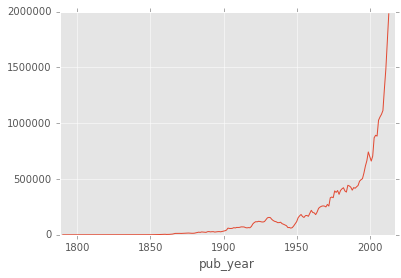

In [51]:
pub_df.num[:-2].plot()
plt.xlim(yr_min_max_plt)

## Checking Application Dates
[to top](#Table-of-Contents)

(-0.1, 1.1)

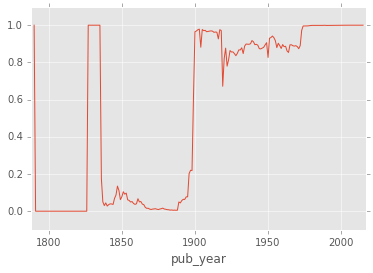

In [52]:
pub_frac_df.frac_app.plot()
plt.xlim(yr_min_max_plt)
plt.ylim(-0.1, 1.1)

## Checking Classfications 
[to top](#Table-of-Contents)

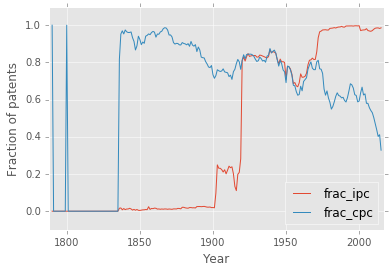

In [53]:
pub_frac_df[['frac_ipc','frac_cpc']].plot()
plt.xlim(yr_min_max_plt)
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

#plt.savefig('figures/frac_class_year.png')

# Split-apply-combine On Authority And Publication Year
[to top](#Table-of-Contents)

#### Split

In [54]:
grp_auth_year = df.groupby(['appln_auth', 'pub_year'])

#### Apply

In [55]:
s_au_year_num = grp_auth_year.size()
s_au_year_num.name = 'num'
s_au_year_app = grp_auth_year.has_app_date.sum()
s_au_year_app.name = 'num_app'
s_au_year_ipc = grp_auth_year.has_ipc.sum()
s_au_year_ipc.name = 'num_ipc'
s_au_year_cpc = grp_auth_year.has_cpc.sum()
s_au_year_cpc.name = 'num_cpc'

## Quick number of patents authority-pub-year
[to top](#Table-of-Contents)

In [56]:
s_au_year_num_piv = s_au_year_num.reset_index(level=0).pivot(columns='appln_auth',values='num')

(1788, 2017)

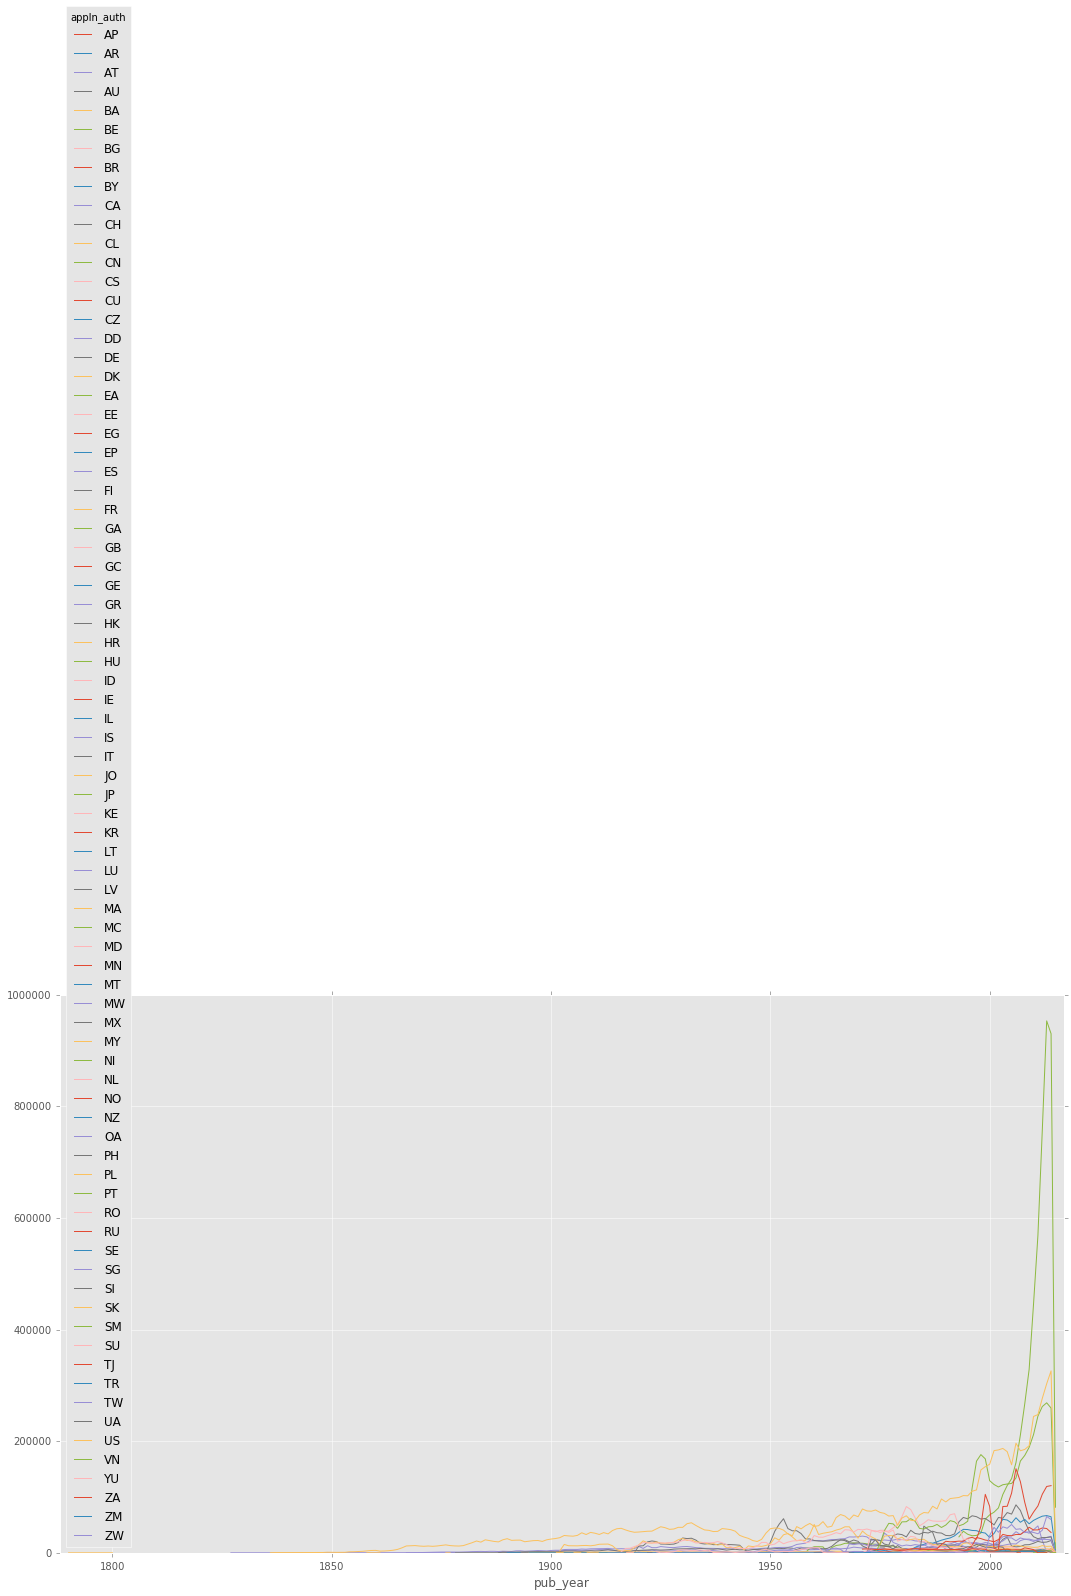

In [57]:
s_au_year_num_piv.plot(figsize=(18,10))
plt.xlim(yr_min_max_plt)

(1788, 2017)

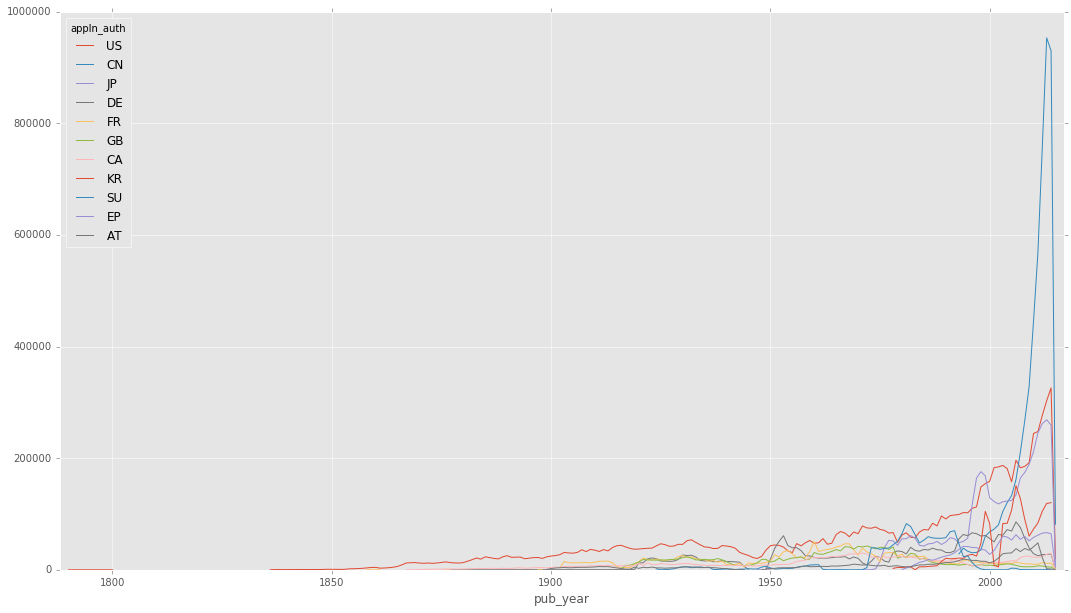

In [58]:
s_au_year_num_piv[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(yr_min_max_plt)

(1788, 2017)

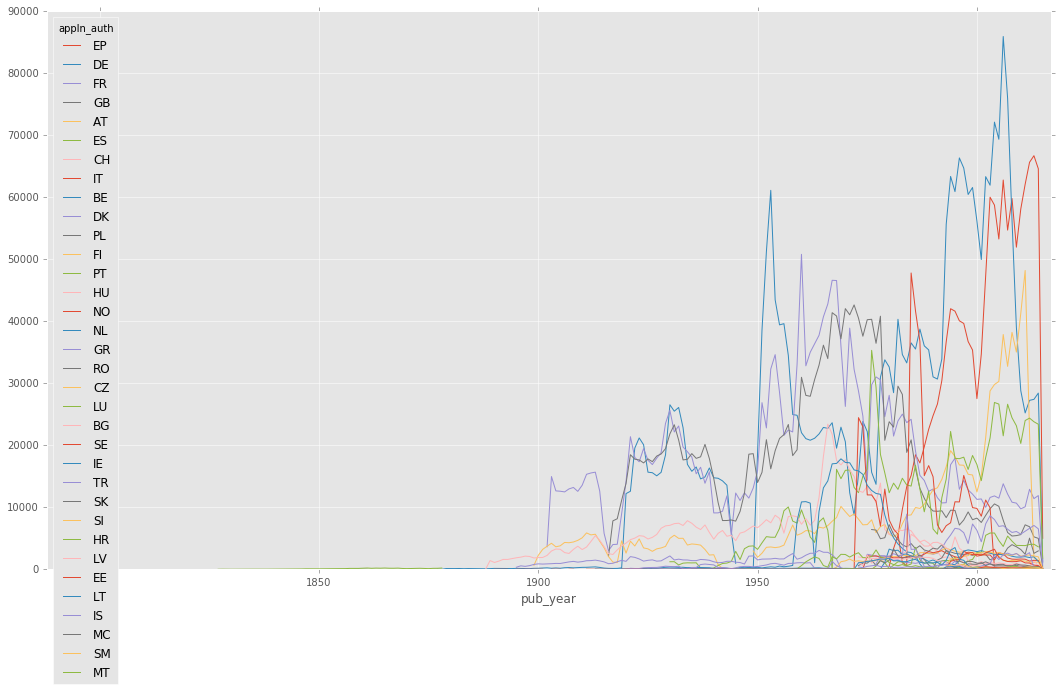

In [59]:
s_au_year_num_piv[eu_auths].plot(figsize=(18,10))
plt.xlim(yr_min_max_plt)

### Combine

In [60]:
# Concate into new dataframe
df_au_year_num = pd.concat([s_au_year_num,s_au_year_app,s_au_year_ipc,s_au_year_cpc], axis=1)
df_au_year_num.fillna(0, inplace=True); df_au_year_num.head()

num  num_app  num_ipc  num_cpc
appln_auth pub_year                                
AP         1985        1        1        1        1
           1986        1        1        1        1
           1987        7        7        7        7
           1988       24       24       24       24
           1989       34       34       34       34

In [61]:
df_au_year_num_10 = df_au_year_num[df_au_year_num > 10]; df_au_year_num_10

num  num_app  num_ipc  num_cpc
appln_auth pub_year                                
AP         1985      NaN      NaN      NaN      NaN
           1986      NaN      NaN      NaN      NaN
           1987      NaN      NaN      NaN      NaN
           1988       24       24       24       24
           1989       34       34       34       34
           1990       42       42       42       42
           1991       53       53       53       53
           1992       67       67       67       67
           1993       66       66       66       66
           1994       79       79       79       79
           1995       68       68       68       68
           1996      129      129      129      129
           1997       54       54       54       54
           1998       91       91       91       88
           1999       81       81       81       81
           2000      126      126      126      126
           2001      111      111      111      111
           2002      102      102      102       93
           2003       99       99       99       92
           2004      126      126      124       45
           2005      162      162      160      111
           2006      176      176      176      172
           2007      112      112      112      112
           2008      119      119      119      114
           2009      147      147      147      145
           2010      111      111      111      105
           2011      154      154      154      148
           2012      206      206      205      200
           2013      271      271      271      254
           2014      197      197      197      186
...                  ...      ...      ...      ...
ZM         1980      101      101       99       66
           1981      132      132      124       89
           1982       56       56       51       29
           1983       53       53       51       30
           1984       87       87       84       37
           1985       66       66       64       24
           1986       88       88       86       49
           1987       73       73       73       49
           1988      109      109      107       43
           1989       91       91       86       29
           1990       51       51       51       26
           1991       48       48       47       17
           1992       39       39       36       17
           1994       36       36       36       21
ZW         1980       71       71       71       52
           1981      244      244      242      190
           1982      279      279      277      207
           1983      246      246      242      190
           1984      204      204      204      156
           1985      175      175      175      146
           1986      204      204      204      165
           1987      202      202      202      152
           1988      154      154      154      121
           1989      177      177      176      131
           1990      134      134      133       89
           1991      147      147      147      103
           1992      141      141      139       95
           1993      116      116      115       79
           1994      140      140      139       96
           1995      NaN      NaN      NaN      NaN

[3754 rows x 4 columns]

In [62]:
# Process into new dataframe of fractional quantities ready to plot, for zero entries used 1

df_au_year_frac = df_au_year_num[['num_app', 'num_ipc', 'num_cpc']].div(df_au_year_num['num'], axis='index')
df_au_year_frac.fillna(0, inplace=True) 
df_au_year_frac.rename(columns={key: key.replace("num", 'frac') for key in df_au_year_frac.columns}, inplace=True)
df_au_year_frac.head()

frac_app  frac_ipc  frac_cpc
appln_auth pub_year                              
AP         1985             1         1         1
           1986             1         1         1
           1987             1         1         1
           1988             1         1         1
           1989             1         1         1

In [63]:
# Process into new dataframe of fractional quantities ready to plot, for zero entries used 1

df_au_year_frac_10 = df_au_year_num_10[['num_app', 'num_ipc', 'num_cpc']].div(df_au_year_num_10['num'], axis='index')
df_au_year_frac_10.fillna(0, inplace=True) 
df_au_year_frac_10.rename(columns={key: key.replace("num", 'frac') for key in df_au_year_frac_10.columns}, inplace=True)
df_au_year_frac_10

frac_app  frac_ipc  frac_cpc
appln_auth pub_year                              
AP         1985             0  0.000000  0.000000
           1986             0  0.000000  0.000000
           1987             0  0.000000  0.000000
           1988             1  1.000000  1.000000
           1989             1  1.000000  1.000000
           1990             1  1.000000  1.000000
           1991             1  1.000000  1.000000
           1992             1  1.000000  1.000000
           1993             1  1.000000  1.000000
           1994             1  1.000000  1.000000
           1995             1  1.000000  1.000000
           1996             1  1.000000  1.000000
           1997             1  1.000000  1.000000
           1998             1  1.000000  0.967033
           1999             1  1.000000  1.000000
           2000             1  1.000000  1.000000
           2001             1  1.000000  1.000000
           2002             1  1.000000  0.911765
           2003             1  1.000000  0.929293
           2004             1  0.984127  0.357143
           2005             1  0.987654  0.685185
           2006             1  1.000000  0.977273
           2007             1  1.000000  1.000000
           2008             1  1.000000  0.957983
           2009             1  1.000000  0.986395
           2010             1  1.000000  0.945946
           2011             1  1.000000  0.961039
           2012             1  0.995146  0.970874
           2013             1  1.000000  0.937269
           2014             1  1.000000  0.944162
...                       ...       ...       ...
ZM         1980             1  0.980198  0.653465
           1981             1  0.939394  0.674242
           1982             1  0.910714  0.517857
           1983             1  0.962264  0.566038
           1984             1  0.965517  0.425287
           1985             1  0.969697  0.363636
           1986             1  0.977273  0.556818
           1987             1  1.000000  0.671233
           1988             1  0.981651  0.394495
           1989             1  0.945055  0.318681
           1990             1  1.000000  0.509804
           1991             1  0.979167  0.354167
           1992             1  0.923077  0.435897
           1994             1  1.000000  0.583333
ZW         1980             1  1.000000  0.732394
           1981             1  0.991803  0.778689
           1982             1  0.992832  0.741935
           1983             1  0.983740  0.772358
           1984             1  1.000000  0.764706
           1985             1  1.000000  0.834286
           1986             1  1.000000  0.808824
           1987             1  1.000000  0.752475
           1988             1  1.000000  0.785714
           1989             1  0.994350  0.740113
           1990             1  0.992537  0.664179
           1991             1  1.000000  0.700680
           1992             1  0.985816  0.673759
           1993             1  0.991379  0.681034
           1994             1  0.992857  0.685714
           1995             0  0.000000  0.000000

[3754 rows x 3 columns]

In [64]:
# Pivot on authorieties (need to unindex it first)
df_au_year_frac_pv = df_au_year_frac.reset_index(level=0).pivot(columns='appln_auth')
df_au_year_frac_pv.fillna(1, inplace=True) # made value for year with no patents equal to 1 i.e non are missing
df_au_year_frac_pv

frac_app                                                    ...     \
appln_auth       AP AR AT        AU BA        BE BG BR BY        CA    ...      
pub_year                                                               ...      
1790              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1800              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1827              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1828              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1829              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1830              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1831              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1832              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1833              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1834              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1835              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1836              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1837              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1838              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1839              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1840              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1841              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1842              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1843              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1844              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1845              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1846              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1847              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1848              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1849              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1850              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1851              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1852              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1853              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
1854              1  1  1  1.000000  1  1.000000  1  1  1  1.000000    ...      
...             ... .. ..       ... ..       ... .. .. ..       ...    ...      
1986              1  1  1  0.999667  1  0.999543  1  1  1  0.970363    ...      
1987              1  1  1  0.999908  1  1.000000  1  1  1  0.973077    ...      
1988              1  1  1  1.000000  1  1.000000  1  1  1  0.982908    ...      
1989              1  1  1  1.000000  1  1.000000  1  1  1  0.988303    ...      
1990              1  1  1  1.000000  1  1.000000  1  1  1  0.964031    ...      
1991              1  1  1  1.000000  1  1.000000  1  1  1  0.971235    ...      
1992              1  1  1  1.000000  1  1.000000  1  1  1  0.973679    ...      
1993              1  1  1  1.000000  1  1.000000  1  1  1  0.976391    ...      
1994              1  1  1  1.000000  1  1.000000  1  1  1  0.976053    ...      
1995              1  1  1  1.000000  1  1.000000  1  1  1  0.959703    ...      
1996              1  1  1  1.000000  1  1.000000  1  1  1  0.955713    ...      
1997              1  1  1  1.000000  1  1.000000  1  1  1  0.938865    ...      
1998              1  1  1  1.000000  1  1.000000  1  1  1  0.969144    ...      
1999              1  1  1  1.000000  1  1.000000  1  1  1  0.974584    ...      
2000              1  1  1  1.000000  1  1.000000  1  1  1  0.968285    ...      
2001              1  1  1  1.000000  1  1.

In [65]:
# Pivot on authorieties (need to unindex it first)
df_au_year_frac_10_pv = df_au_year_frac_10.reset_index(level=0).pivot(columns='appln_auth')
df_au_year_frac_10_pv.fillna(0, inplace=True) # made value for year with no patents equal to 1 i.e non are missing
df_au_year_frac_10_pv

frac_app                                                    ...     \
appln_auth       AP AR AT        AU BA        BE BG BR BY        CA    ...      
pub_year                                                               ...      
1790              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1800              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1827              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1828              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1829              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1830              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1831              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1832              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1833              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1834              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1835              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1836              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1837              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1838              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1839              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1840              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1841              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1842              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1843              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1844              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1845              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1846              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1847              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1848              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1849              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1850              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1851              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1852              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1853              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
1854              0  0  0  0.000000  0  0.000000  0  0  0  0.000000    ...      
...             ... .. ..       ... ..       ... .. .. ..       ...    ...      
1986              0  0  1  0.999667  0  0.999543  1  0  0  0.970363    ...      
1987              0  0  1  0.999908  0  1.000000  1  0  0  0.973077    ...      
1988              1  0  1  1.000000  0  1.000000  1  0  0  0.982908    ...      
1989              1  0  1  1.000000  0  0.000000  1  0  0  0.988303    ...      
1990              1  1  1  1.000000  0  0.000000  1  0  0  0.964031    ...      
1991              1  1  1  1.000000  0  0.000000  1  0  0  0.971235    ...      
1992              1  1  1  1.000000  0  0.000000  1  0  0  0.973679    ...      
1993              1  1  1  1.000000  0  1.000000  1  0  0  0.976391    ...      
1994              1  1  1  1.000000  0  0.000000  1  0  0  0.976053    ...      
1995              1  1  1  1.000000  0  0.000000  1  0  0  0.959703    ...      
1996              1  0  1  1.000000  0  0.000000  1  0  0  0.955713    ...      
1997              1  0  1  1.000000  0  0.000000  1  0  0  0.938865    ...      
1998              1  0  1  1.000000  1  0.000000  1  0  0  0.969144    ...      
1999              1  0  1  1.000000  1  0.000000  1  1  0  0.974584    ...      
2000              1  0  1  1.000000  0  0.000000  1  1  0  0.968285    ...      
2001              1  0  1  1.000000  0  0.

## Checking Application Dates By Auth-Year
[to top](#Table-of-Contents)

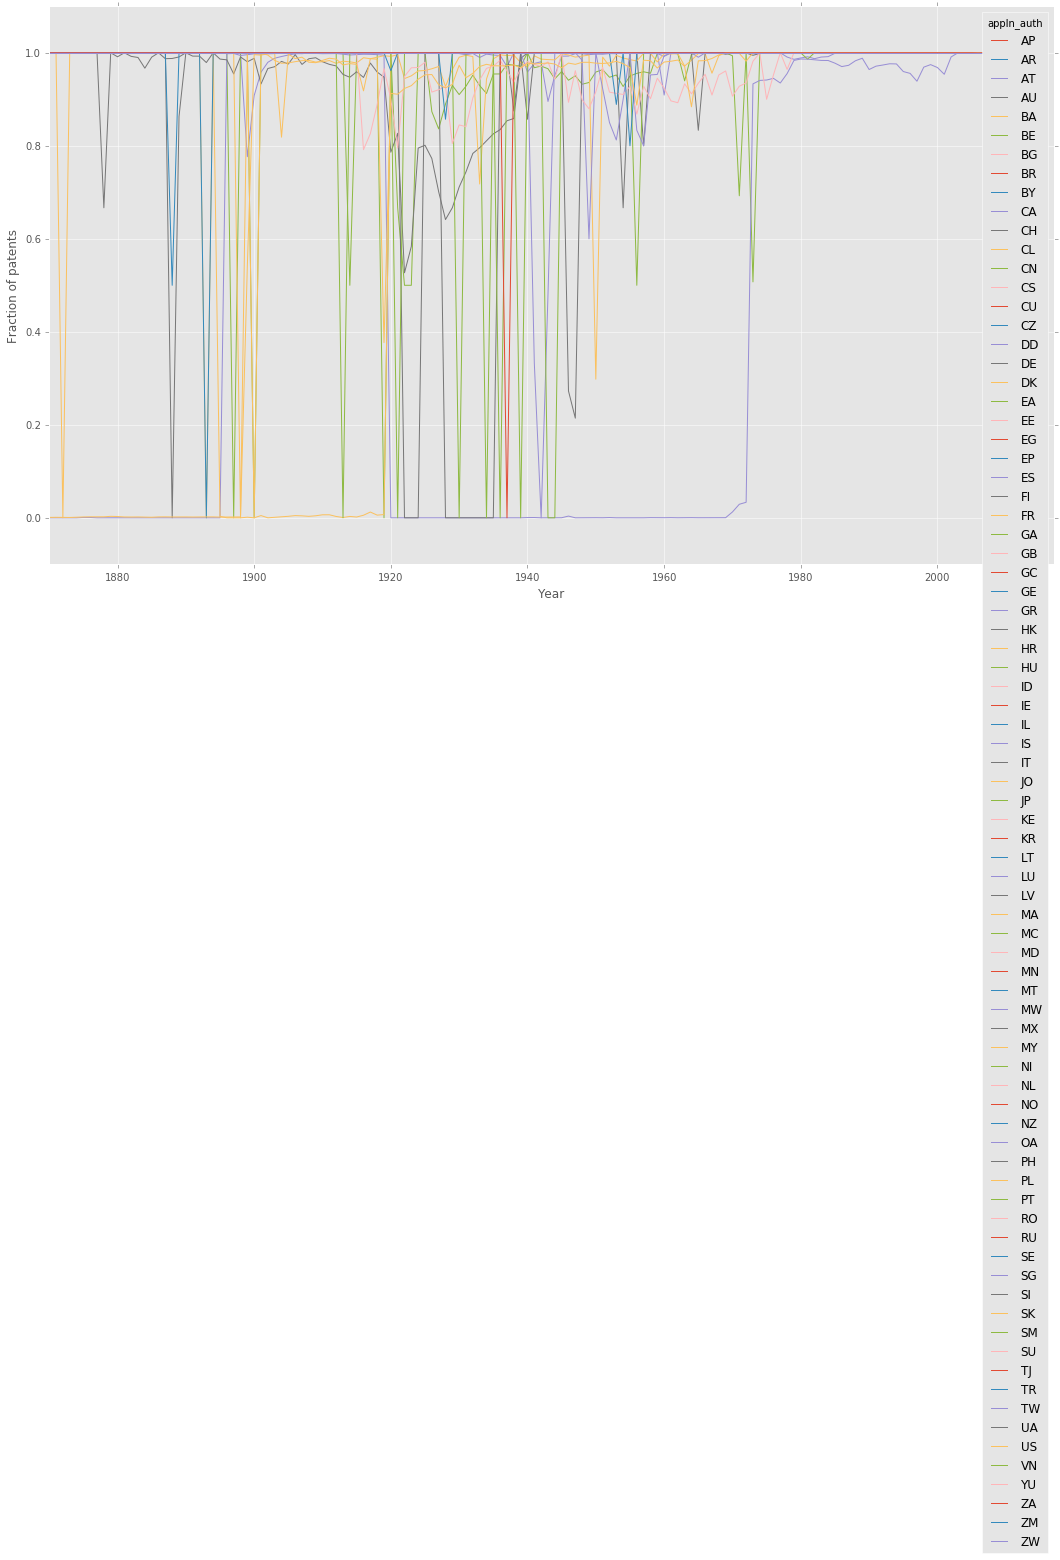

In [66]:
# For all Auths

df_au_year_frac_pv.frac_app.plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

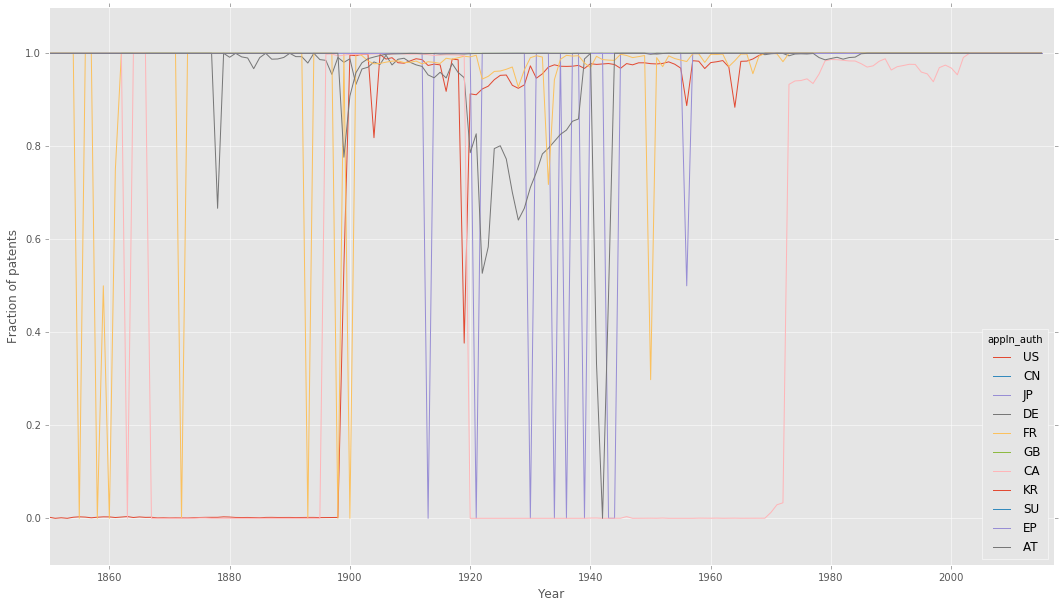

In [67]:
# For top 10

df_au_year_frac_pv.frac_app[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(1850,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

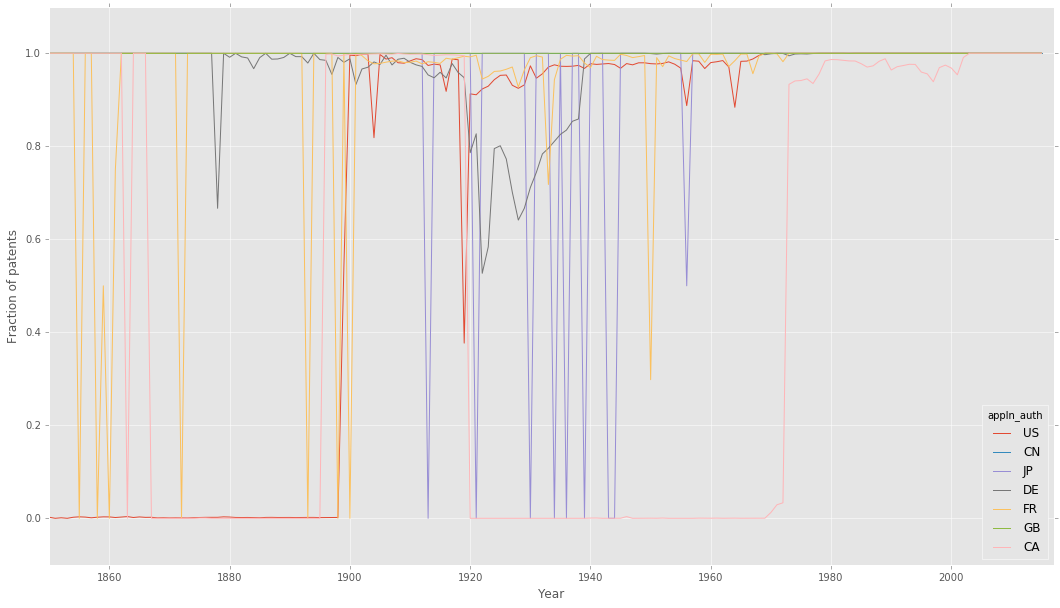

In [68]:
# For top 6

df_au_year_frac_pv.frac_app[auth_by_size[0:7]].plot(figsize=(18,10))
plt.xlim(1850,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

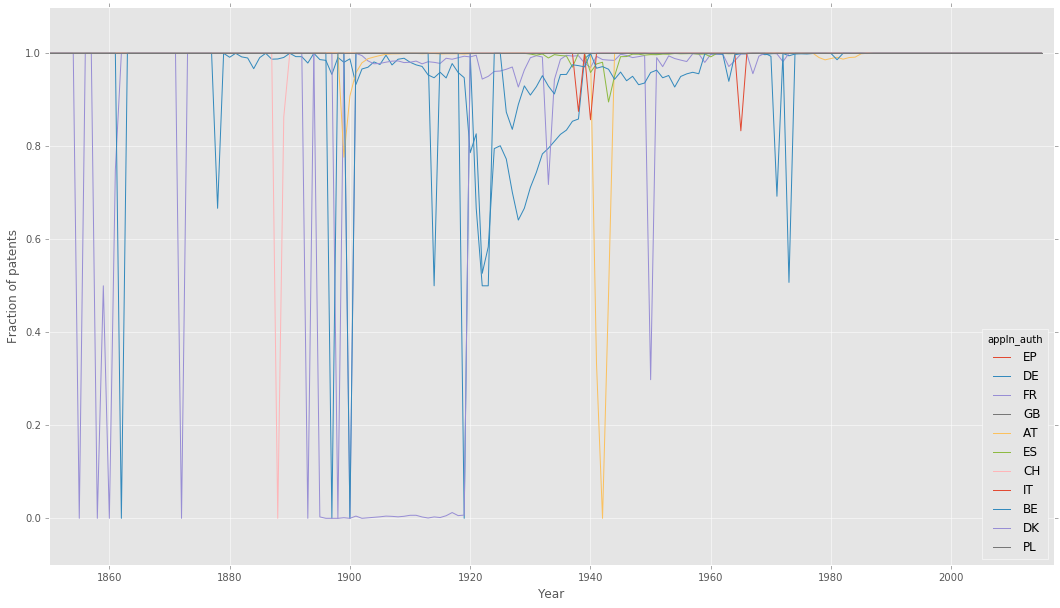

In [69]:
# For European Top 10 Auths

df_au_year_frac_pv.frac_app[eu_auths[0:11]].plot(figsize=(18,10))
plt.xlim(1850,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

## Checking IPC Classfications By Auth
[to top](#Table-of-Contents)

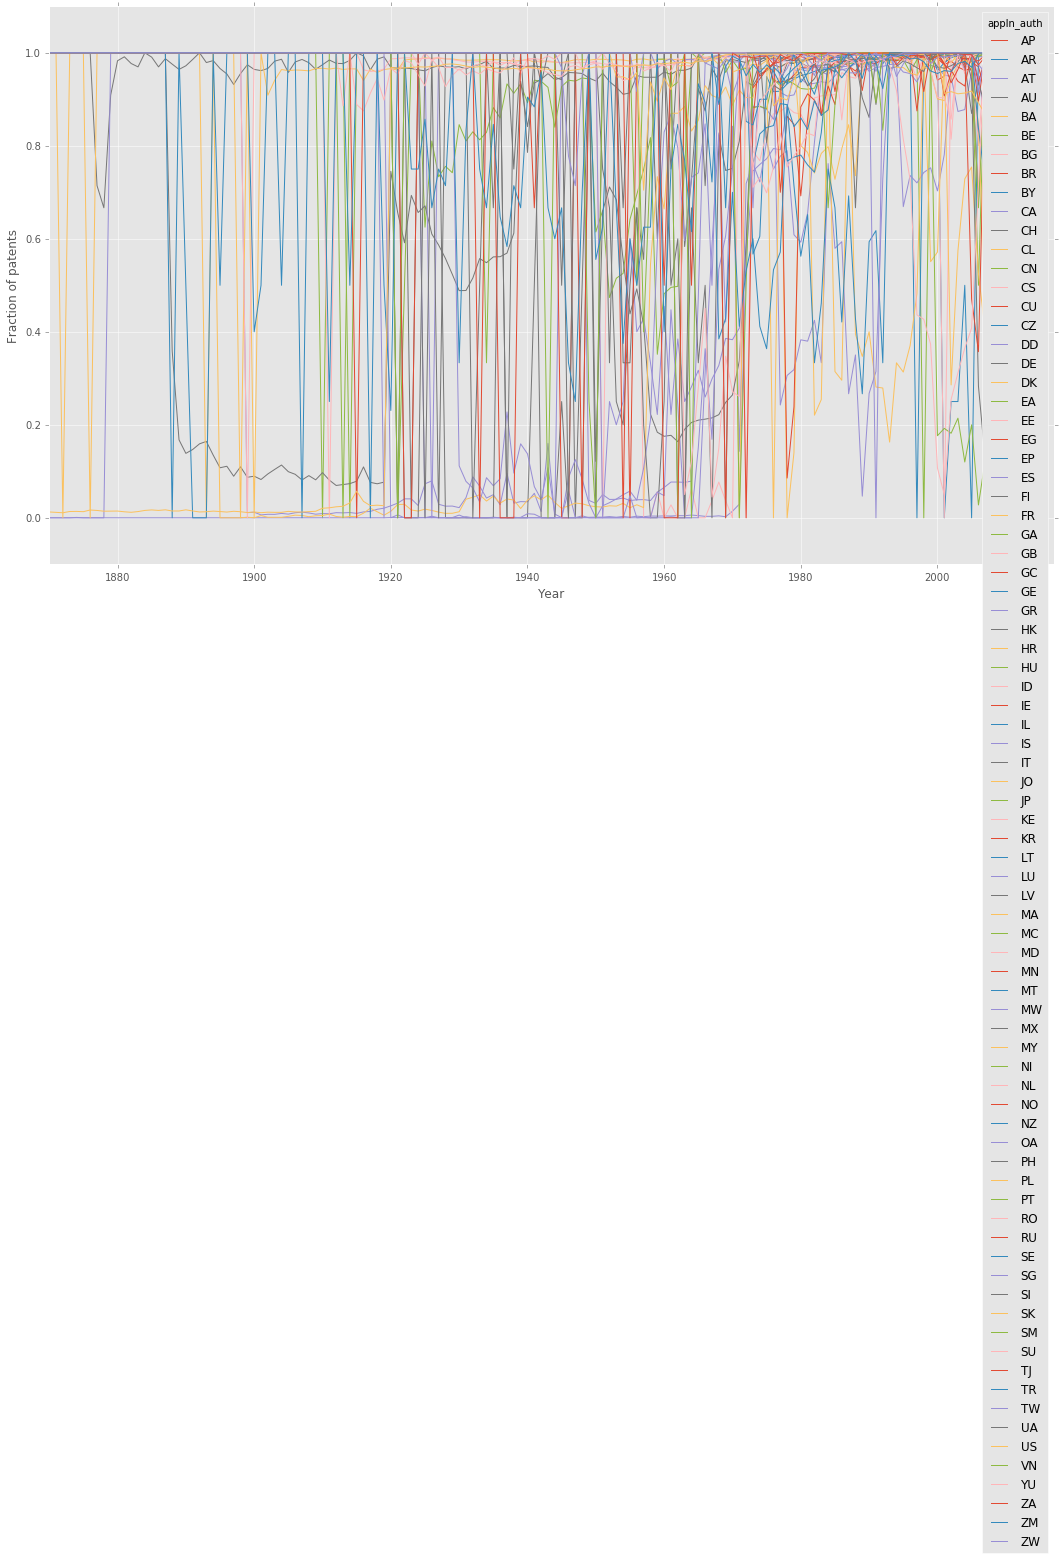

In [70]:
# For all Auths

df_au_year_frac_pv.frac_ipc.plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

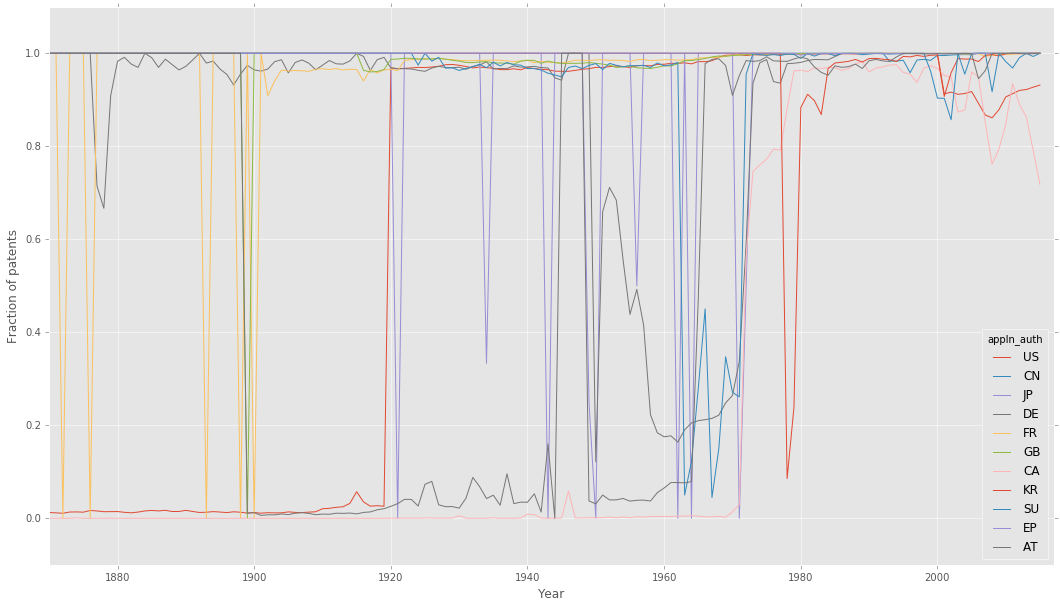

In [71]:
# For top 10

df_au_year_frac_pv.frac_ipc[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

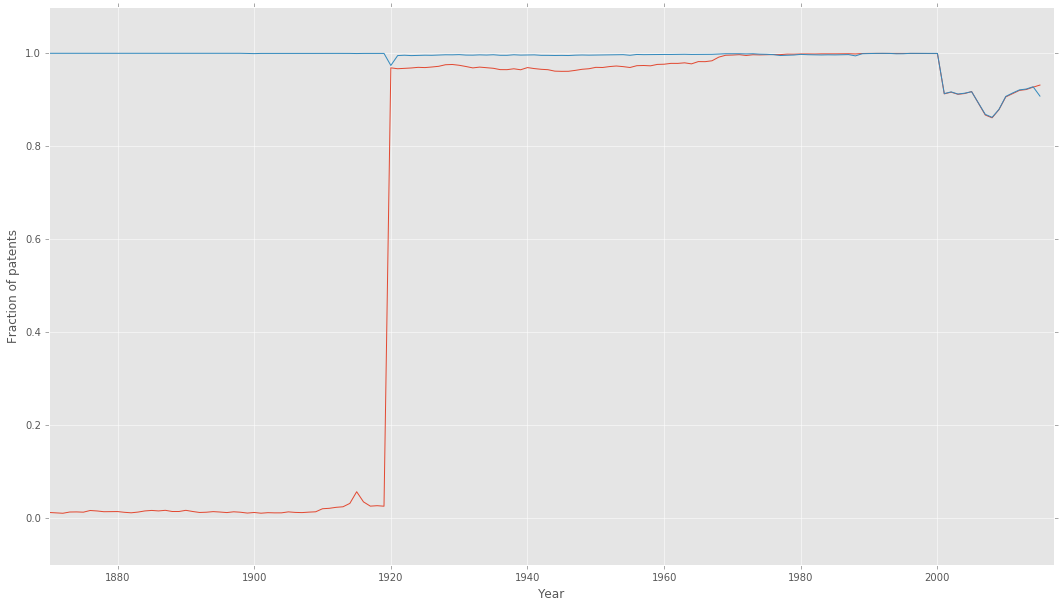

US


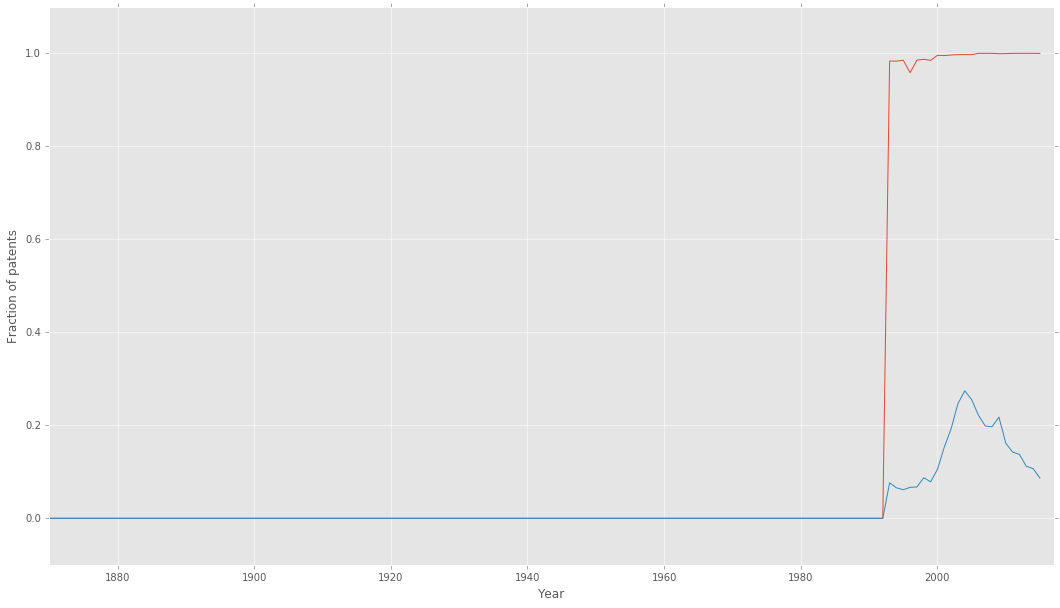

CN


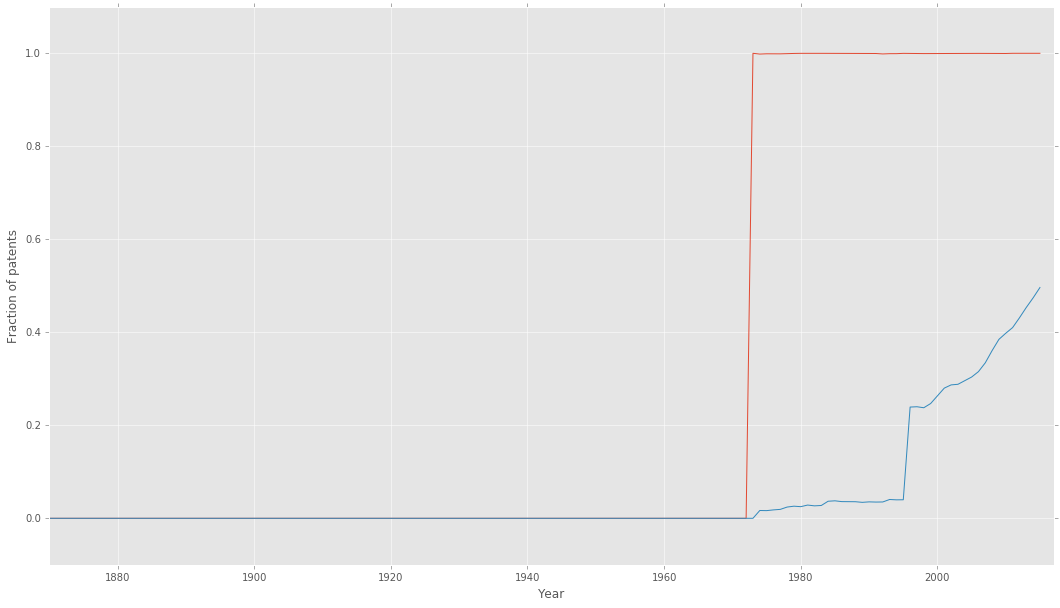

JP


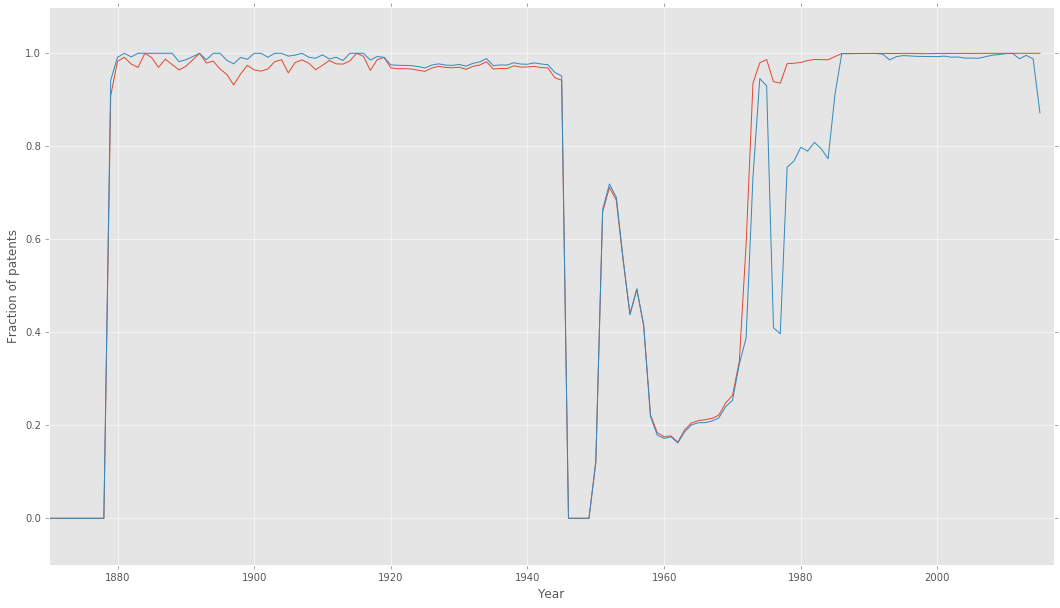

DE


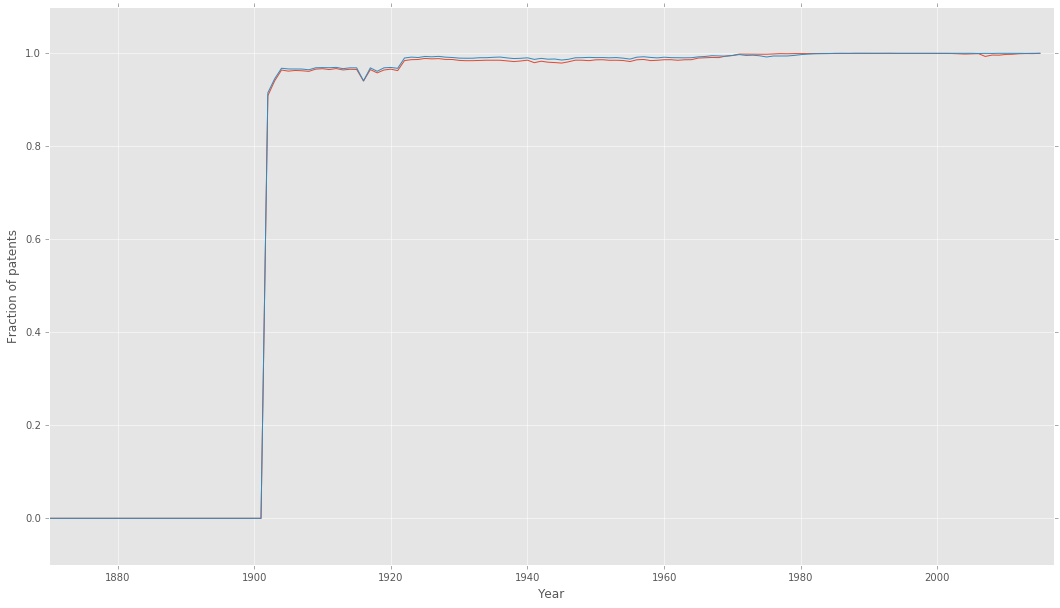

FR


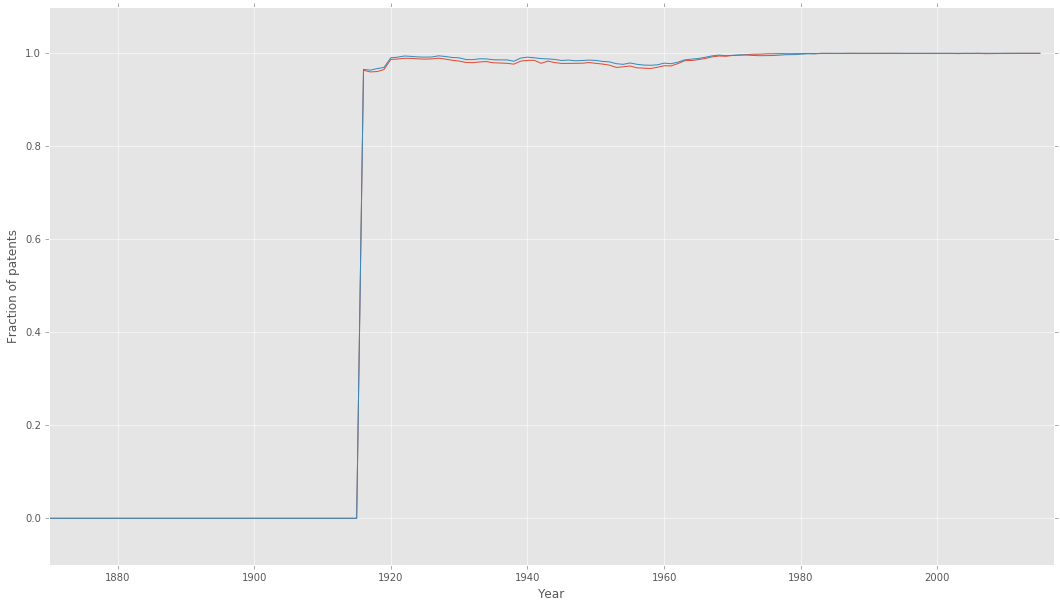

GB


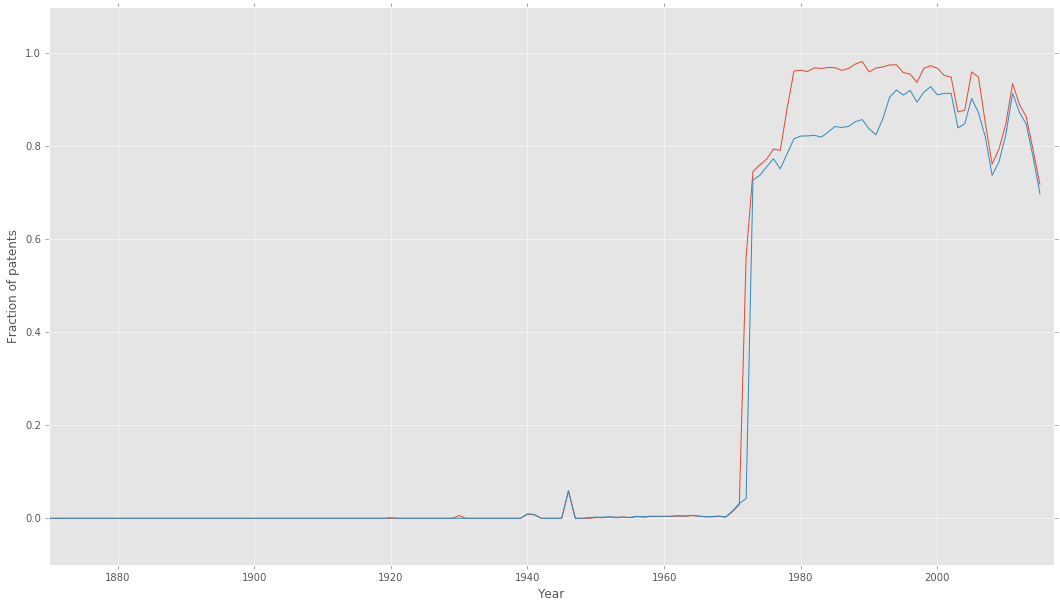

CA


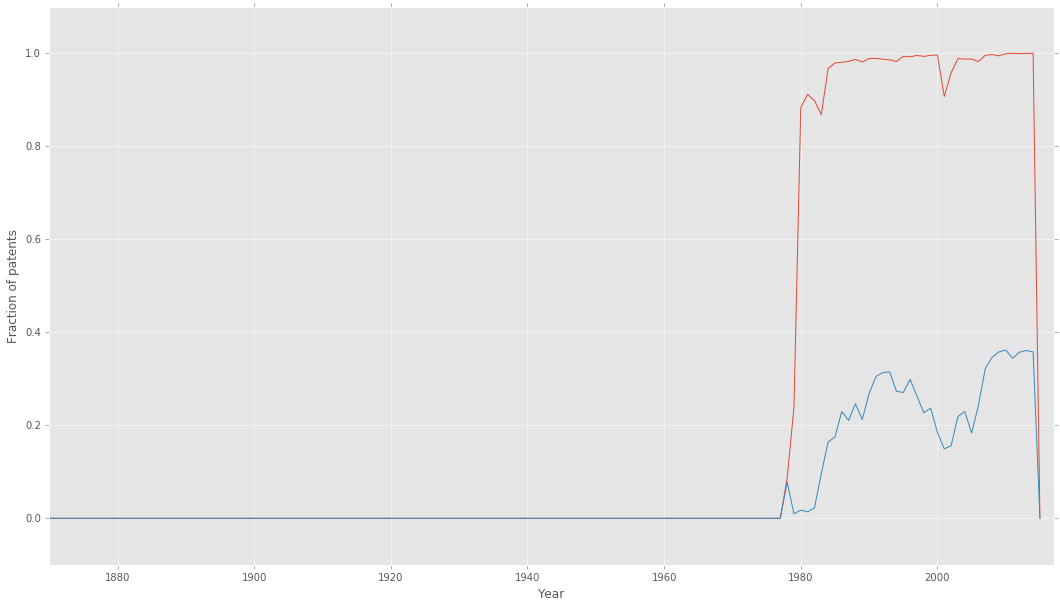

KR


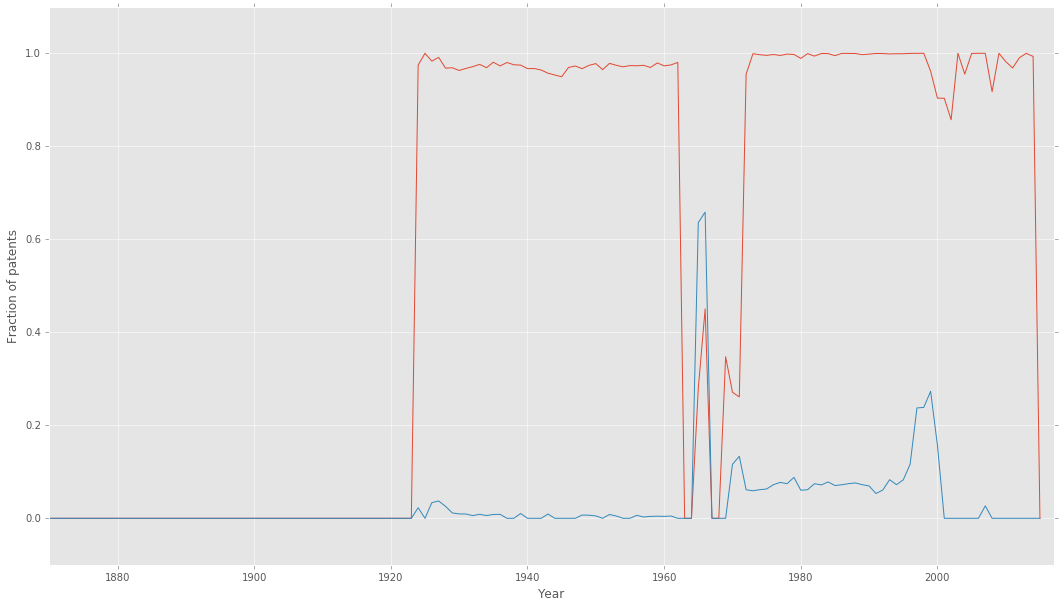

SU


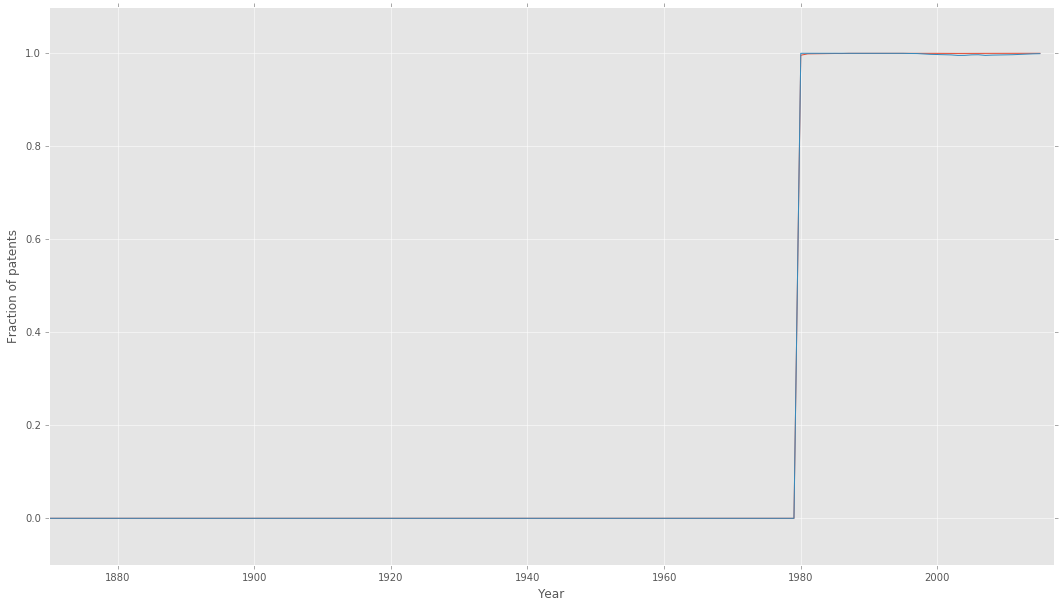

EP


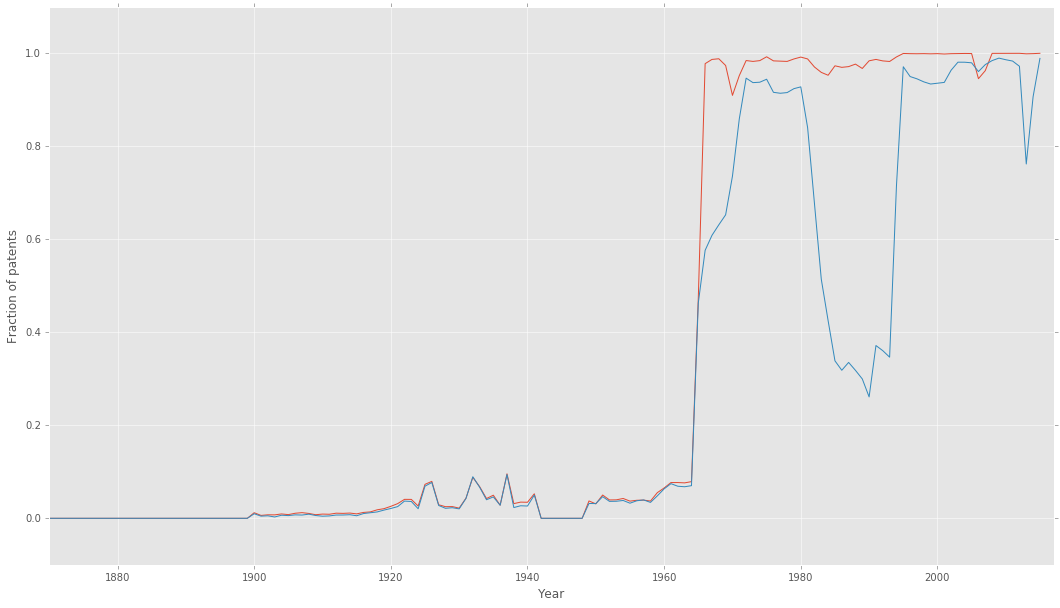

AT


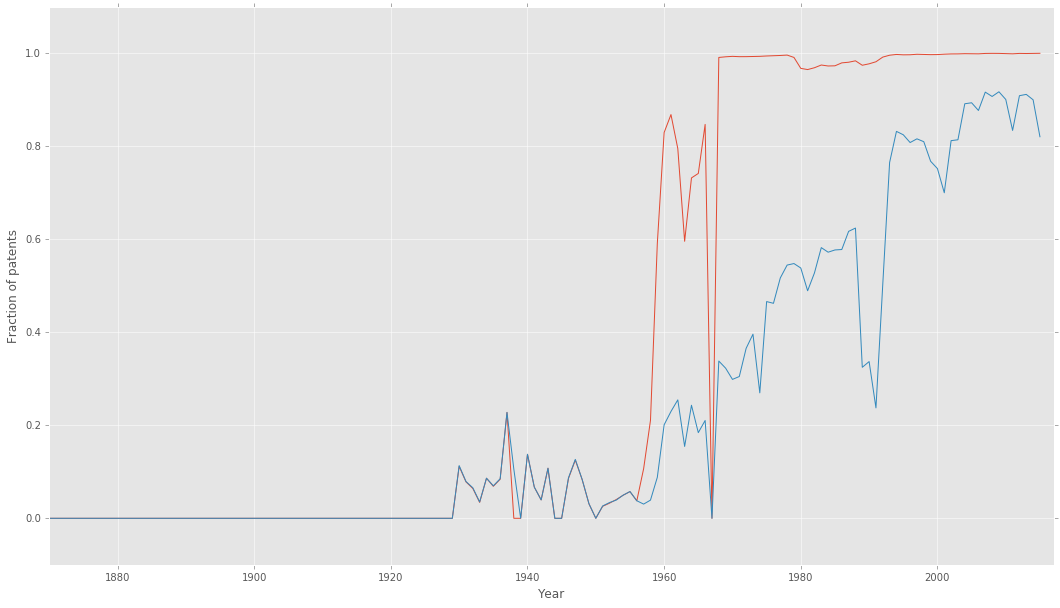

ES


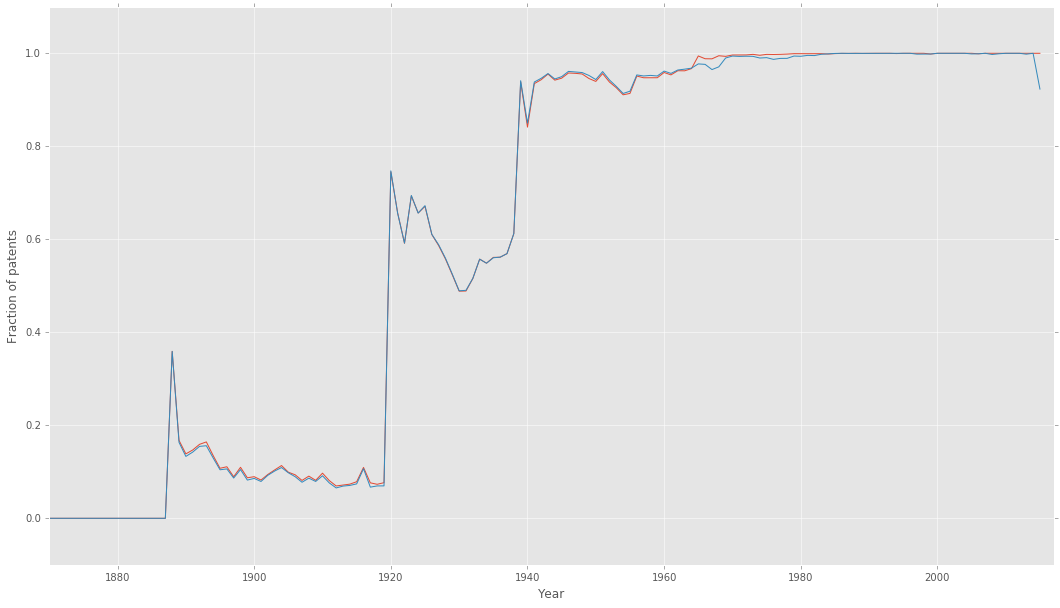

CH


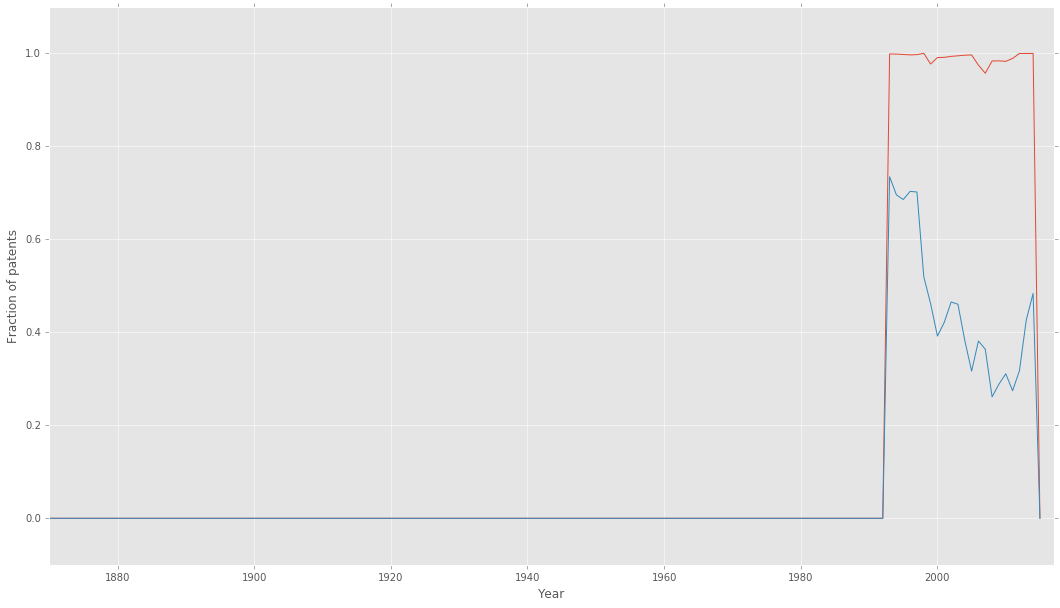

TW


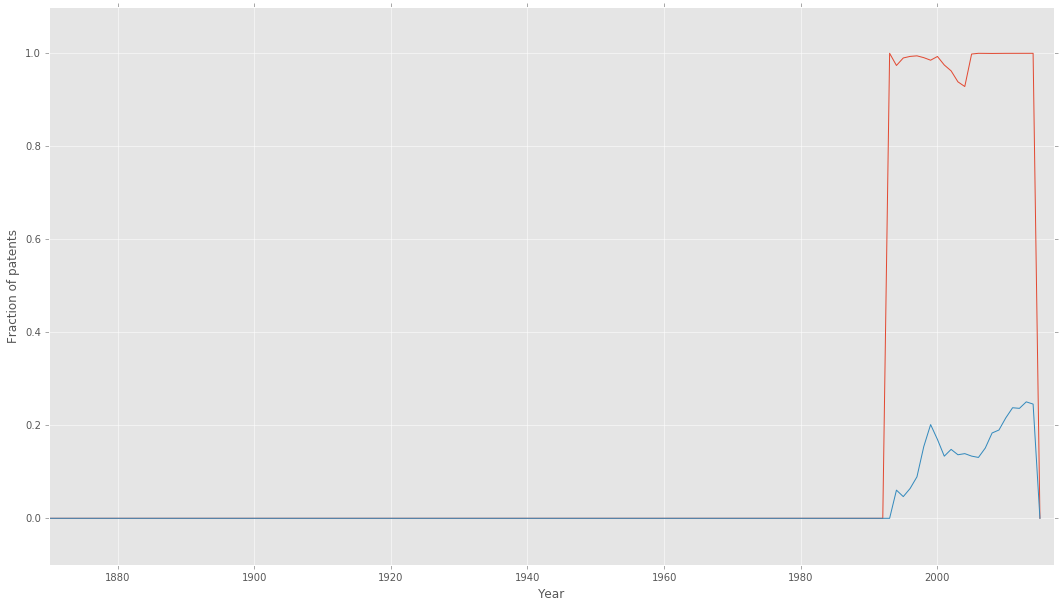

RU


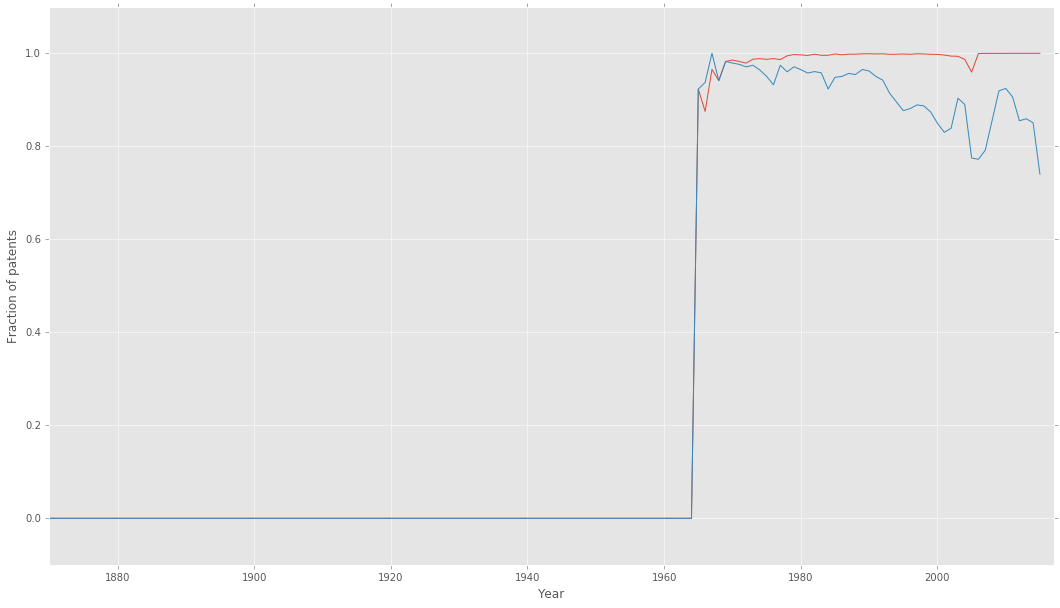

AU


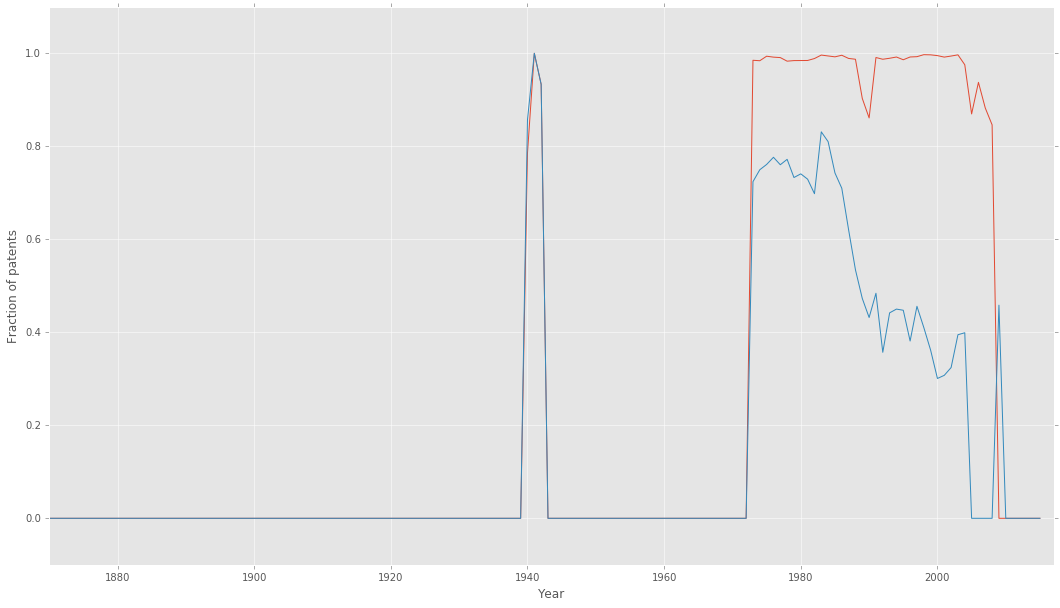

IT


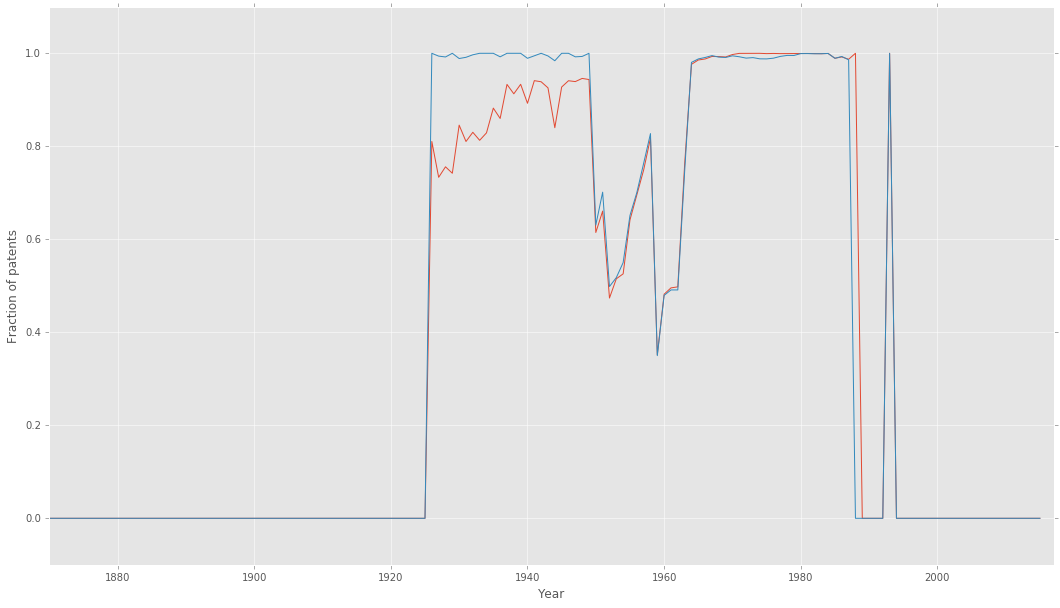

BE


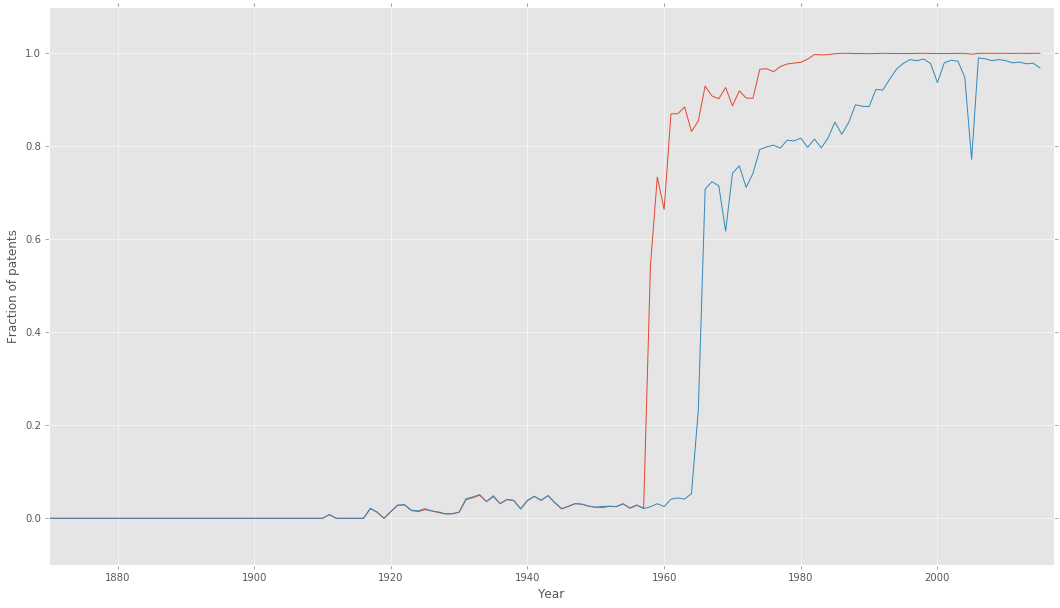

DK


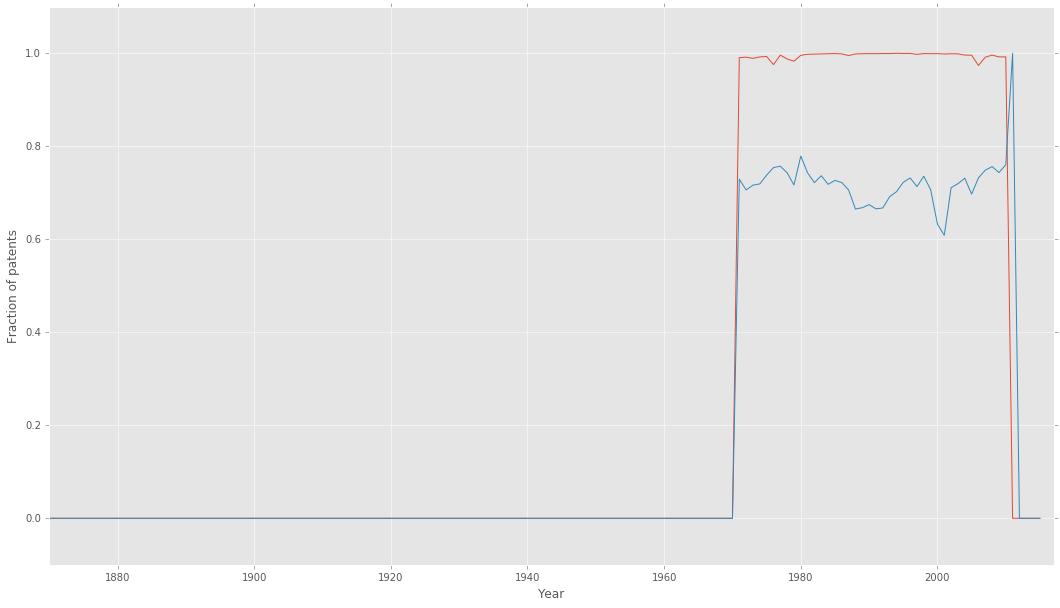

ZA


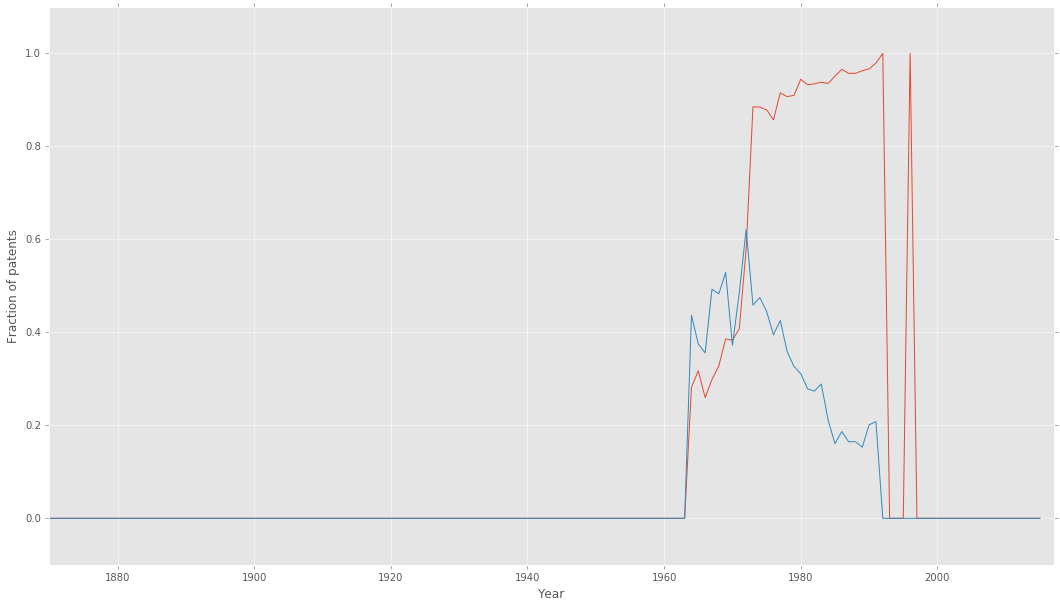

DD


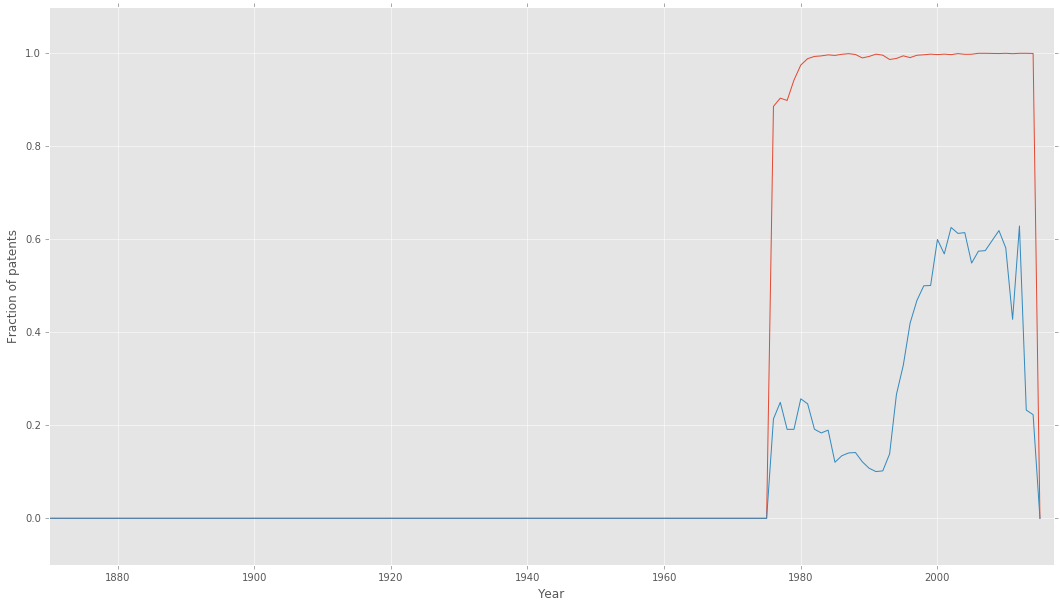

PL


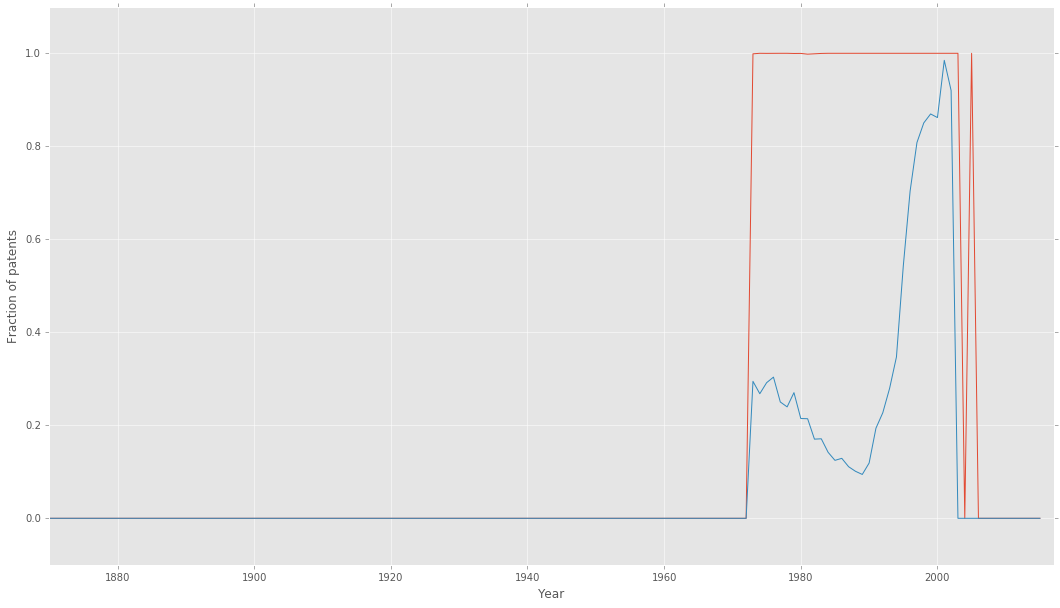

CS


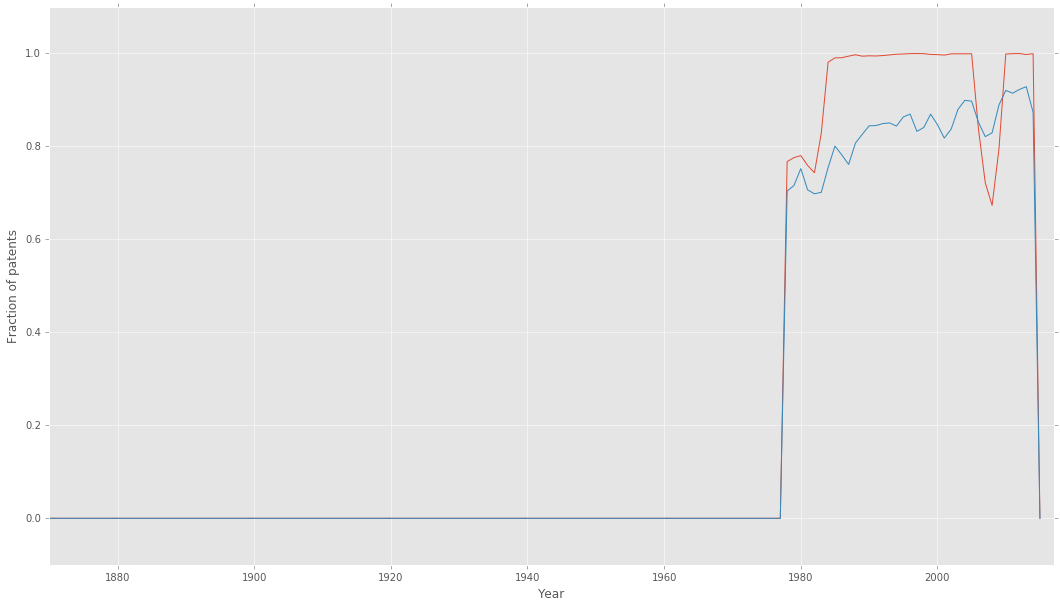

NZ


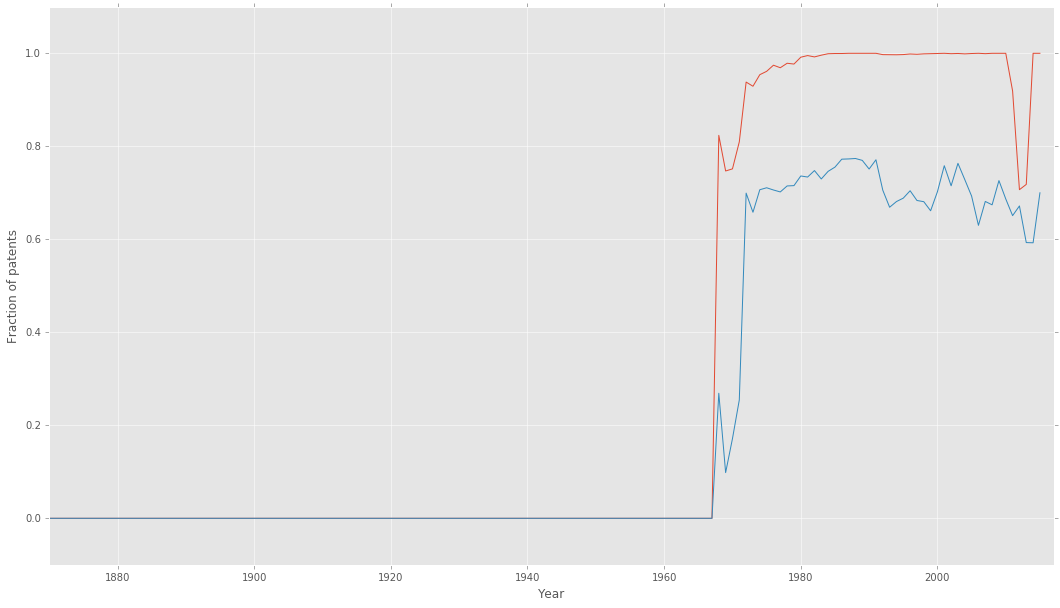

FI


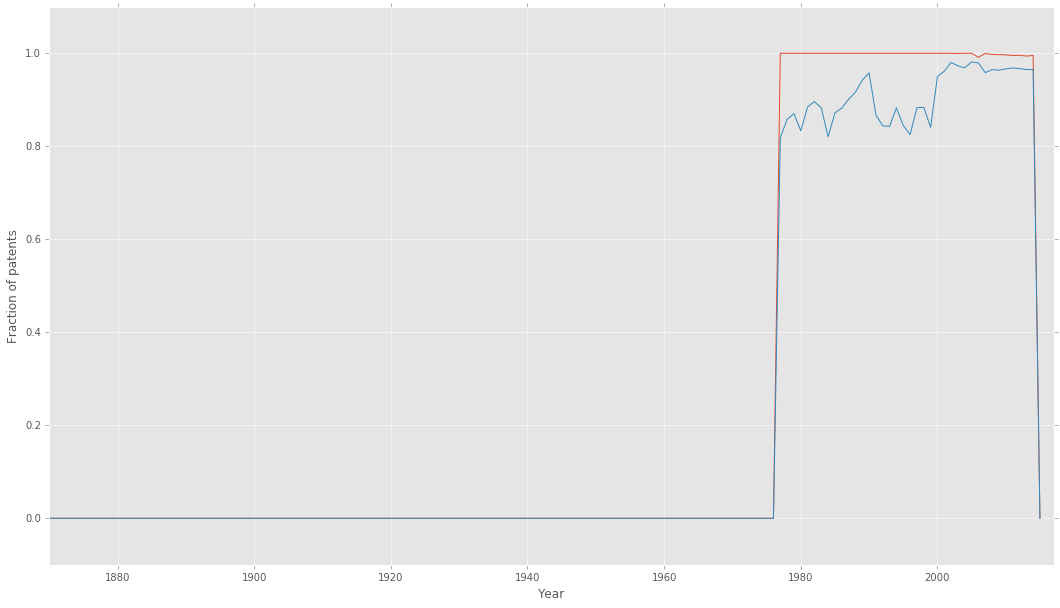

PT


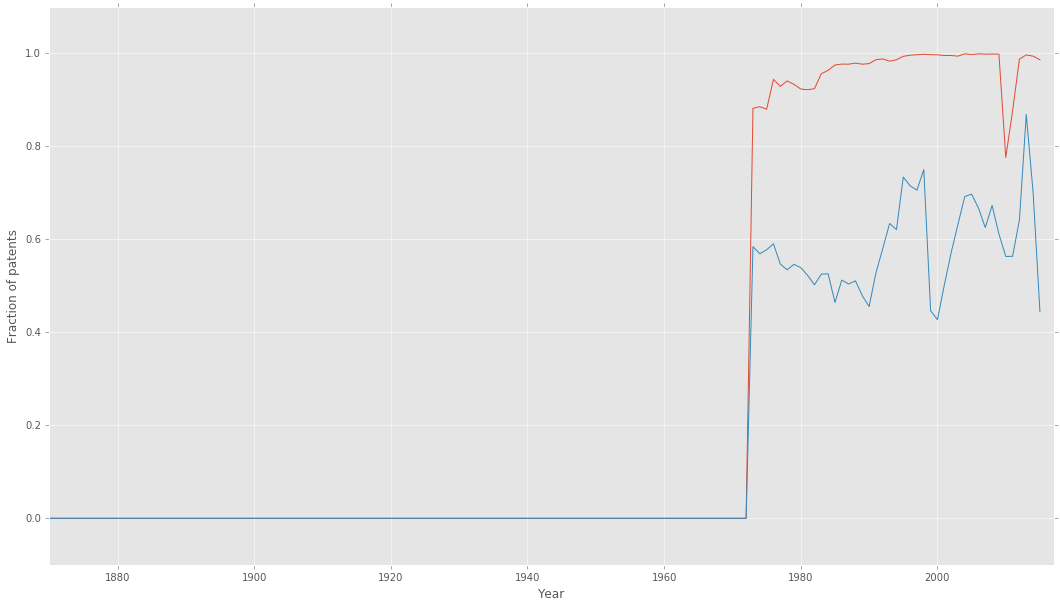

HU


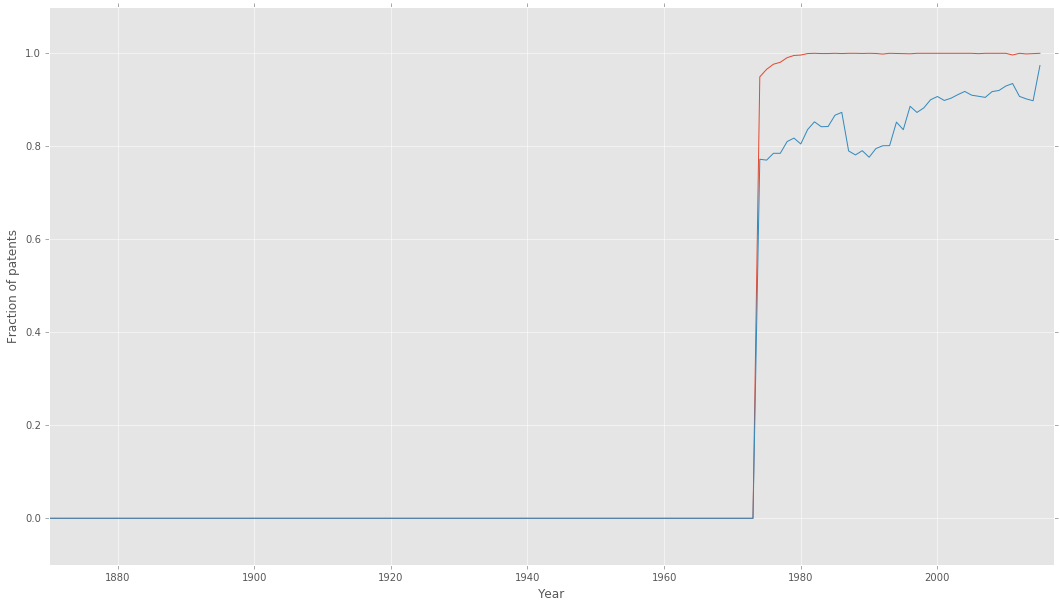

NO


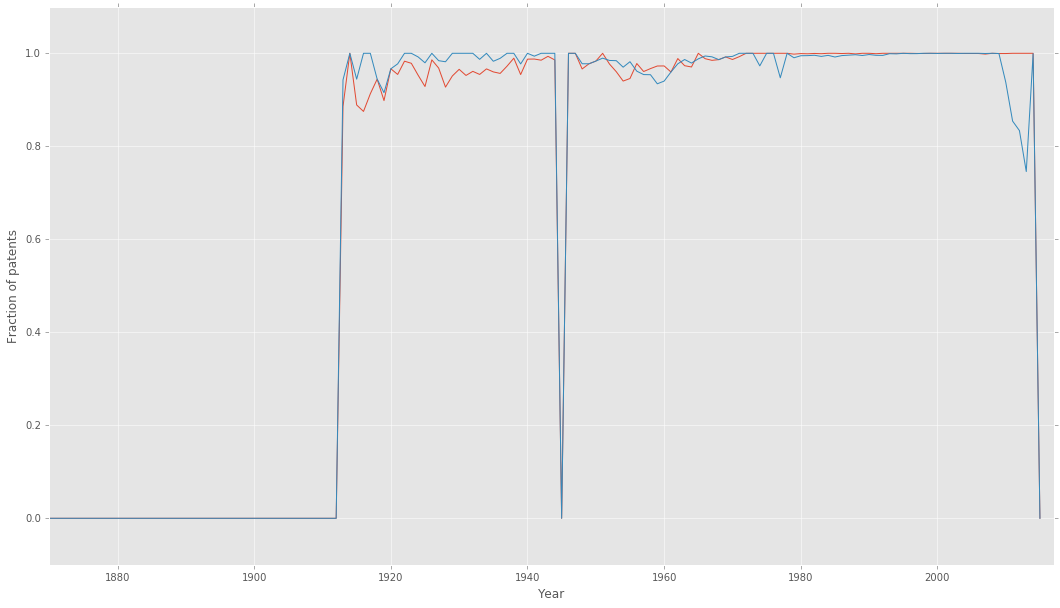

NL


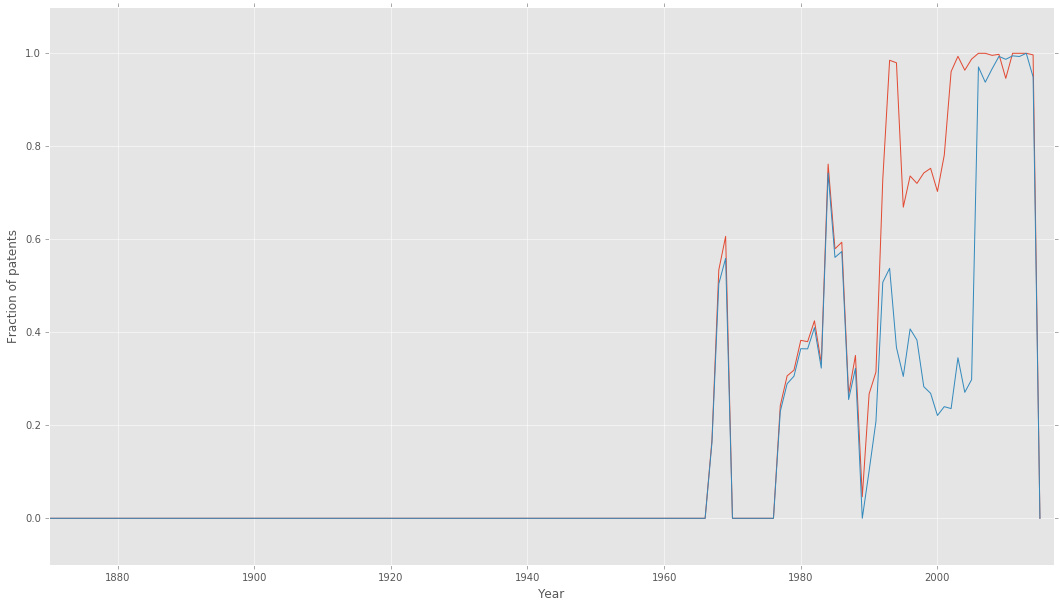

GR


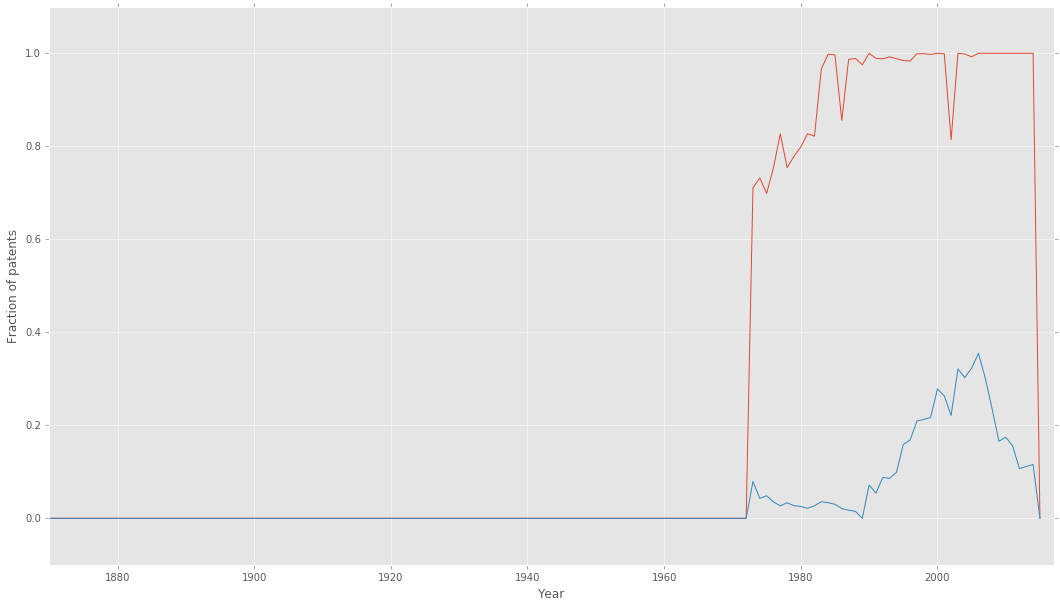

RO


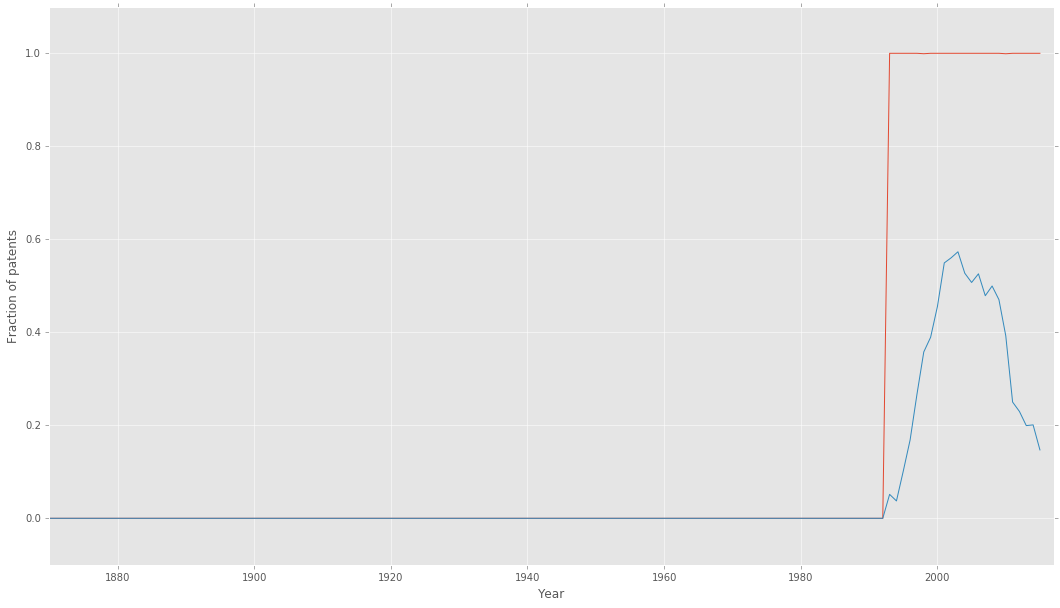

CZ


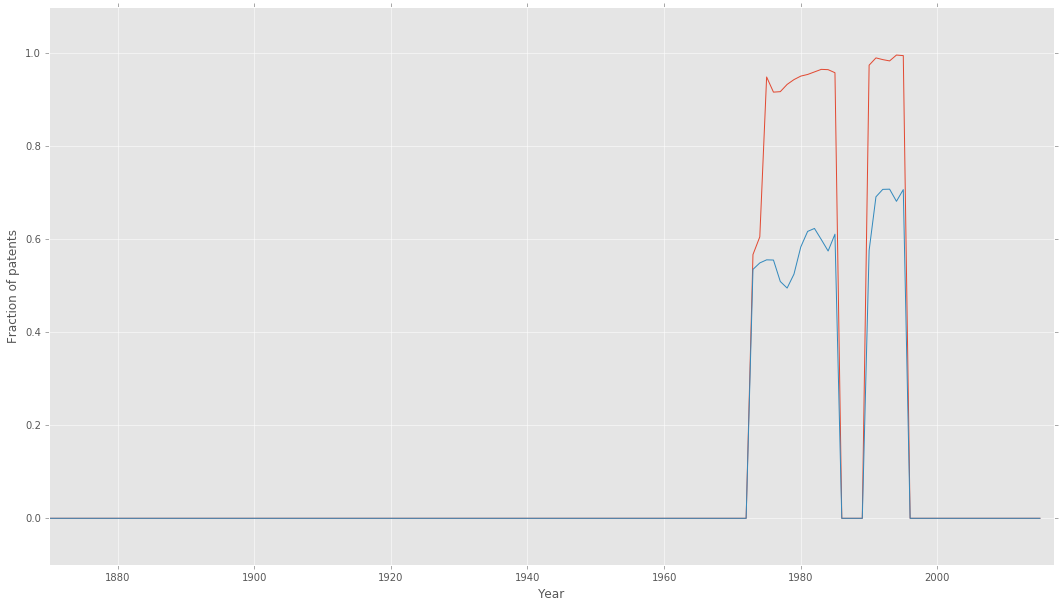

AR


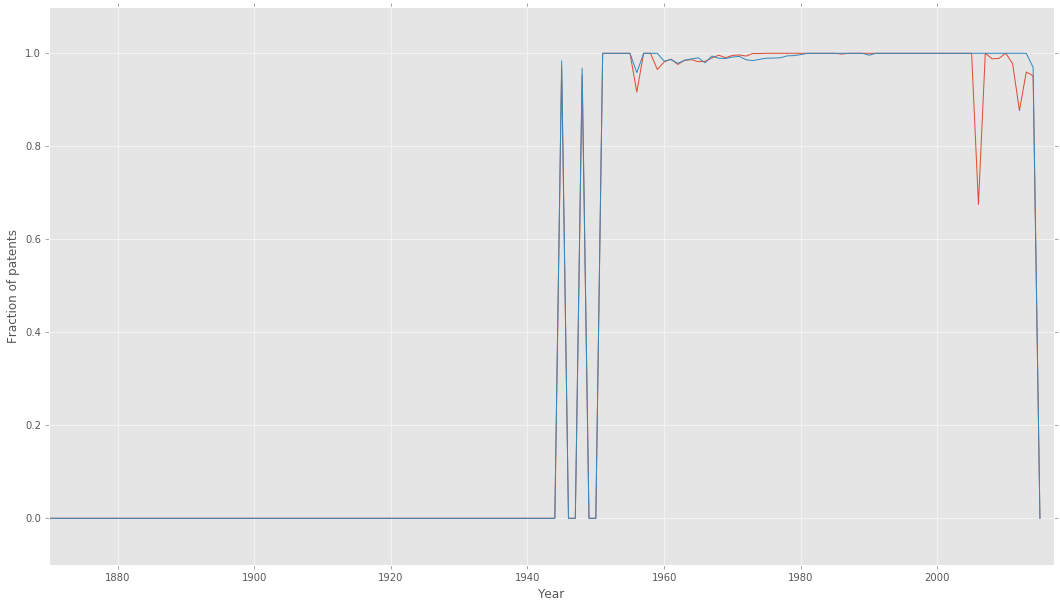

LU


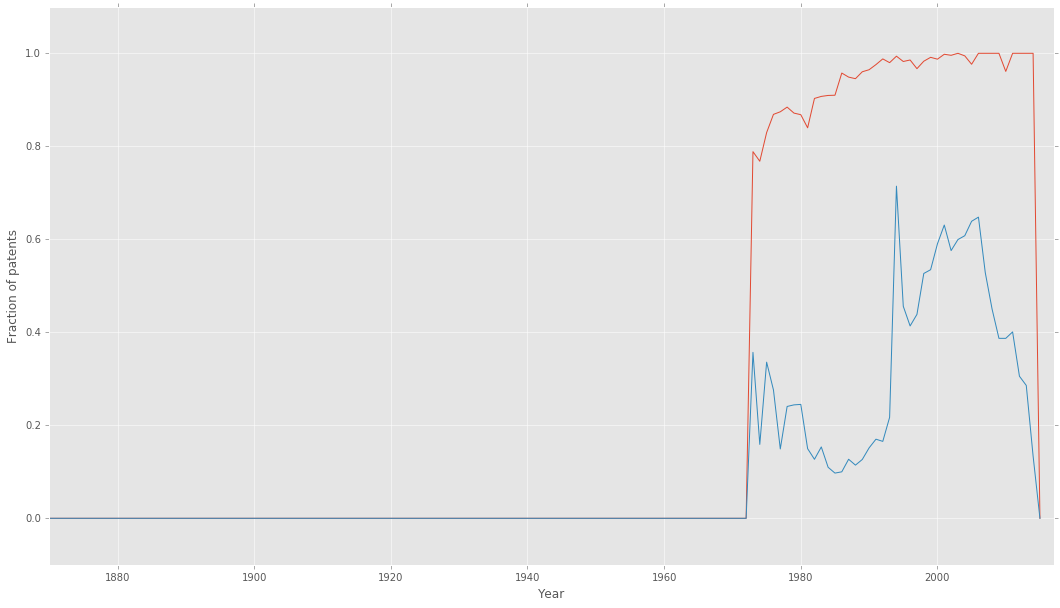

BG


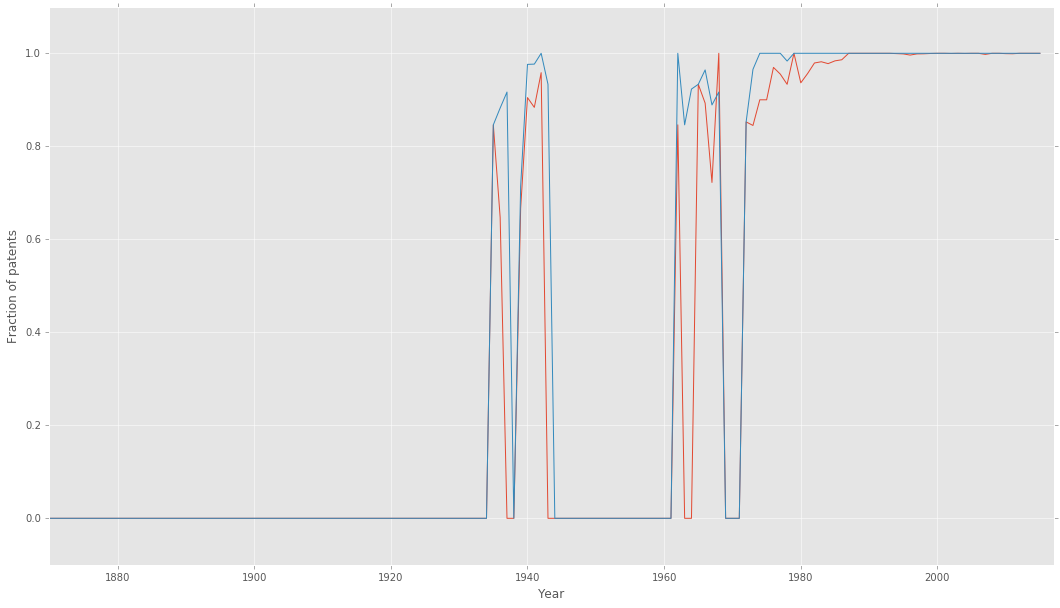

SE


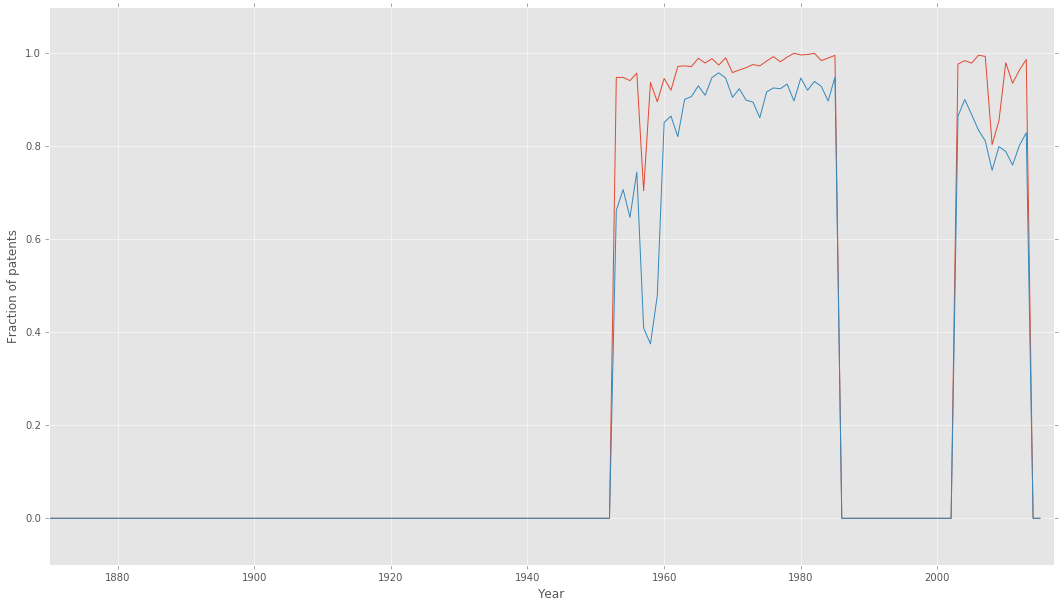

MY


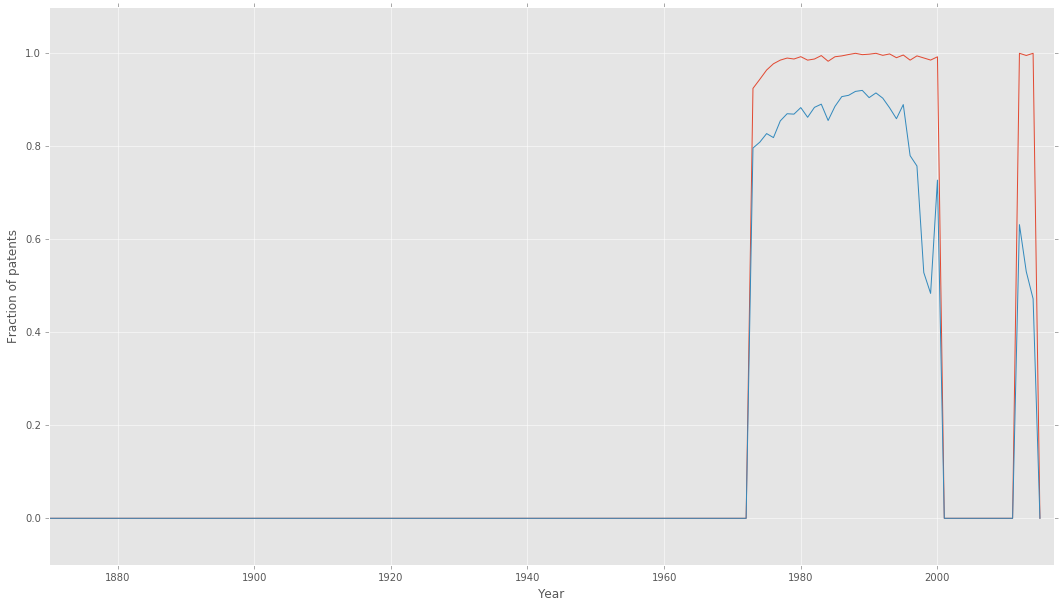

IE


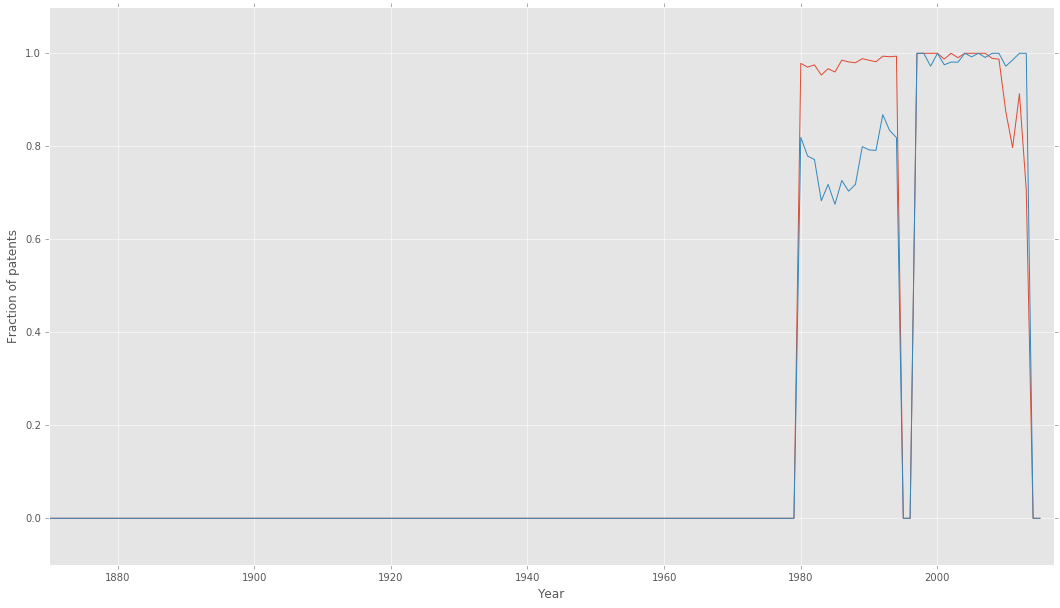

MX


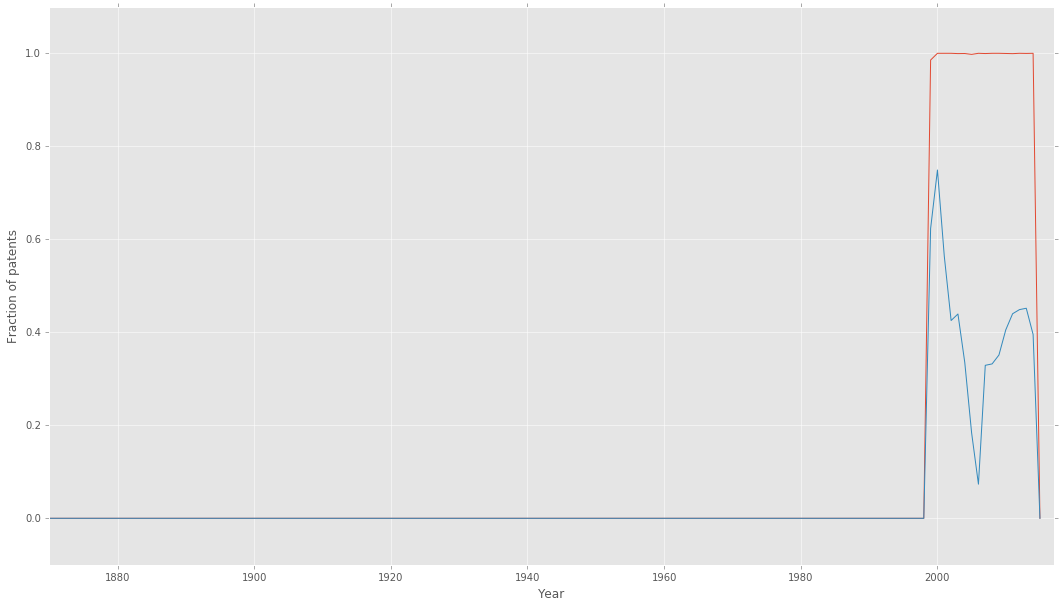

UA


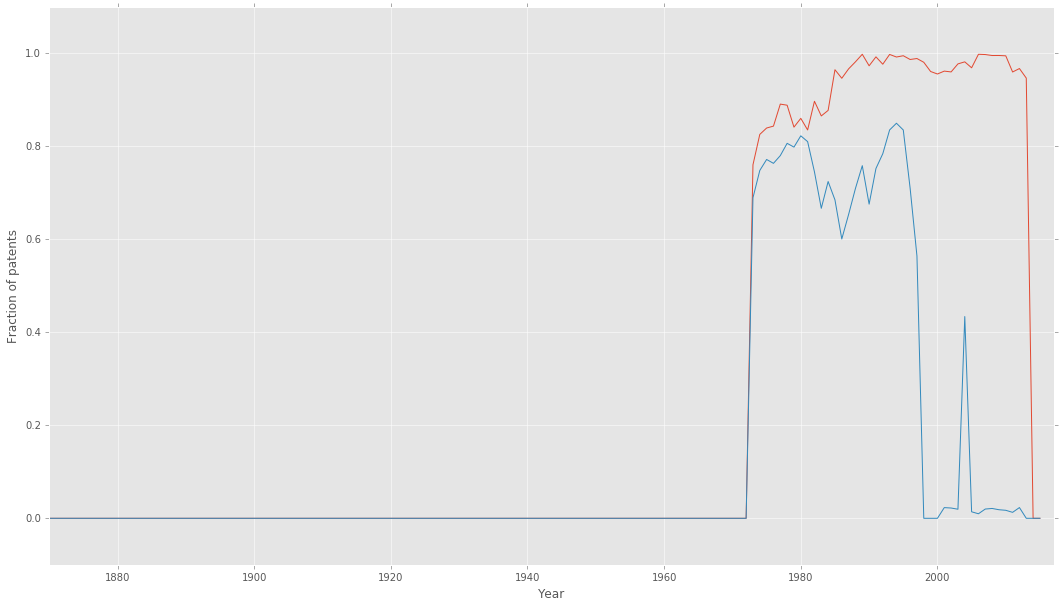

TR


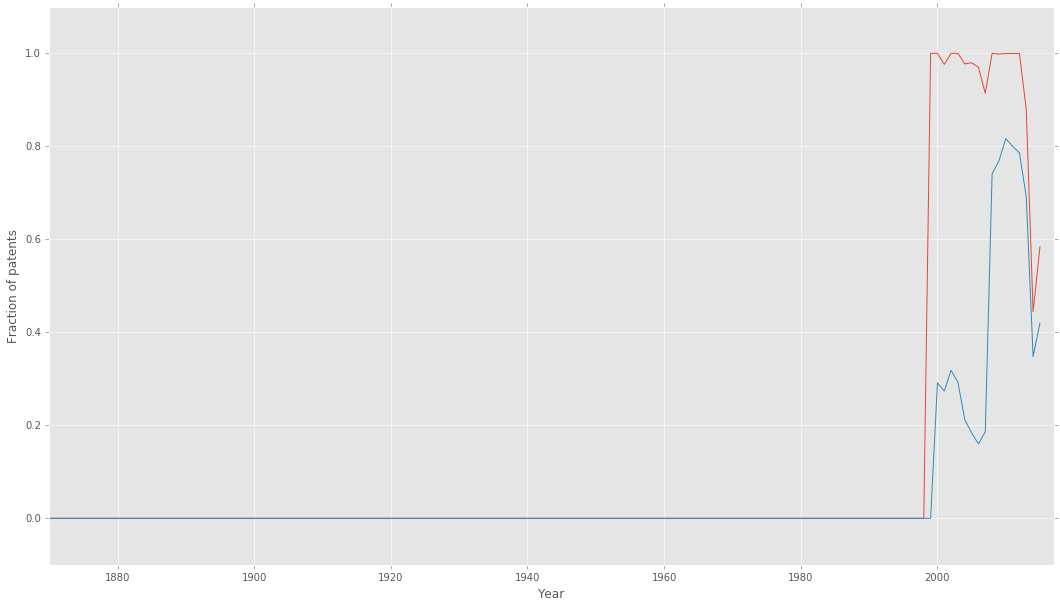

BR


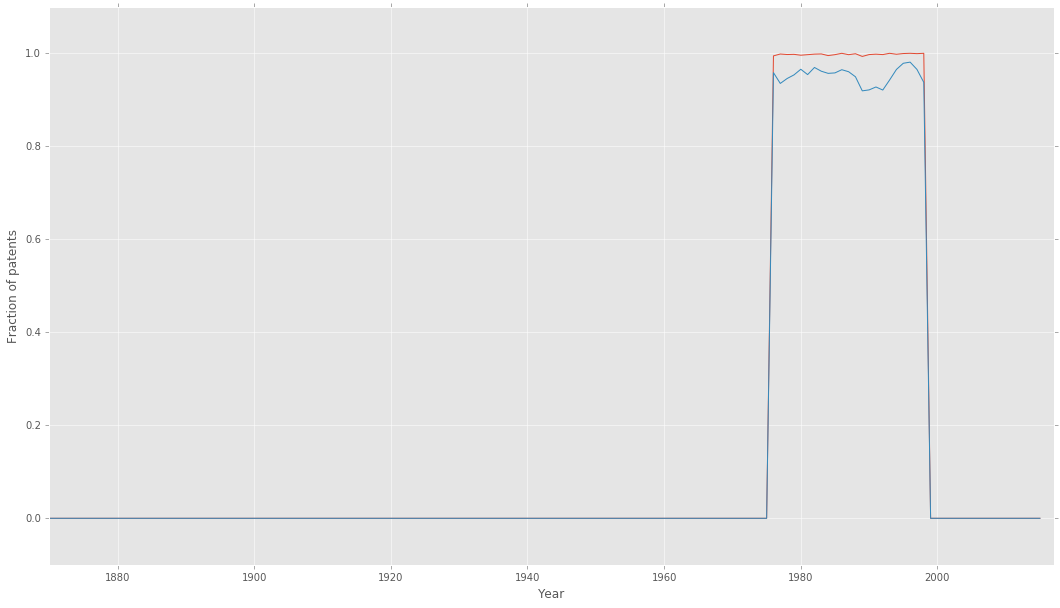

HK


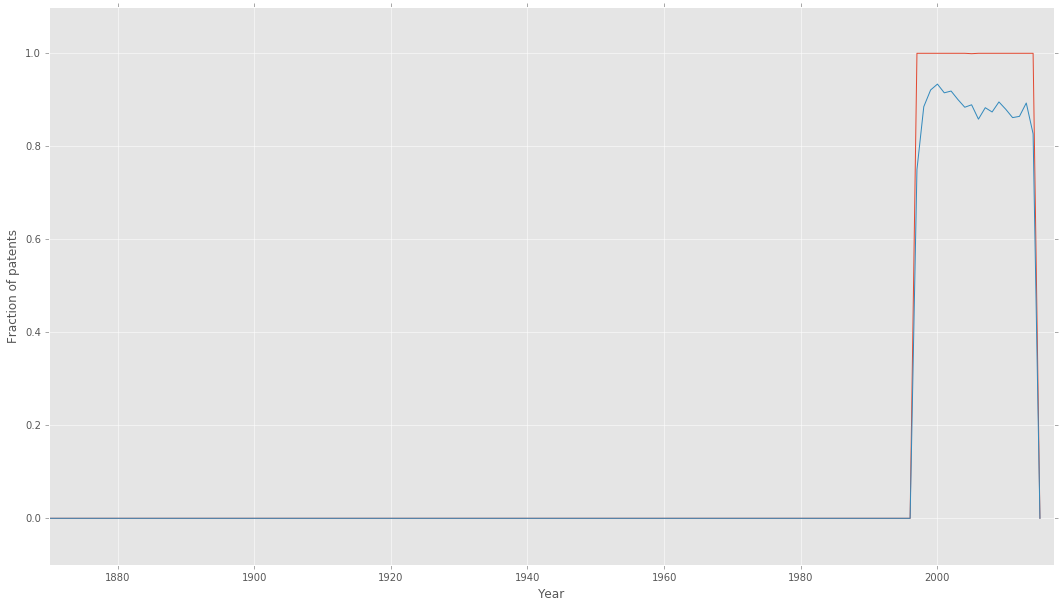

EA


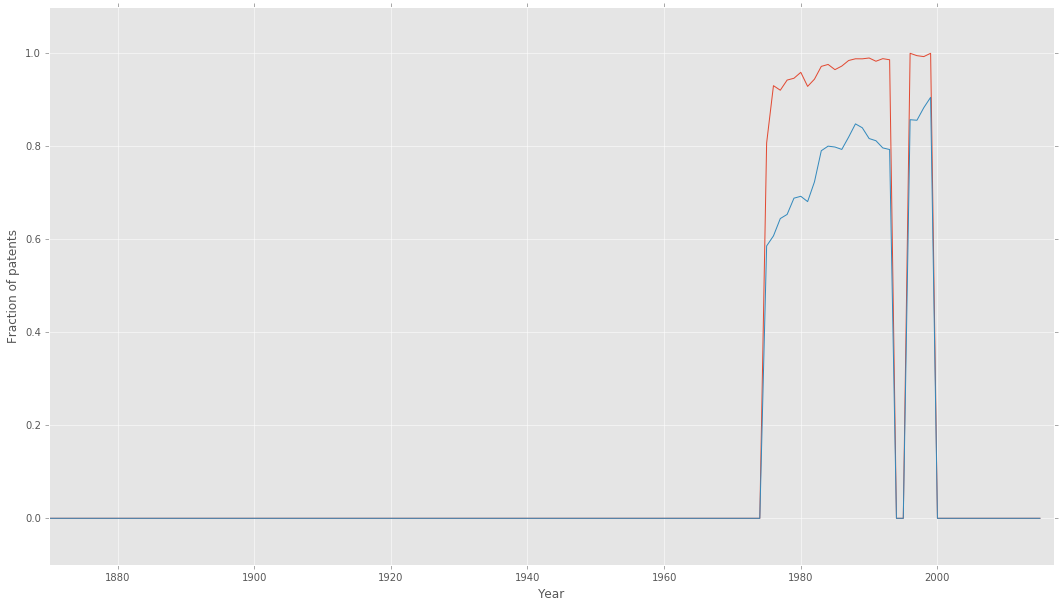

PH


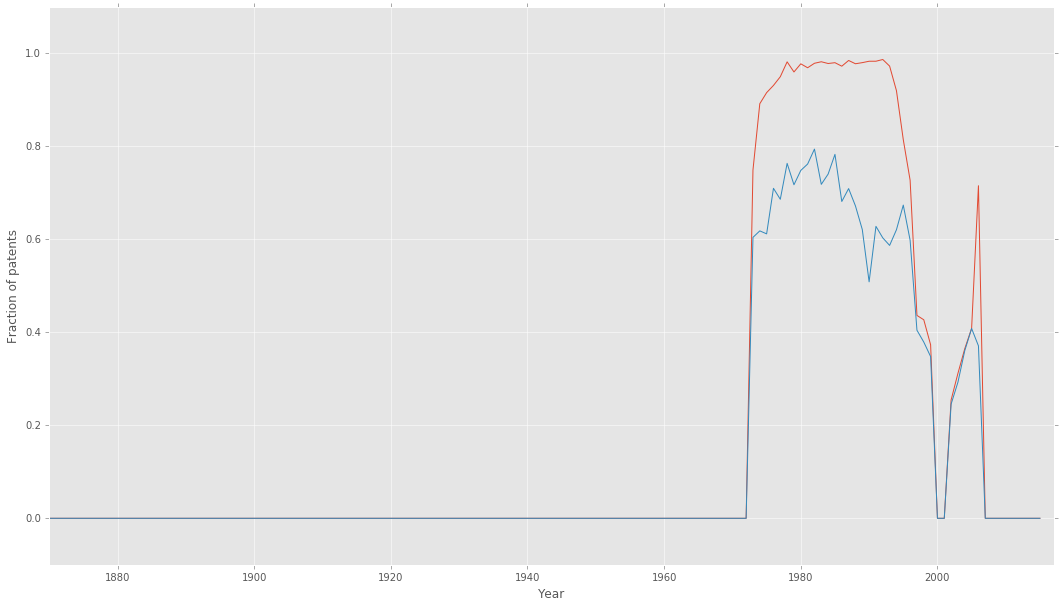

YU


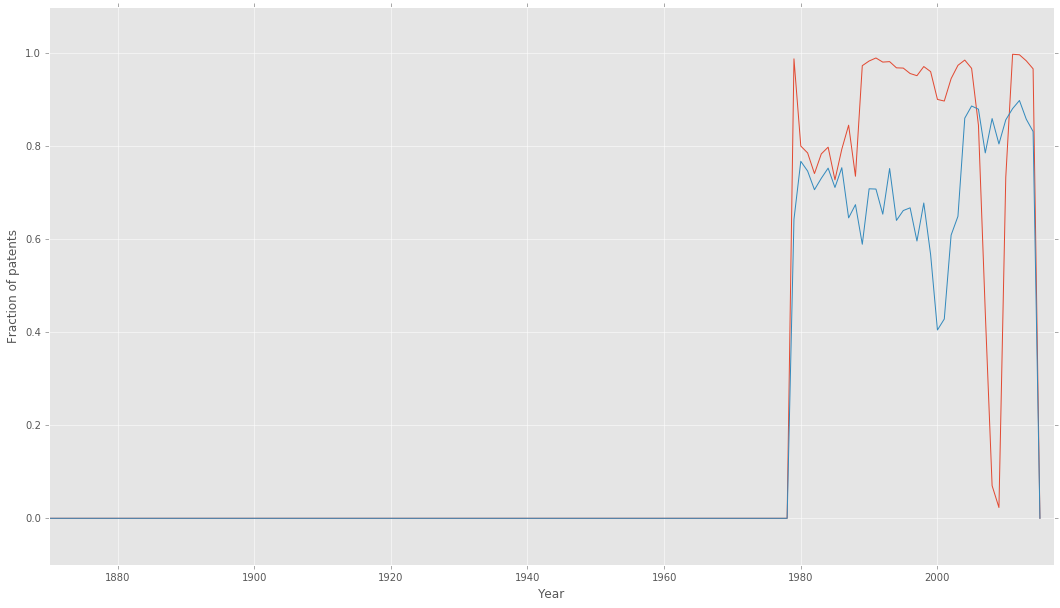

MA


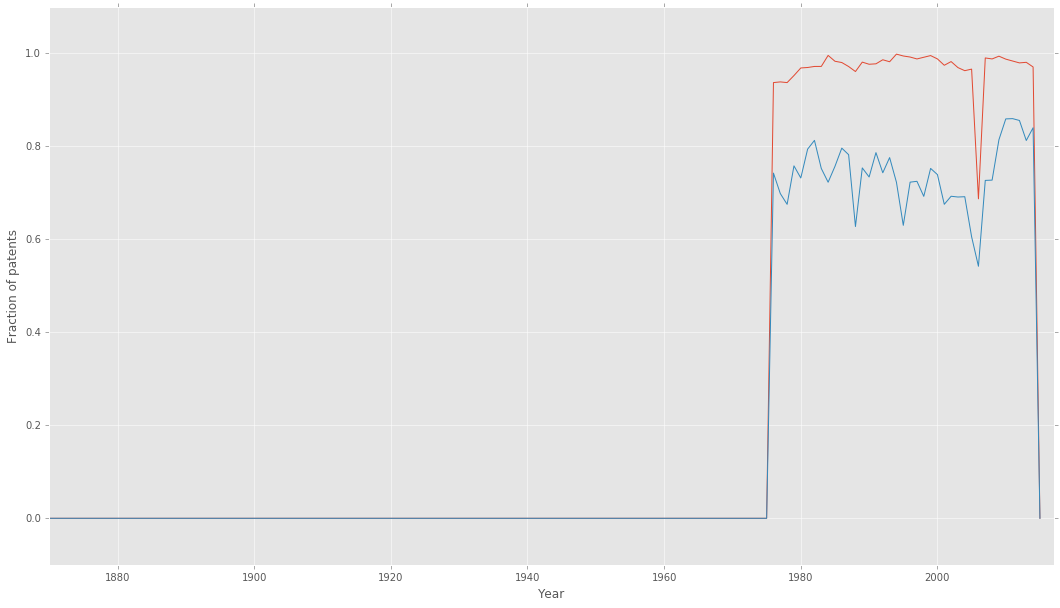

EG


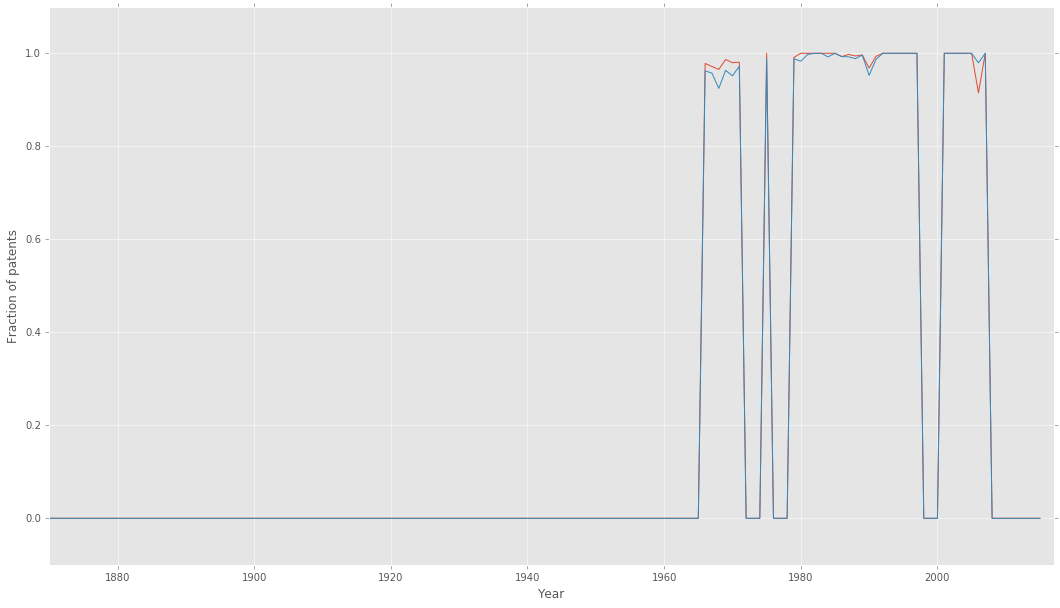

OA


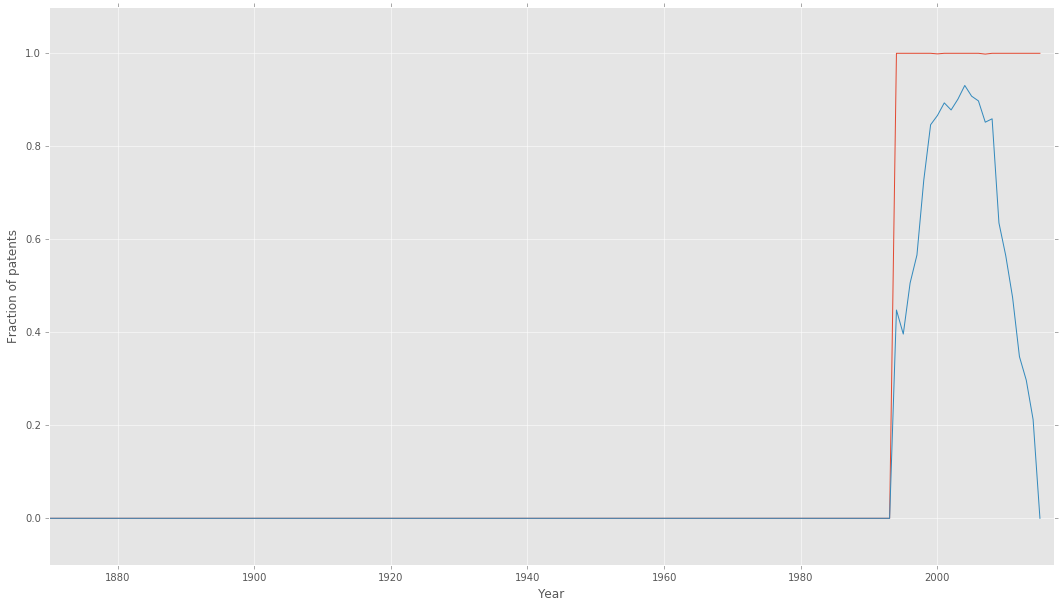

SK


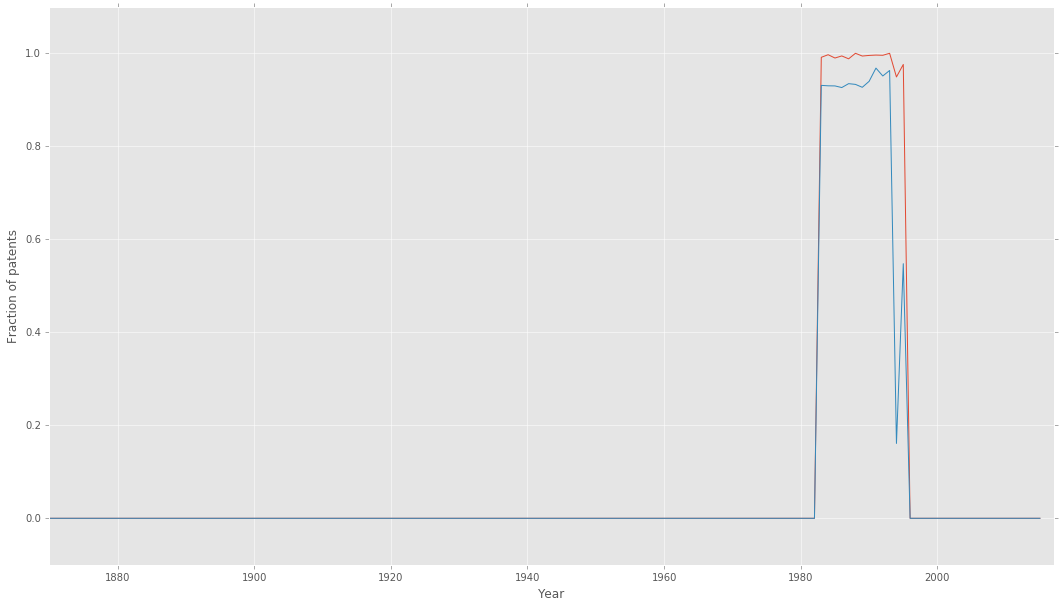

SG


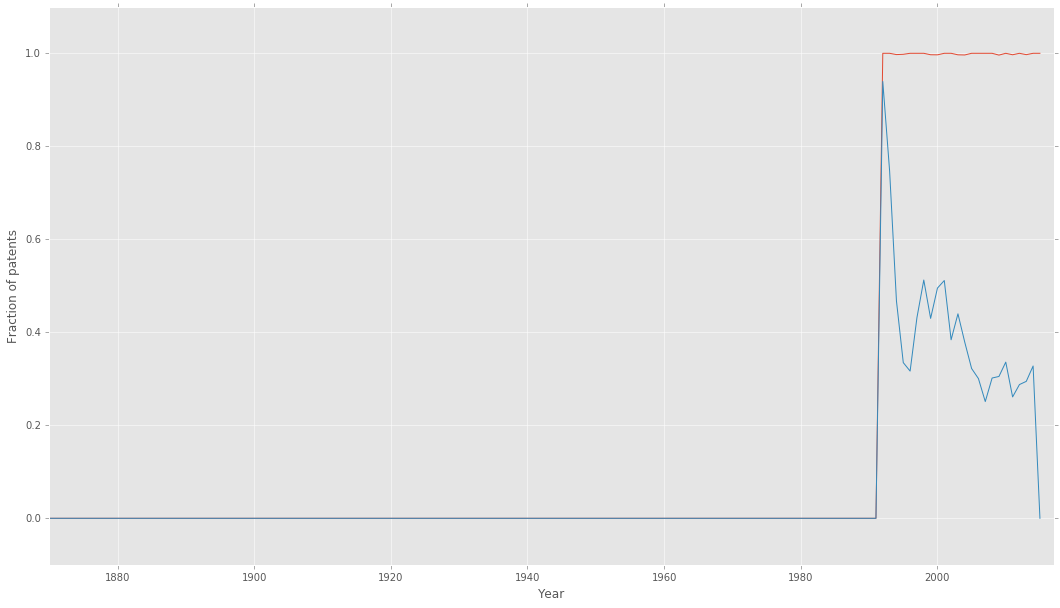

SI


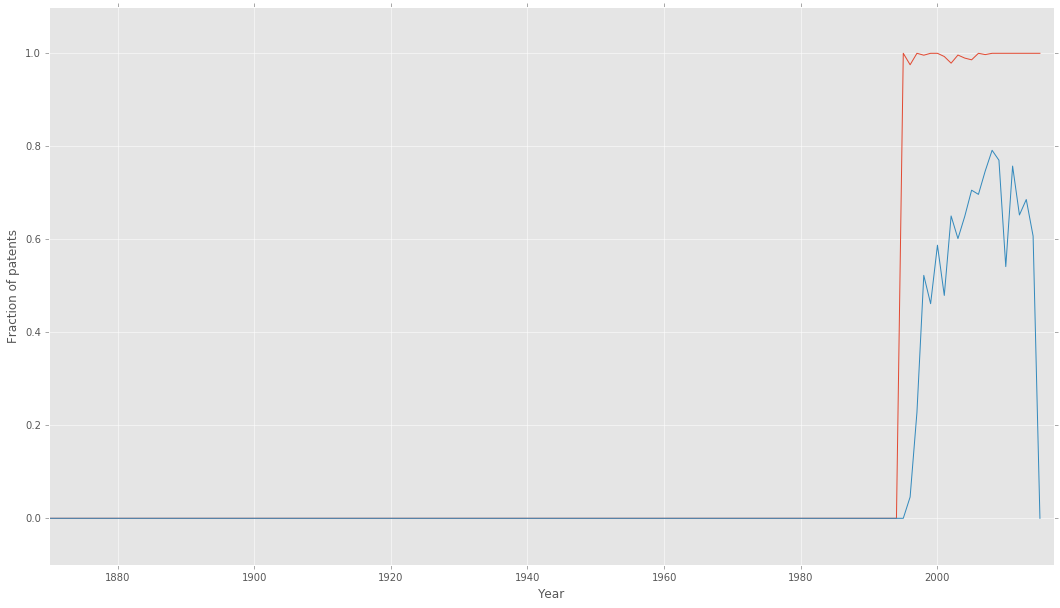

HR


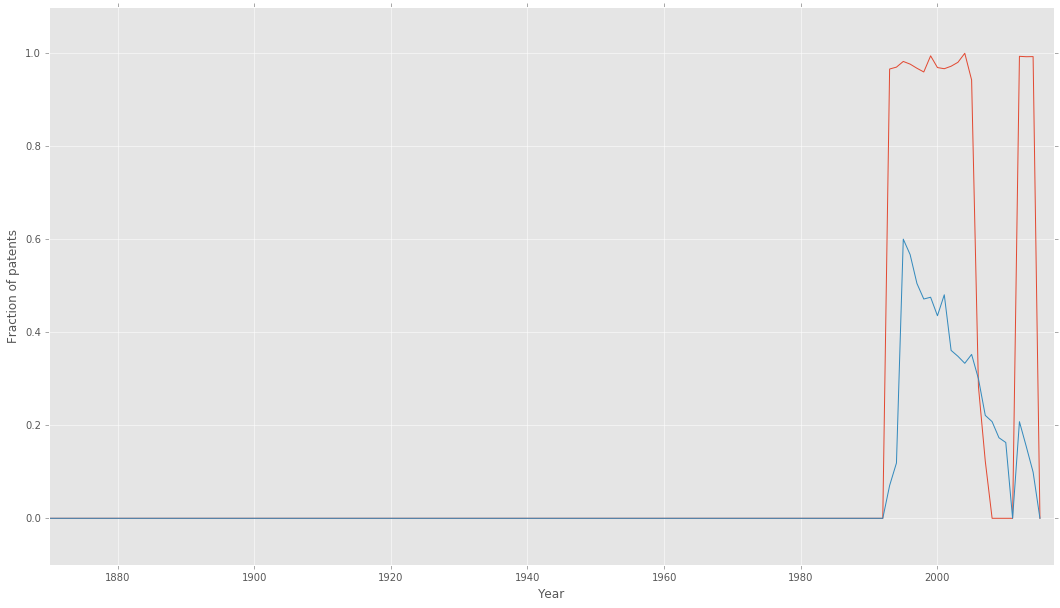

LV


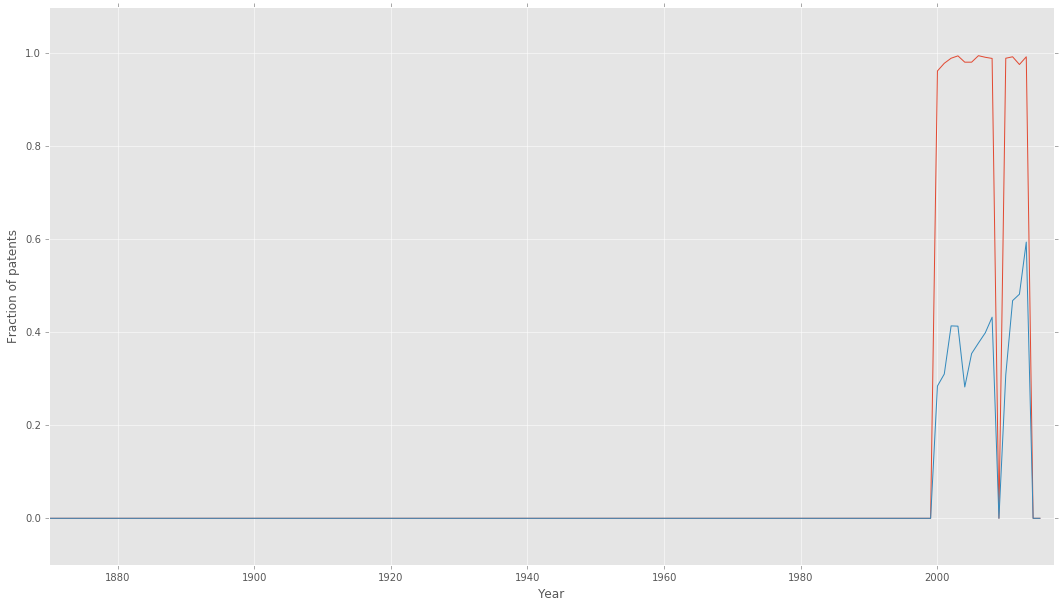

GE


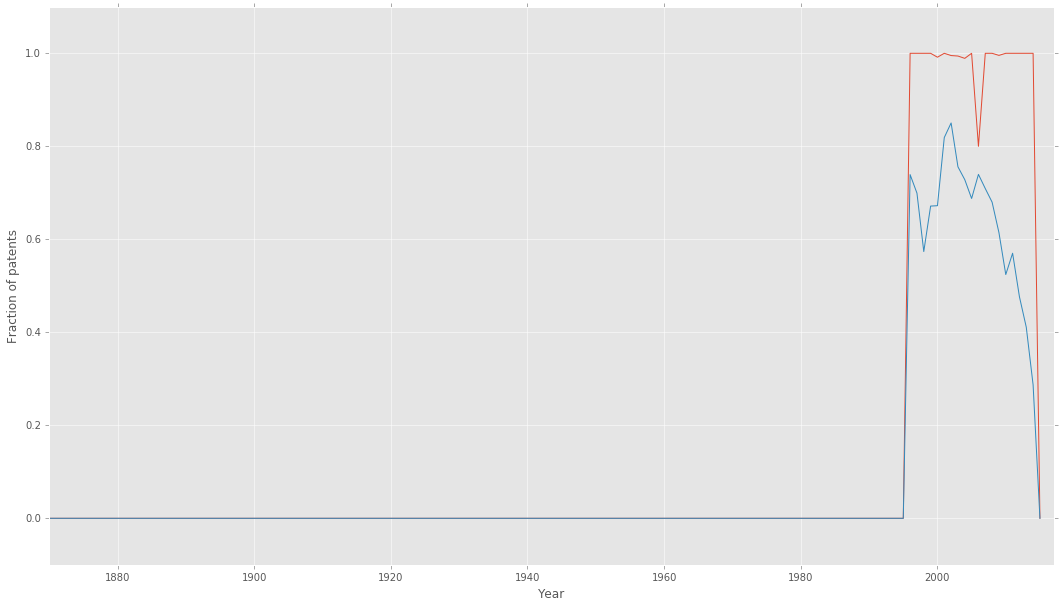

EE


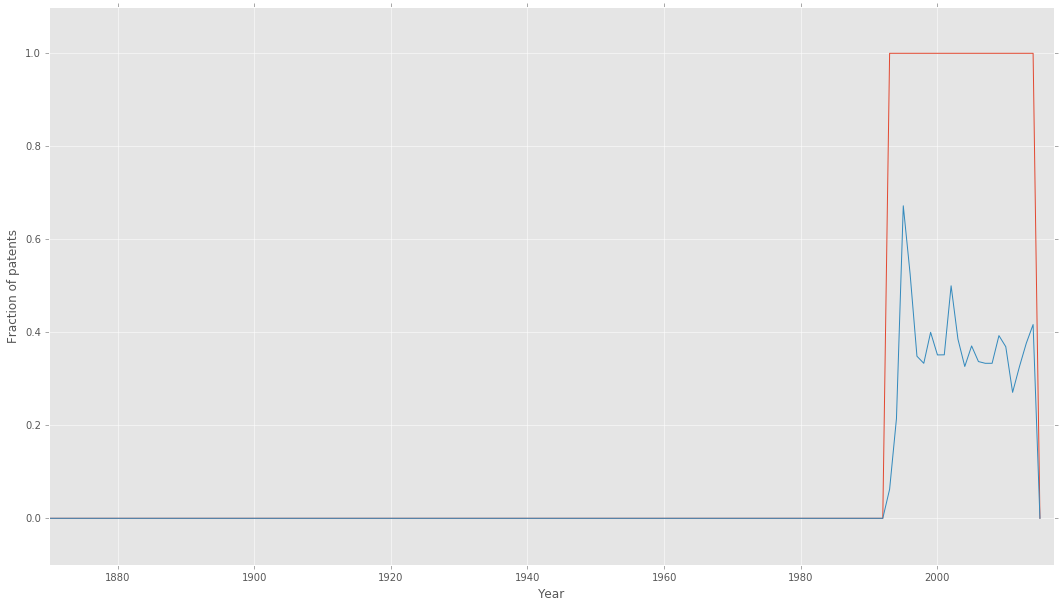

LT


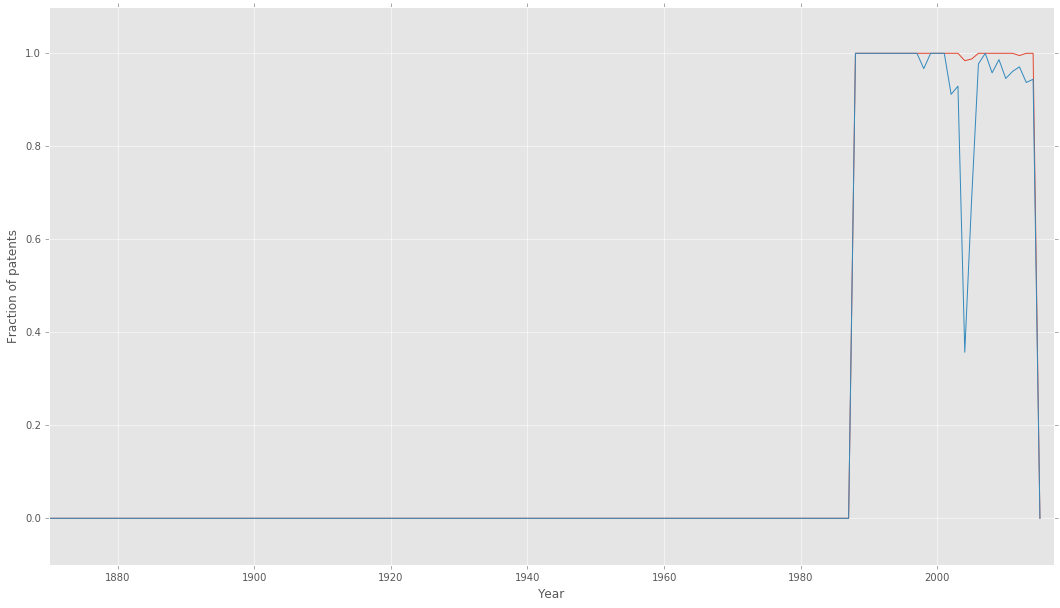

AP


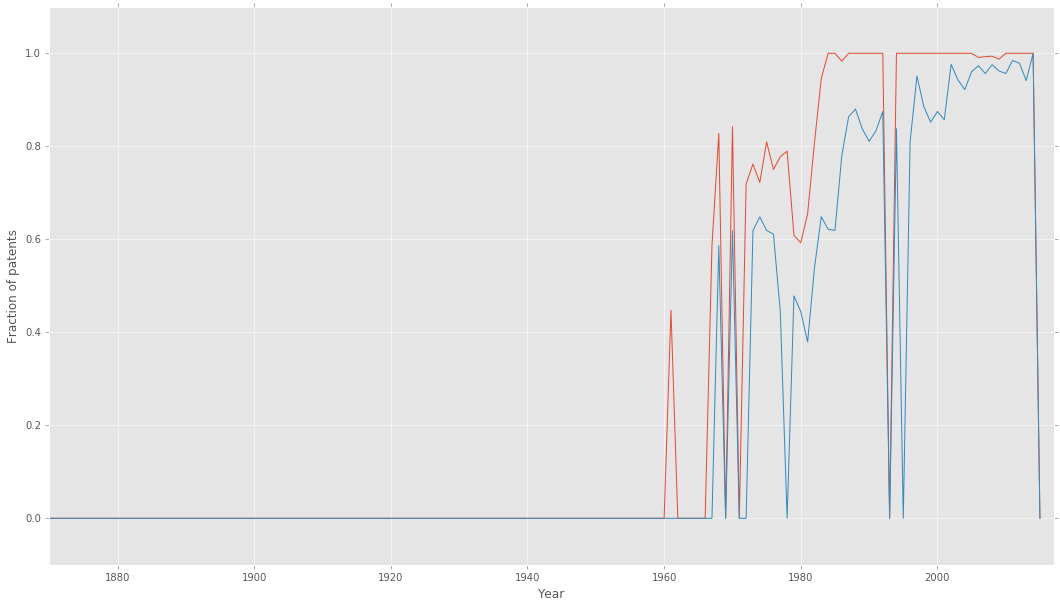

IS


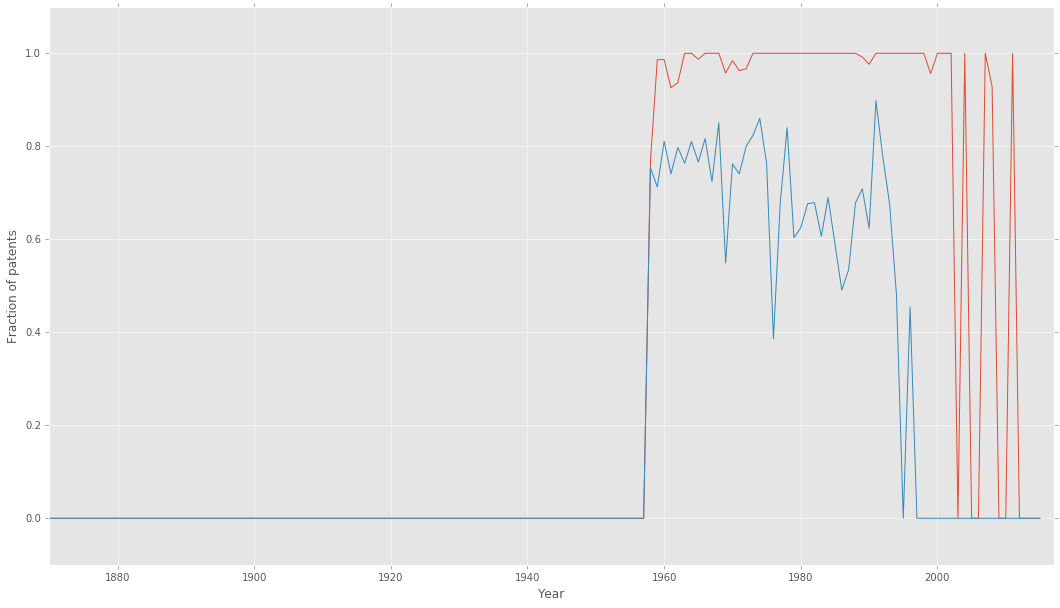

MC


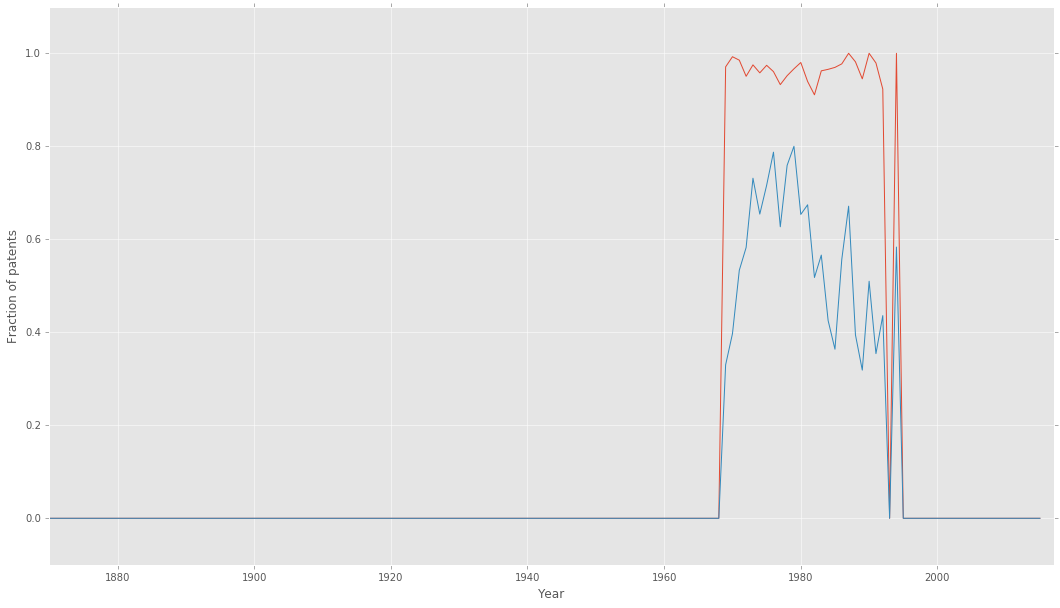

ZM


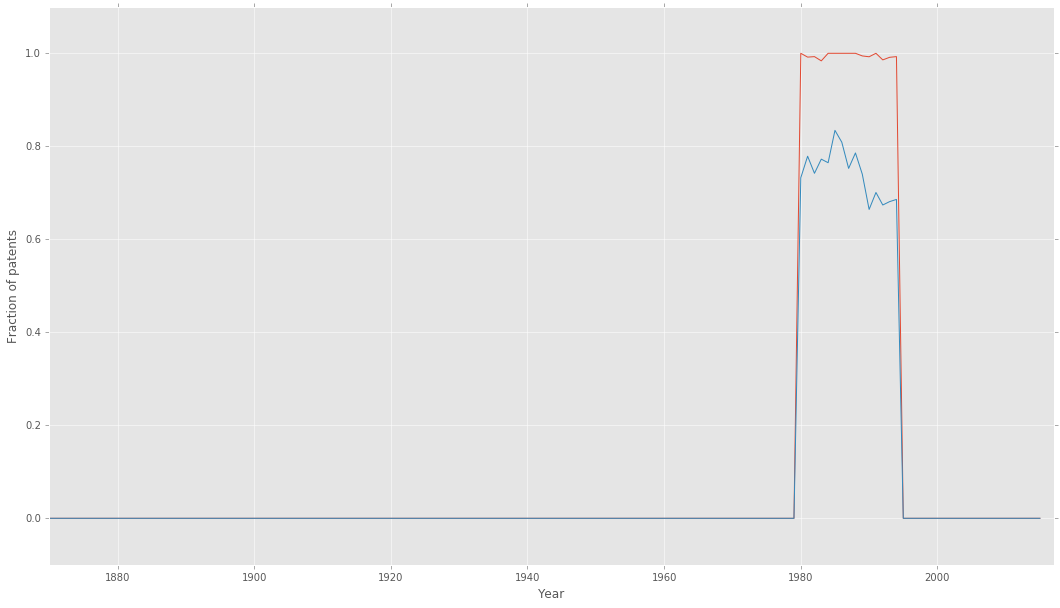

ZW


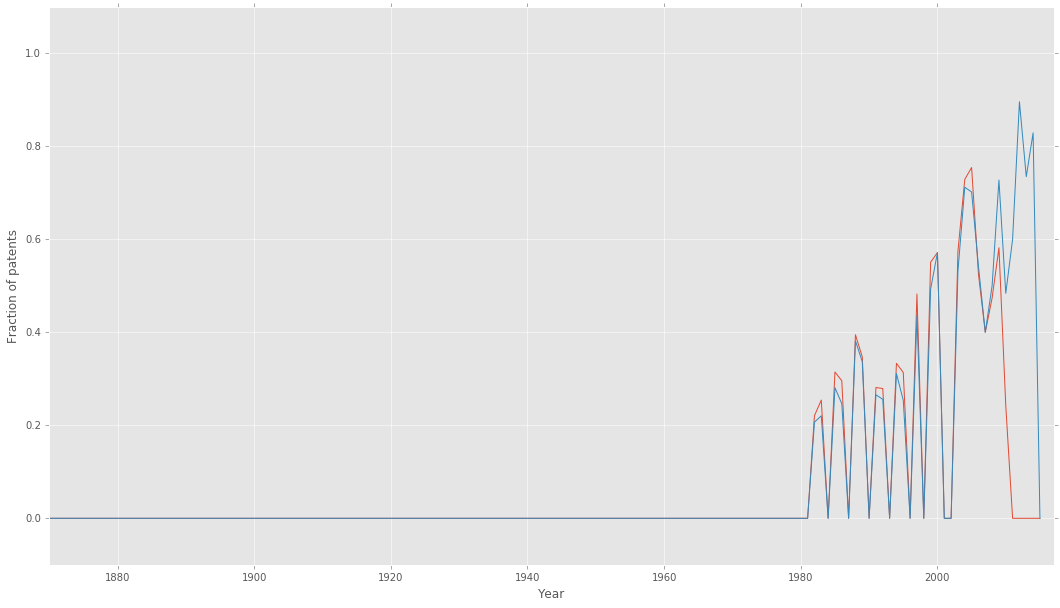

JO


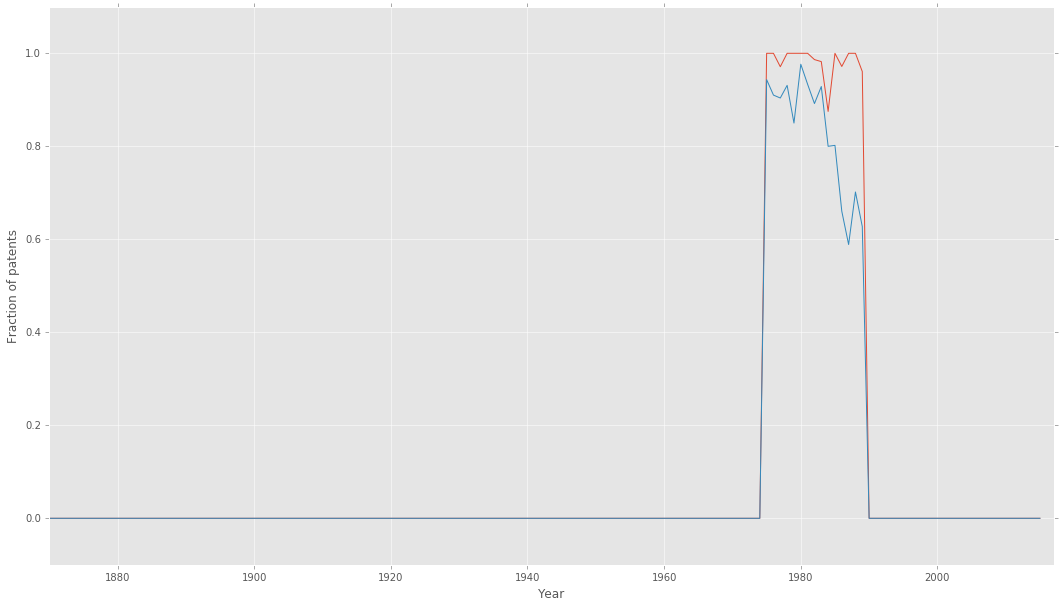

KE


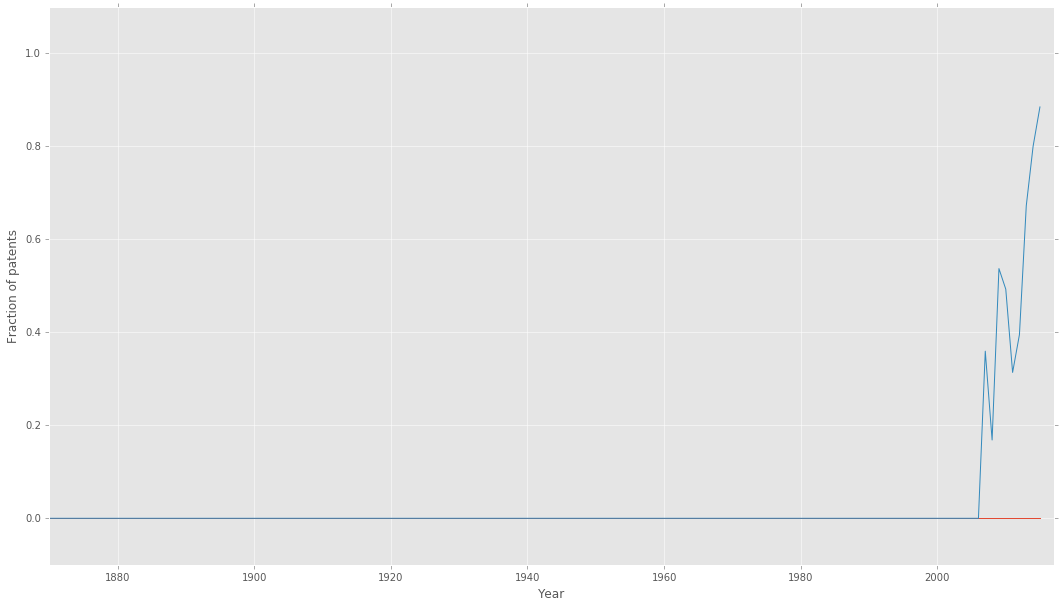

SM


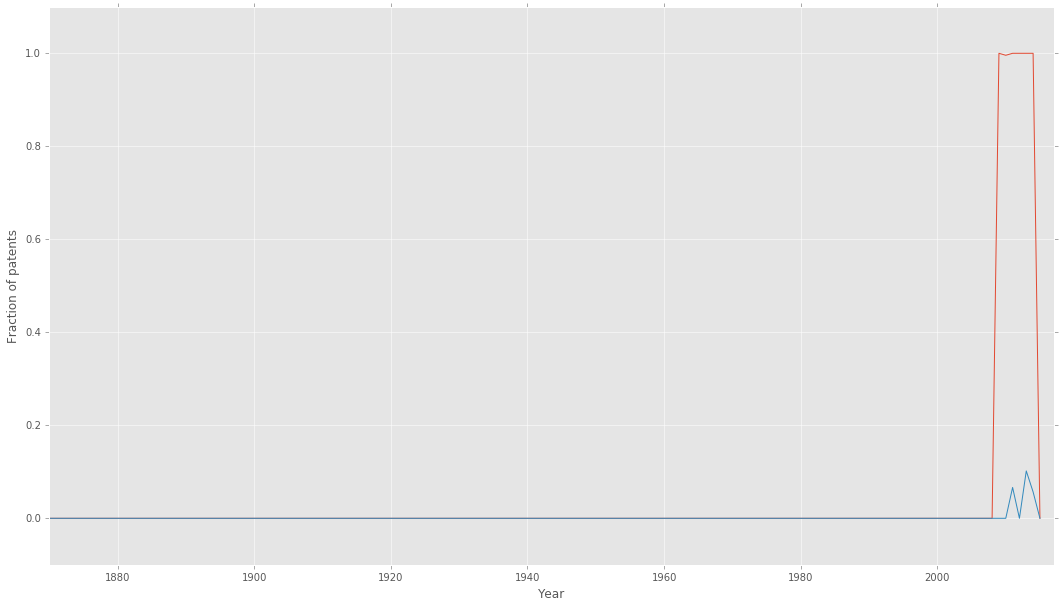

MD


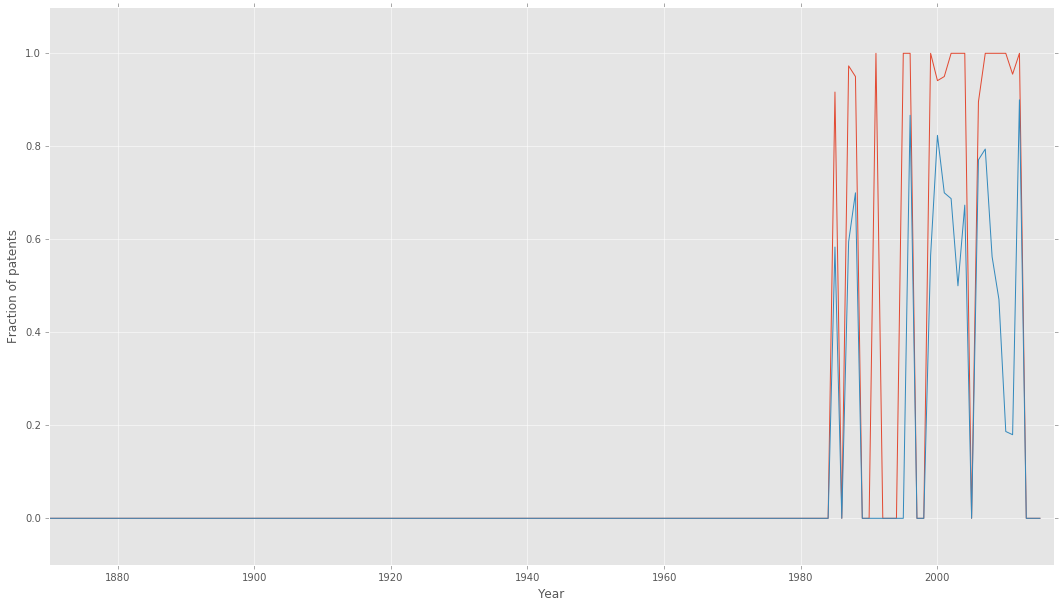

CU


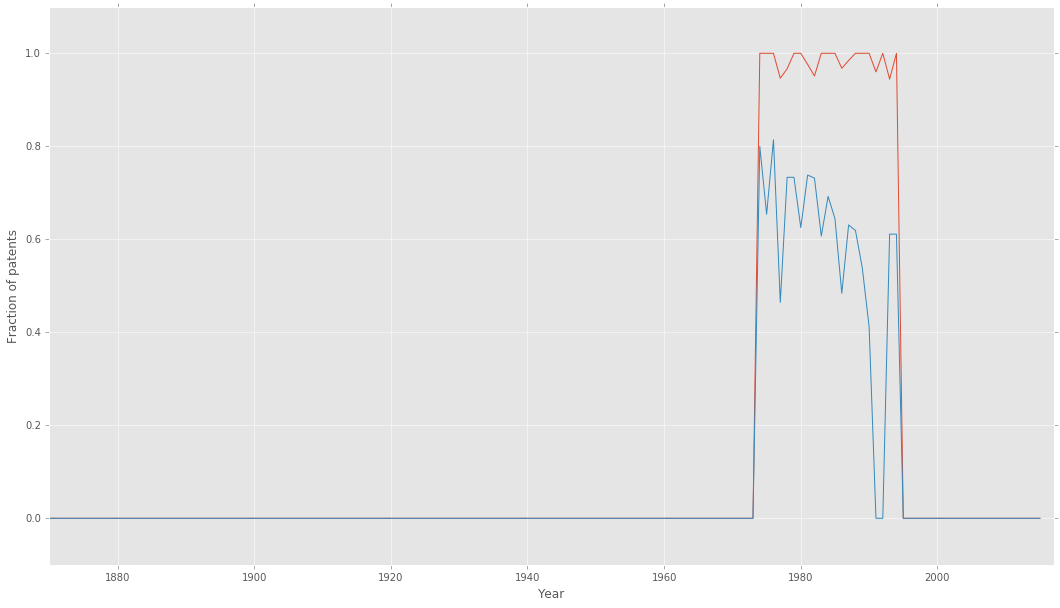

MW


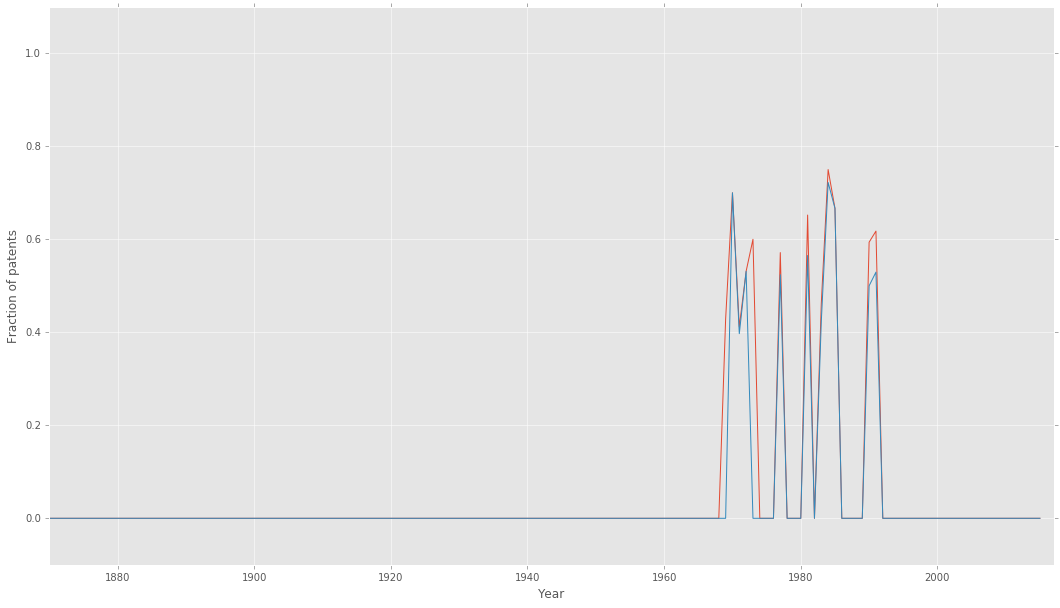

MT


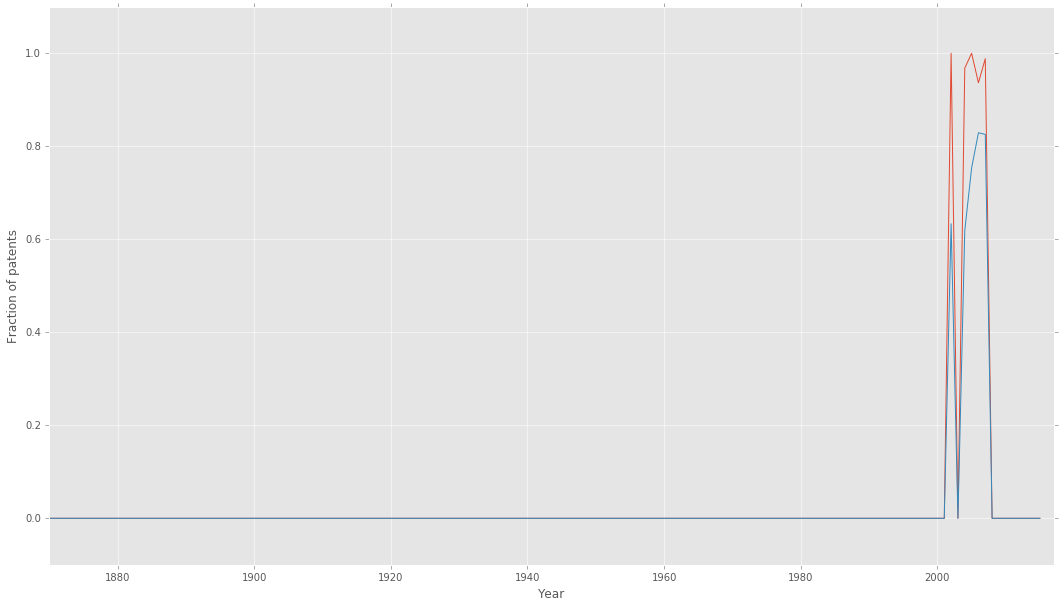

GC


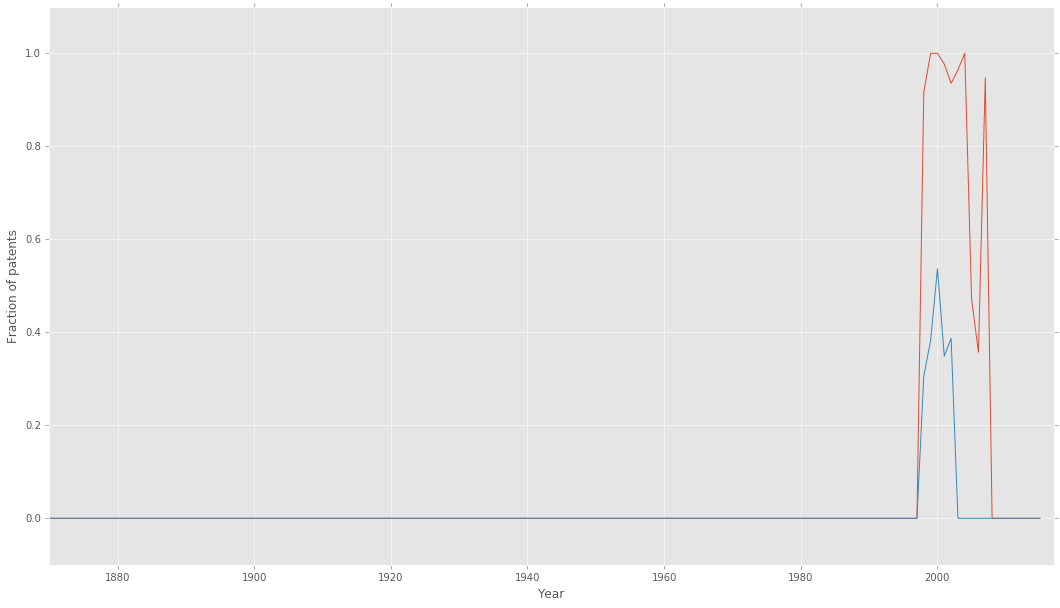

TJ


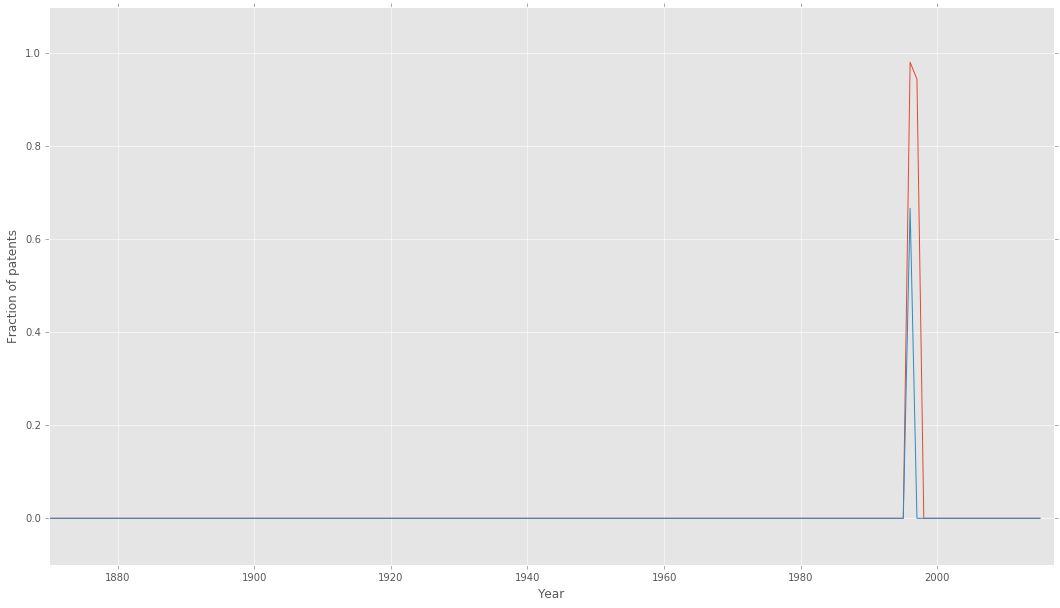

ID


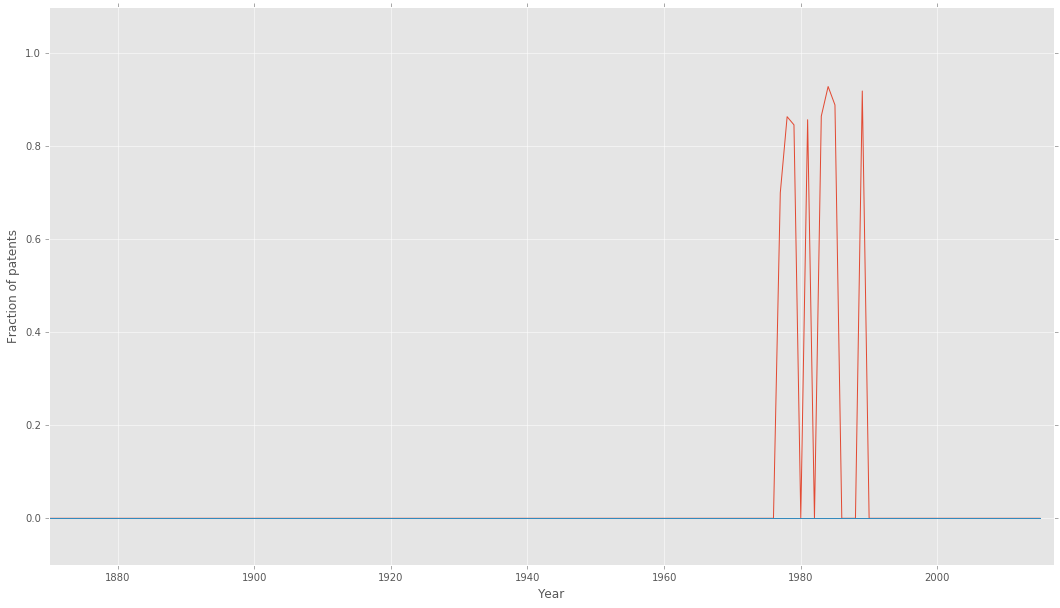

MN


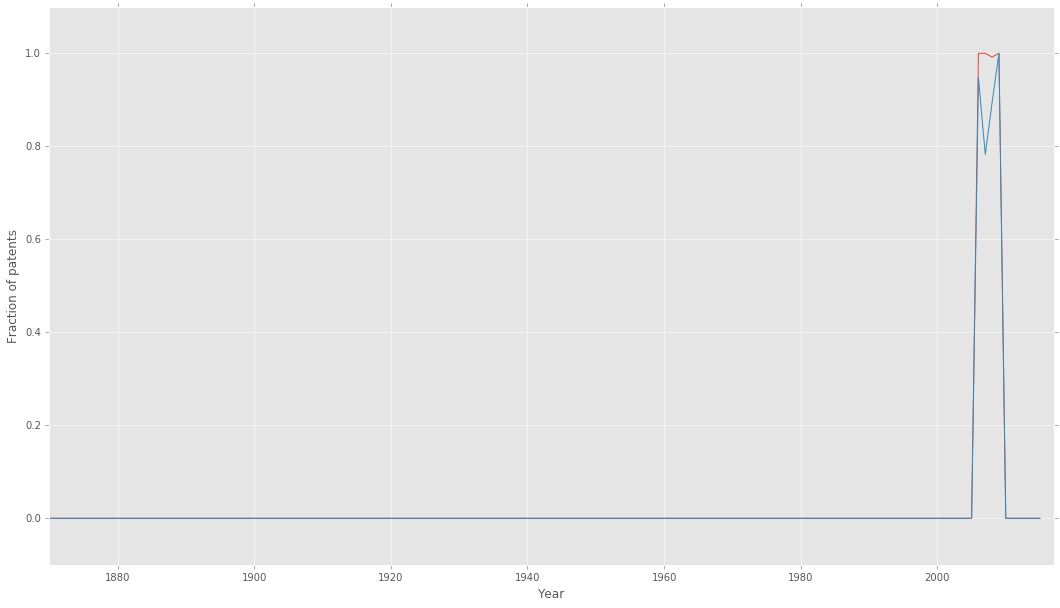

NI


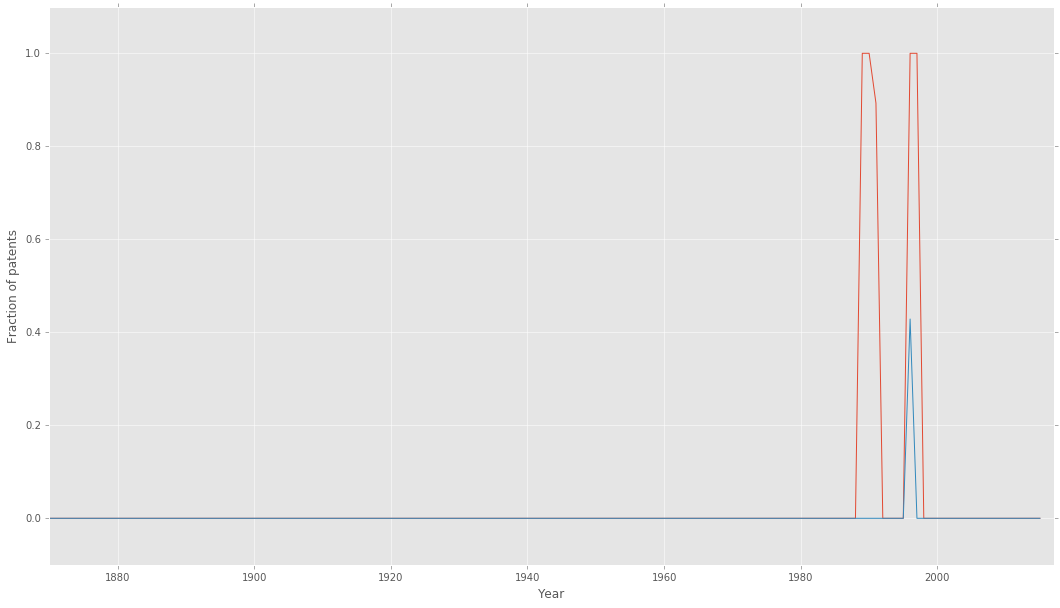

VN


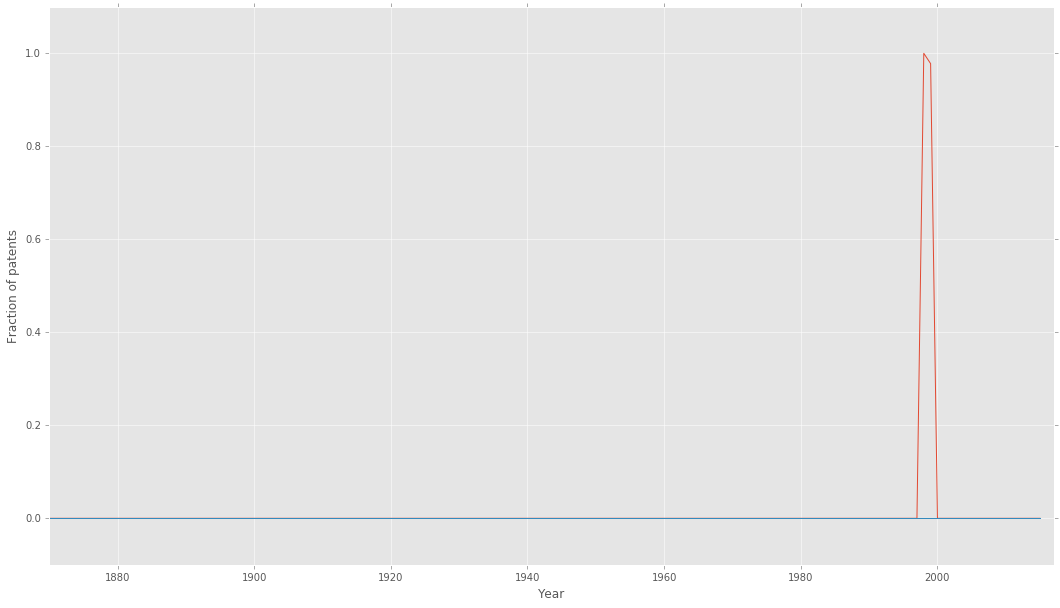

BA


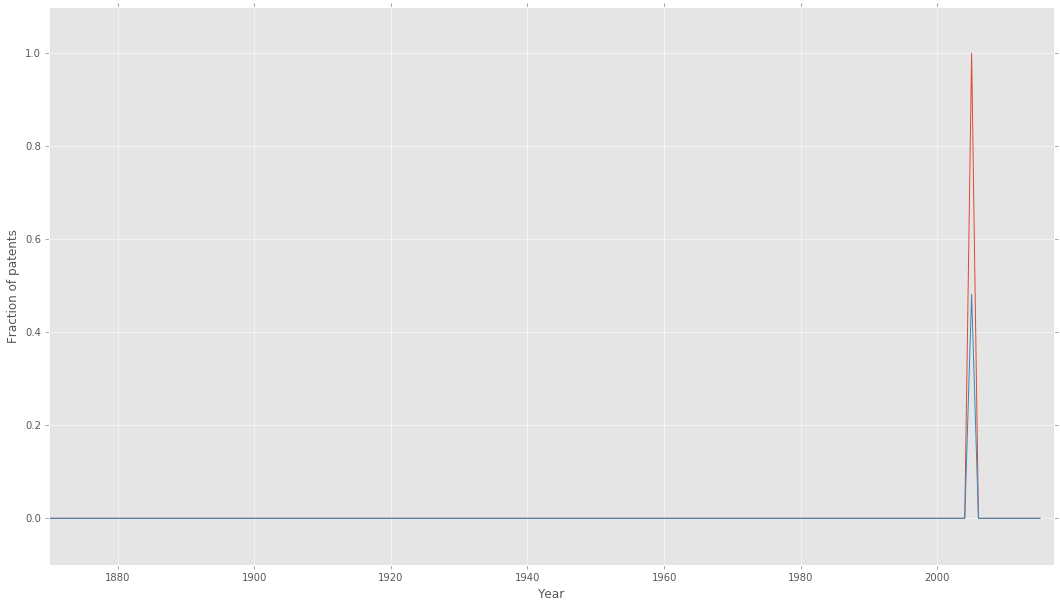

CL


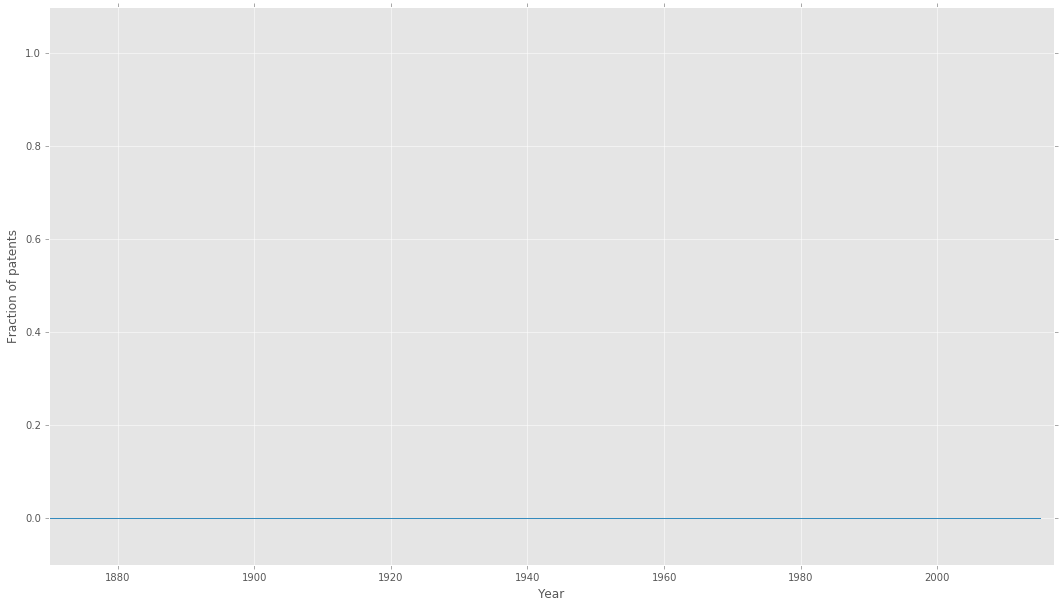

BY


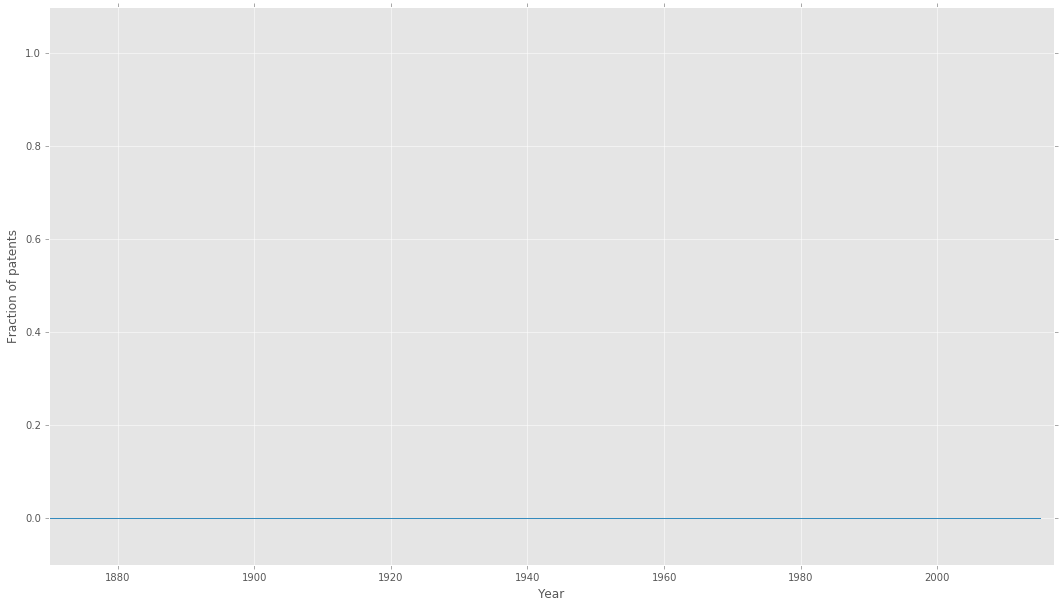

IL


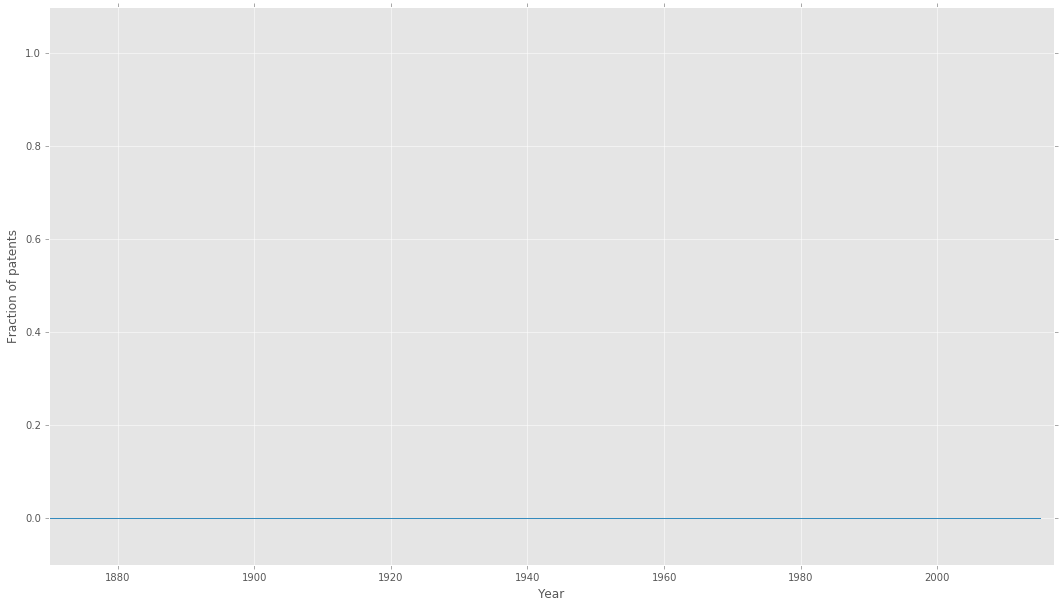

GA


In [72]:
# For ALL indivudually

for auth in auth_by_size:
    df_au_year_frac_10_pv.frac_ipc[auth].plot(figsize=(18,10), label='ipc') # RED
    df_au_year_frac_10_pv.frac_cpc[auth].plot(figsize=(18,10)) # BLUE
    plt.xlim(1870,yr_min_max_plt[1])
    plt.ylim(-0.1, 1.1)

    plt.xlabel("Year")
    plt.ylabel('Fraction of patents')
    plt.show()

    print auth

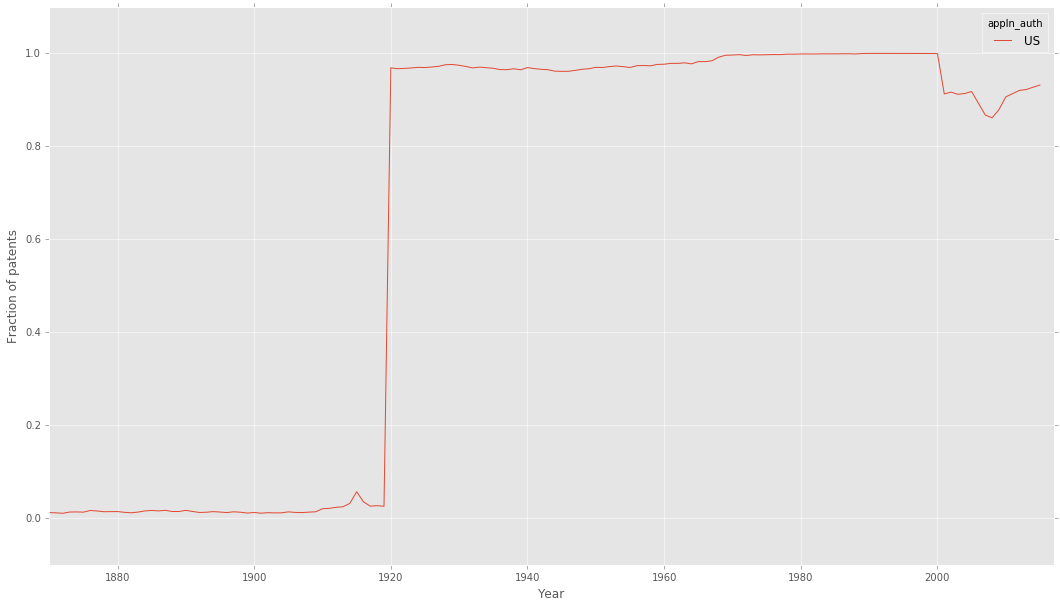

In [73]:
# For top 10

df_au_year_frac_pv.frac_ipc[auth_by_size[0:1]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

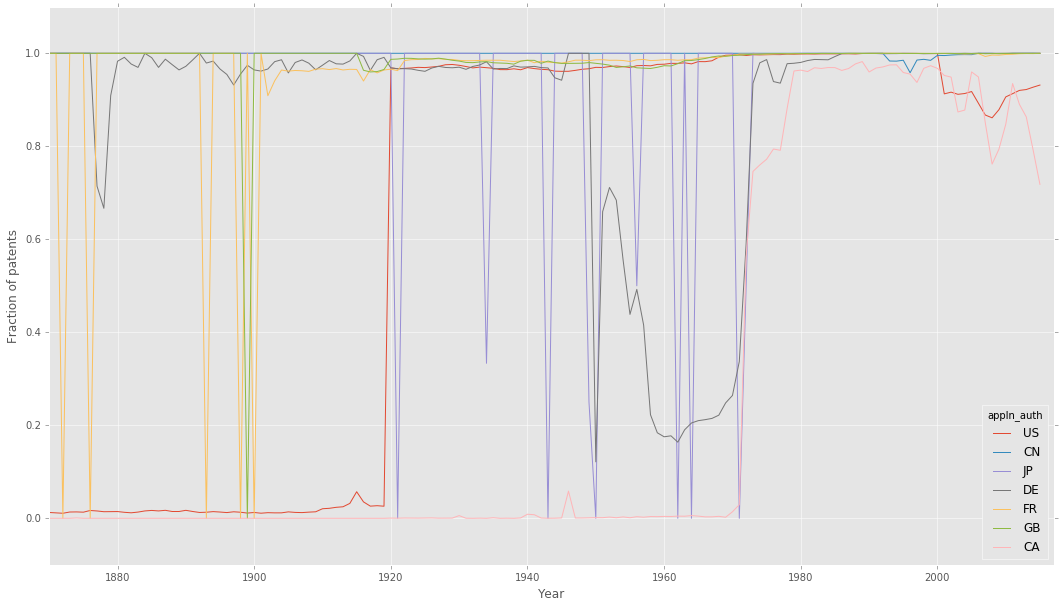

In [74]:
# For top 6 Auths

df_au_year_frac_pv.frac_ipc[auth_by_size[0:7]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

## Checking CPC Classfications By Auth
[to top](#Table-of-Contents)

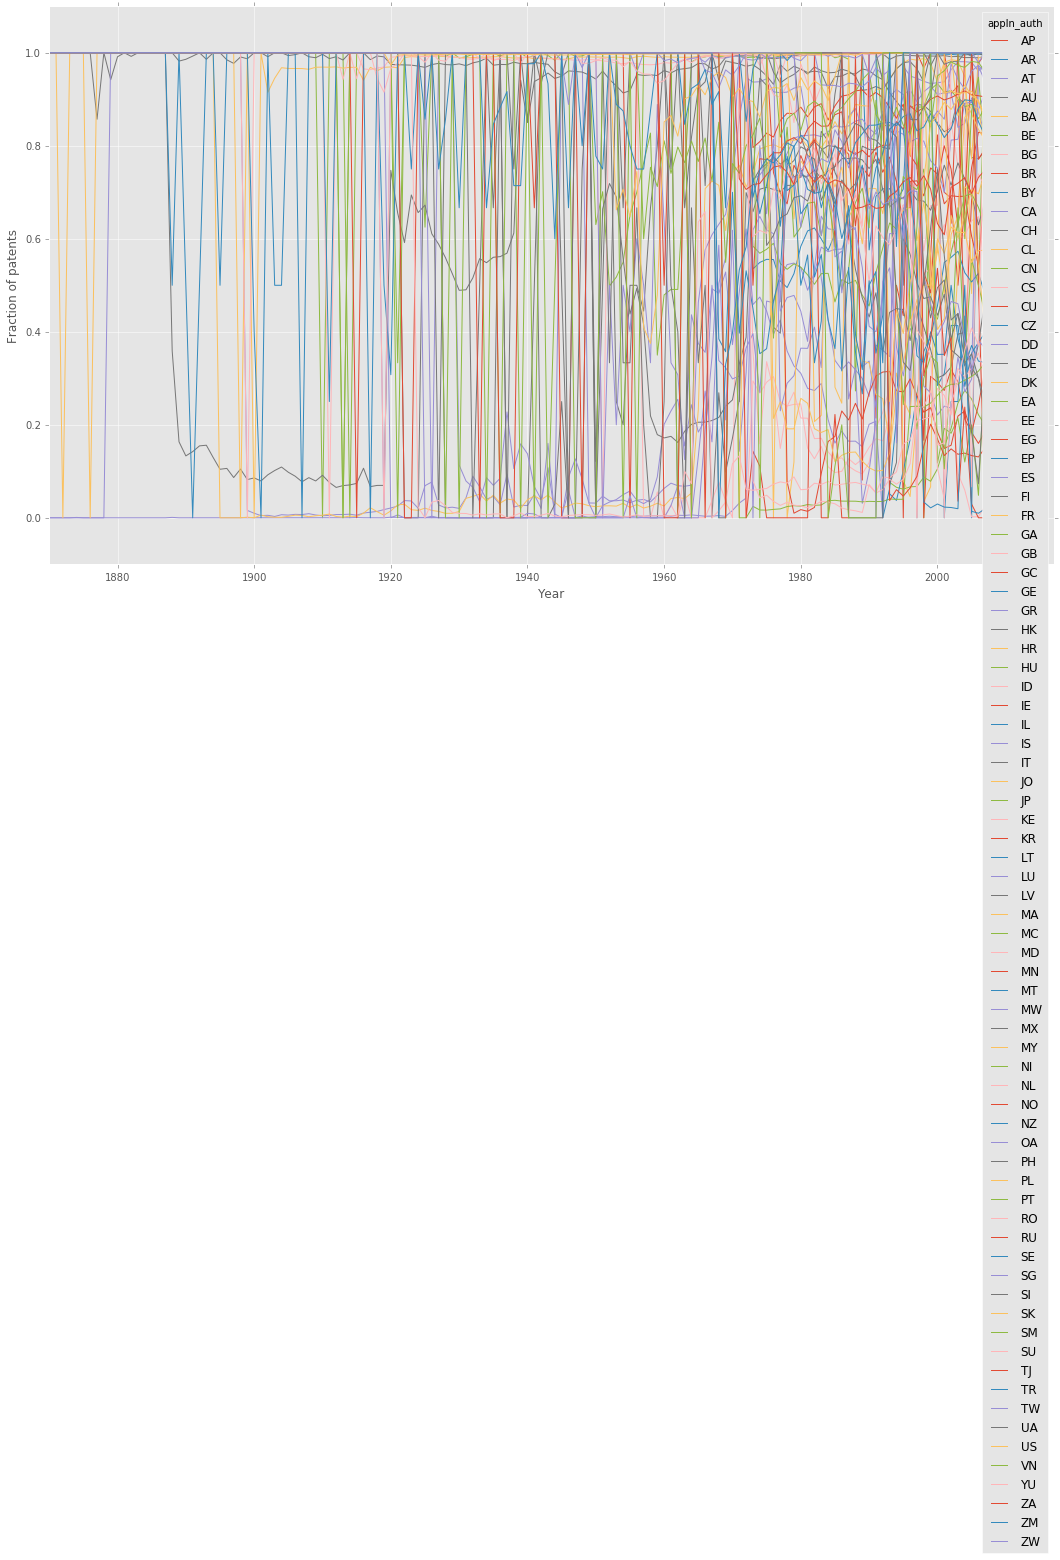

In [75]:
# For all Auths

df_au_year_frac_pv.frac_cpc.plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

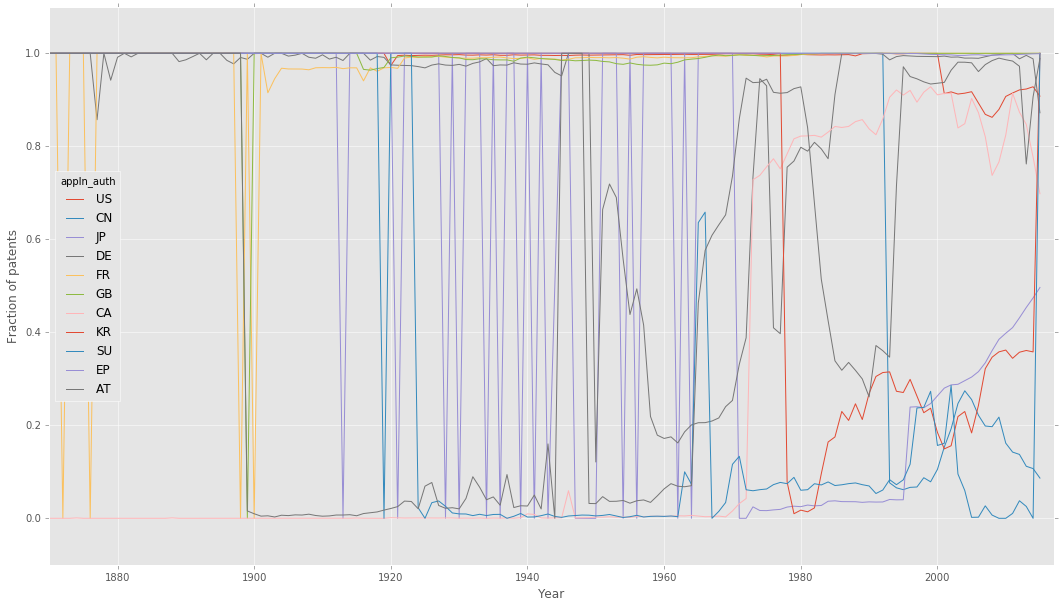

In [76]:
# For top 10 Auths

df_au_year_frac_pv.frac_cpc[auth_by_size[0:11]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

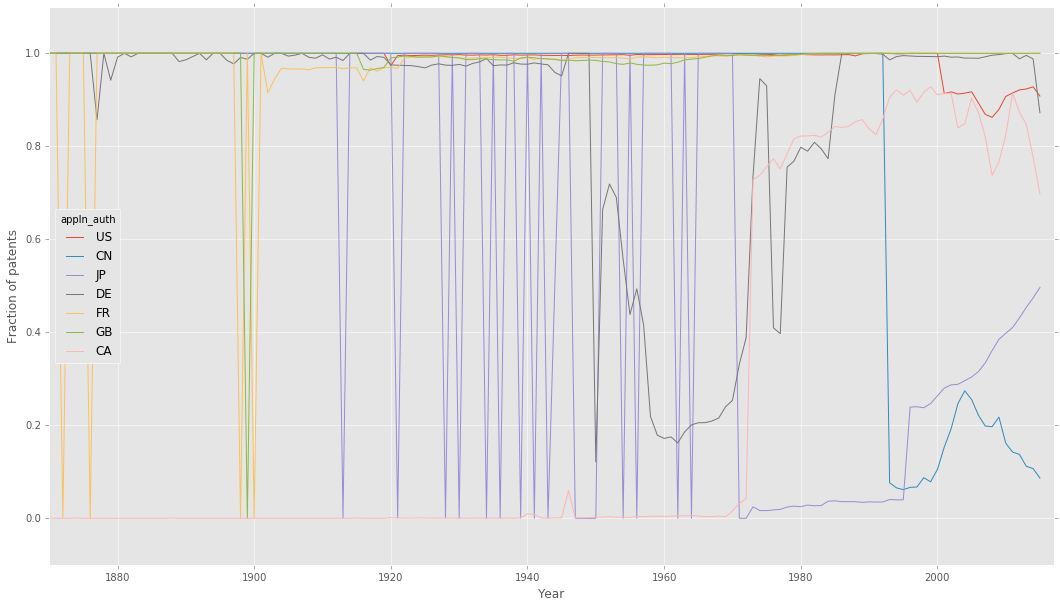

In [77]:
# For top 6 Auths

df_au_year_frac_pv.frac_cpc[auth_by_size[0:7]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

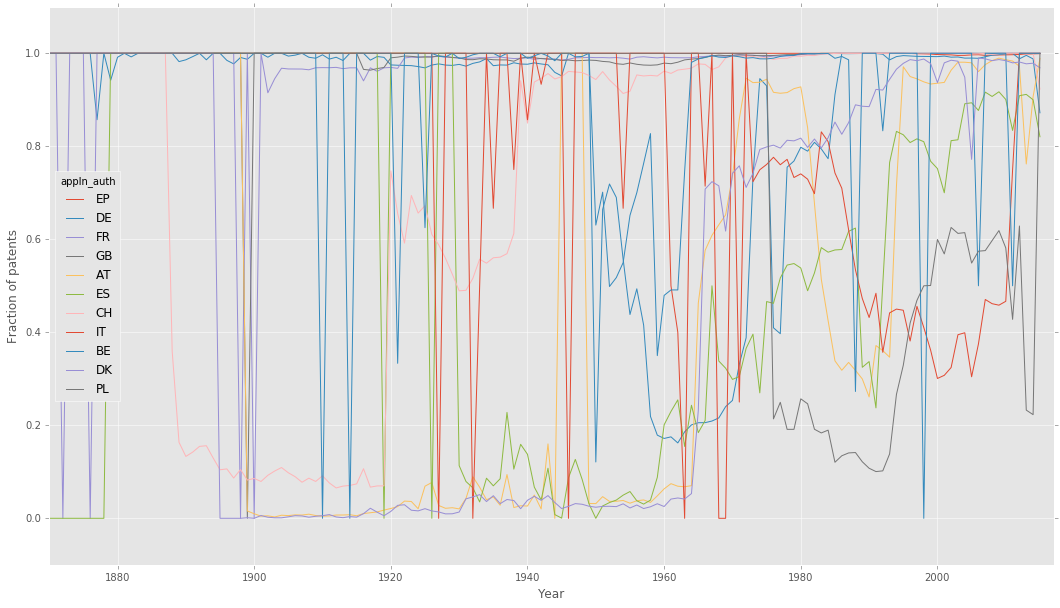

In [78]:
# For top 10 EU

df_au_year_frac_pv.frac_cpc[eu_auths[0:11]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')

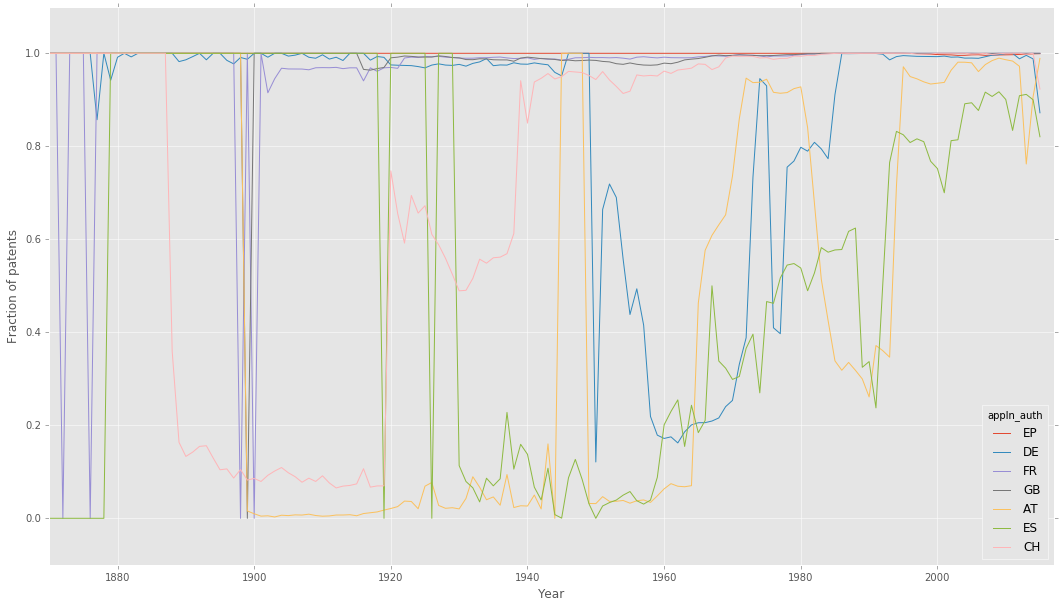

In [79]:
# For top 6 EU

df_au_year_frac_pv.frac_cpc[eu_auths[0:7]].plot(figsize=(18,10))
plt.xlim(1870,yr_min_max_plt[1])
plt.ylim(-0.1, 1.1)

plt.xlabel("Year")
plt.ylabel('Fraction of patents')